In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
from sklearn.neighbors import NearestNeighbors as nn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from lightgbm import LGBMClassifier
#from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score


In [328]:
random_state = 123*987*4-1
models_to_average = 50

In [329]:
real_dataset = pd.read_csv("./datasets/real_ds_shortincome.csv")
synt_data_distilgpt2 = pd.read_csv('./datasets/synt_ds_distillgpt2_shortincome_3epochs_temp0.7.csv')
synt_data_gpt2xl = pd.read_csv("./datasets/synt_ds_gpt2xl_shortincome_3epochs_temp0.7.csv")
synt_data_cerebras = pd.read_csv("./datasets/synt_ds_cerebras13_shortincome_3epochs_temp0.7.csv")
synt_data_phi = pd.read_csv("./datasets/synt_ds_phi15_shortincome_3epochs_temp0.7.csv")
control_dataset = pd.read_csv("./datasets/real_ds_shortincome_control.csv")

In [330]:
real_dataset.drop(columns="Unnamed: 0",inplace=True)
synt_data_distilgpt2.drop(columns="Unnamed: 0",inplace=True)
synt_data_gpt2xl.drop(columns="Unnamed: 0",inplace=True)
synt_data_cerebras.drop(columns="Unnamed: 0",inplace=True)
synt_data_phi.drop(columns="Unnamed: 0",inplace=True)
control_dataset.drop(columns="Unnamed: 0",inplace=True)


In [331]:
cols = real_dataset.columns

In [332]:
def strip (x) :
    if isinstance(x,str):
        return x.lstrip()
    else :
        return x

In [333]:
for col in cols :
    real_dataset[col] = real_dataset[col].map(strip) 

In [334]:
for col in cols :
    synt_data_distilgpt2[col] = synt_data_distilgpt2[col].map(strip) 

In [335]:
for col in cols :
    synt_data_gpt2xl[col] = synt_data_gpt2xl[col].map(strip) 

In [336]:
for col in cols :
    synt_data_cerebras[col] = synt_data_cerebras[col].map(strip) 

In [337]:
for col in cols :
    synt_data_phi[col] = synt_data_phi[col].map(strip) 

In [338]:
for col in cols :
    control_dataset[col] = control_dataset[col].map(strip) 

In [339]:
categs = list()
numeric = list()
for col in cols :
    print ('----------------------------------------------------')
    print (col, ':', real_dataset[col].dtype)
    print (len(real_dataset[col].unique()),'uniques values : ' ,real_dataset[col].unique())
    if real_dataset[col].dtype == 'object' :
        if col != 'target' :
            categs.append(col)
    else :
         numeric.append(col)
    

----------------------------------------------------
age : int64
91 uniques values :  [52 39 29 30 15  6 50 21 42 32  8 87 47 45  7  4 17 14 82 19 40 71 49 22
 74 25  2 36 35 18 58 54 24 37 80 73 55  0 62 28 78 41 75 60 69 13 12 61
 44 64  3 43 27 31 46 76 33 23 84 48  1  5 70 16 51 38 72  9 20 56 90 11
 67 26 34 10 57 53 66 77 85 89 68 79 81 65 59 83 88 63 86]
----------------------------------------------------
class_of_worker : object
9 uniques values :  ['Private' 'Self-employed-not incorporated' 'Not in universe'
 'Self-employed-incorporated' 'Local government' 'State government'
 'Federal government' 'Never worked' 'Without pay']
----------------------------------------------------
education : object
17 uniques values :  ['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate

In [340]:
# these features are categorical by definition
numeric.remove('own_business_or_self_employed')
categs.append('own_business_or_self_employed')


In [341]:
numeric

['age',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [342]:
categs

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [343]:
target_encoder= {'50000+.': 1, 
                '- 50000.': 0} 

# Data analysis

### Real data 

In [344]:
real_dataset.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      34.438300             188.126267                         1.964933   
std       22.350409            2007.247607                         2.375379   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.171133             23.182433  
std                         0.548383             24.424737  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              8.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [345]:
print(real_dataset.isna().sum().sum())

0


In [346]:
real_dataset['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

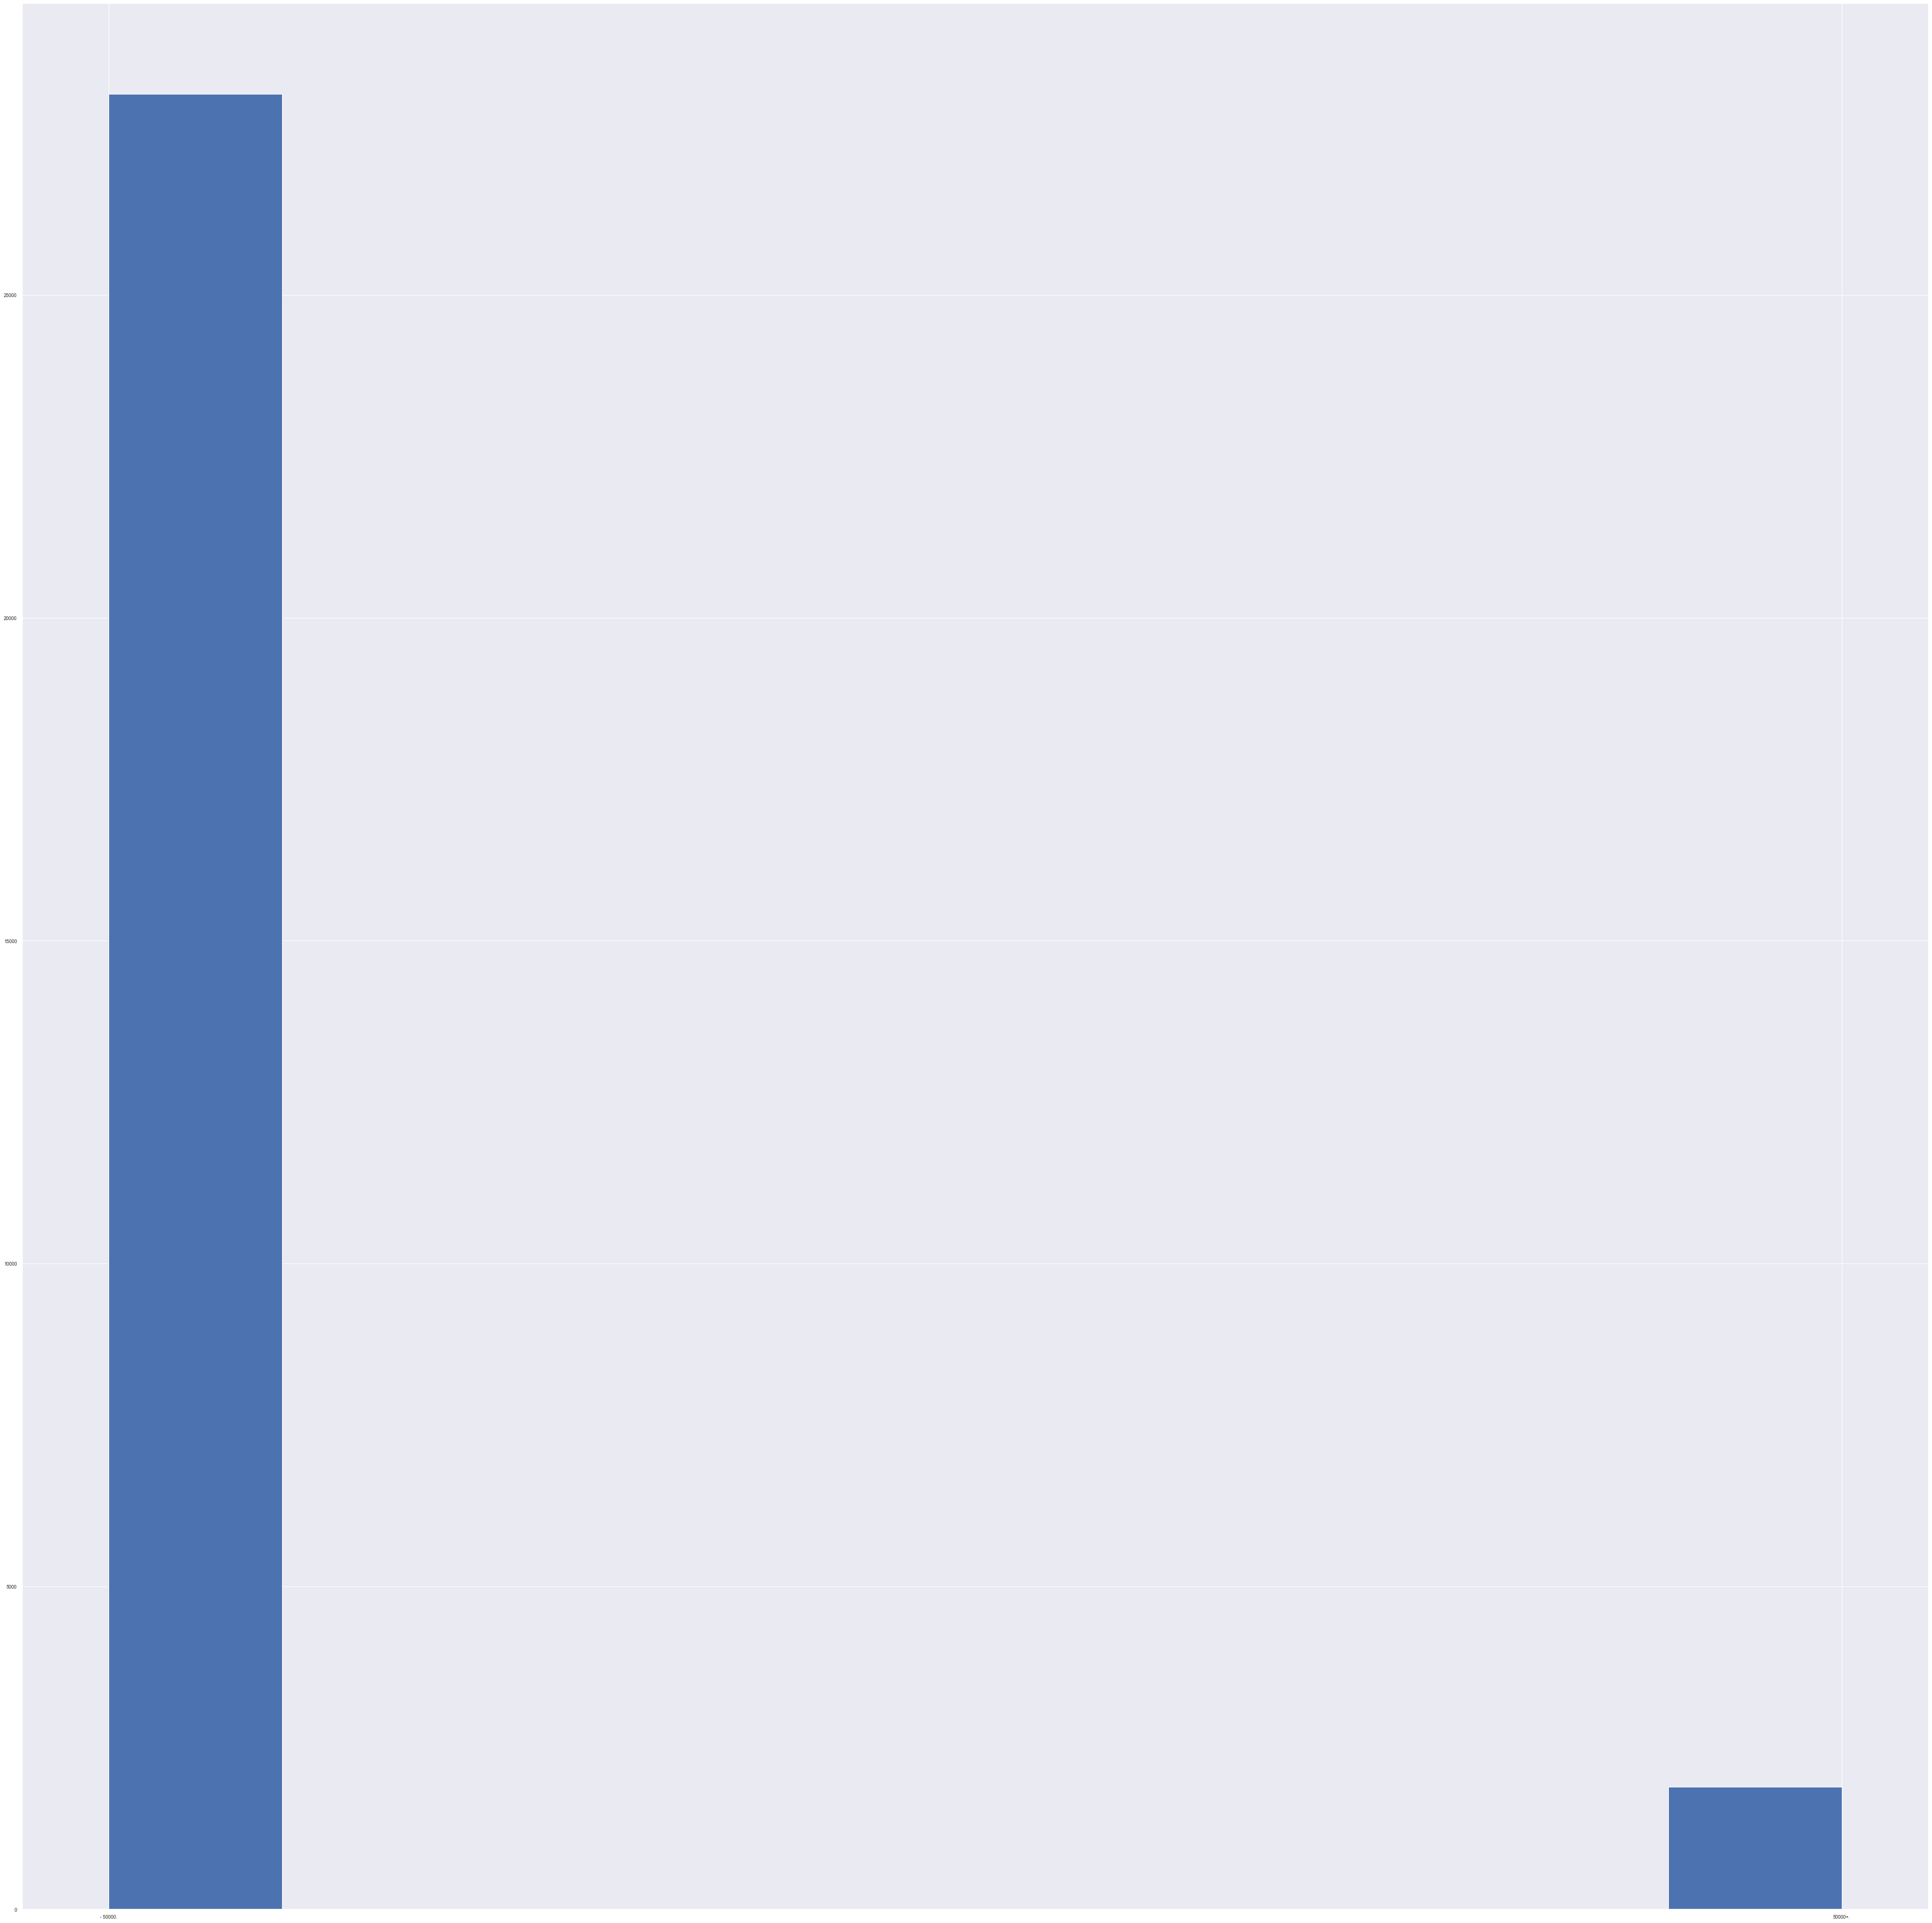

In [347]:
real_dataset['target'].hist()

In [348]:
print(f" Real data for binary classification is imbalanced: {len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}% and {100-len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}%")


 Real data for binary classification is imbalanced: 6.30% and 93.70%


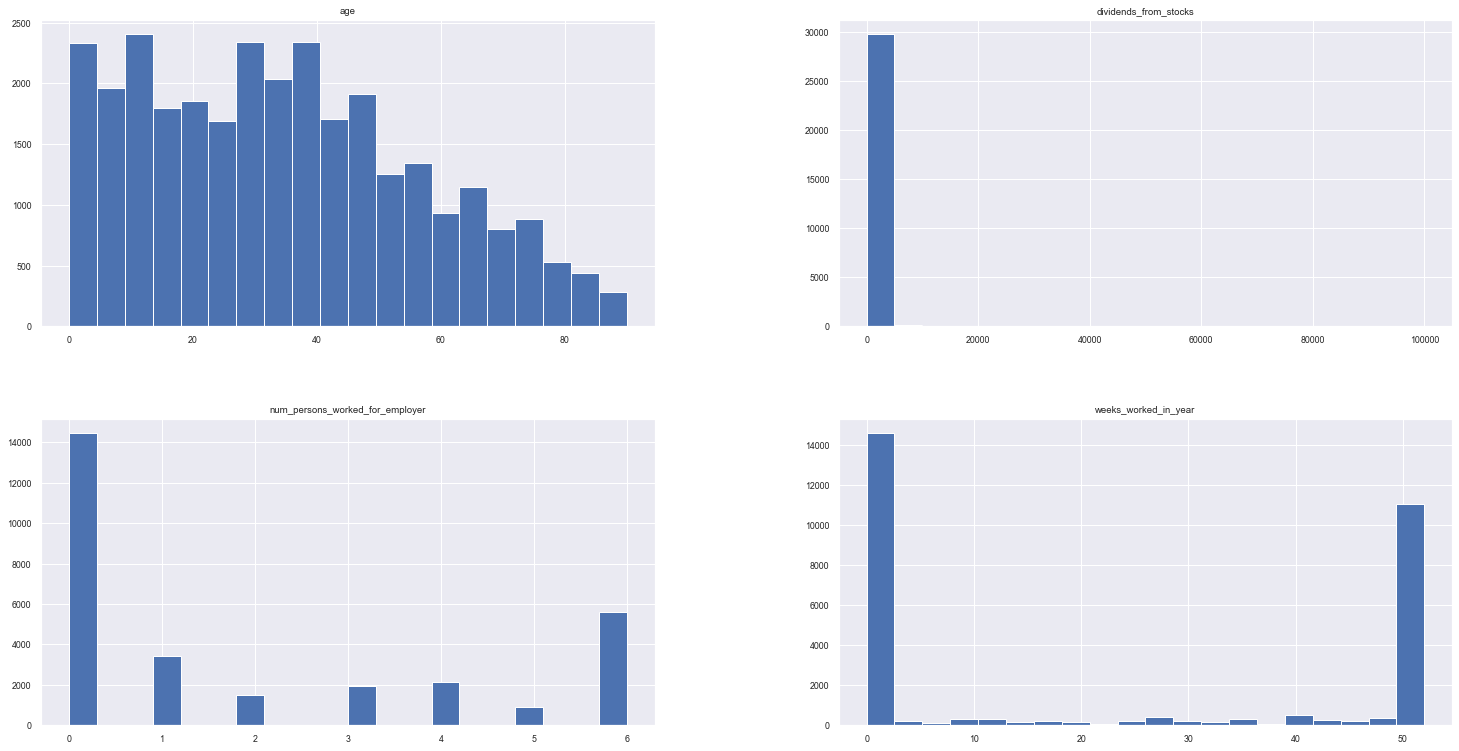

In [349]:
real_dataset[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

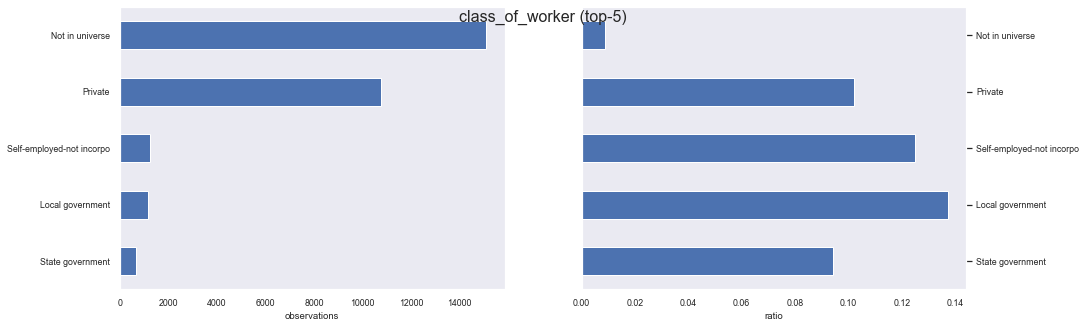

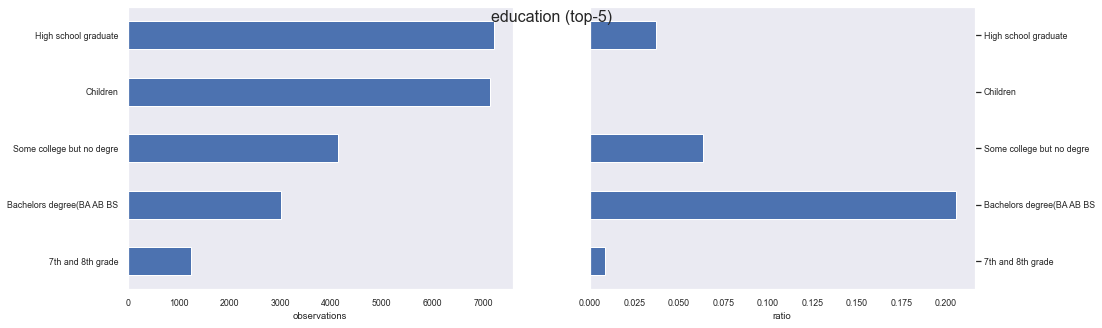

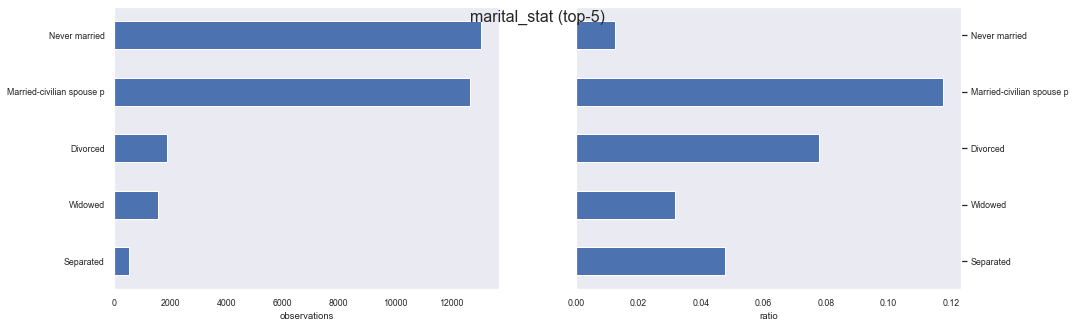

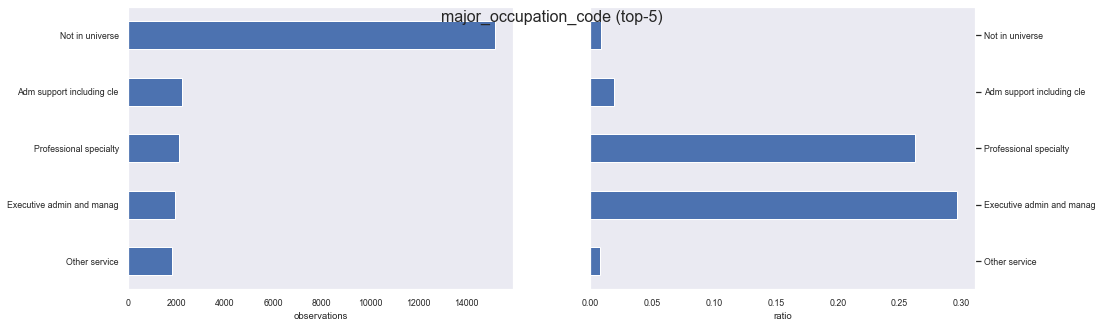

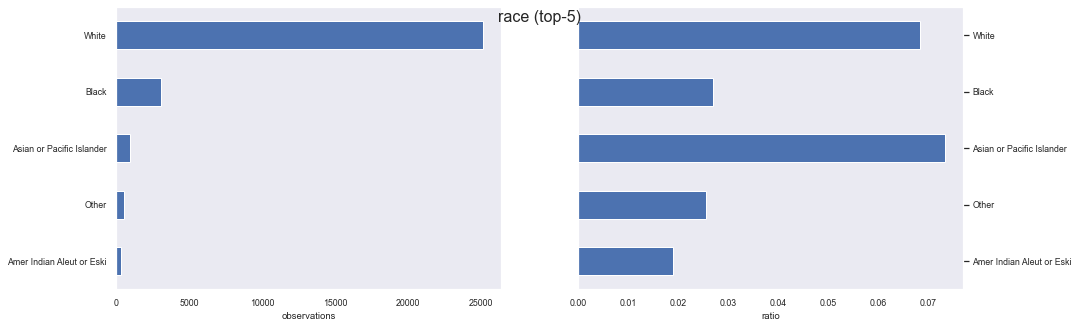

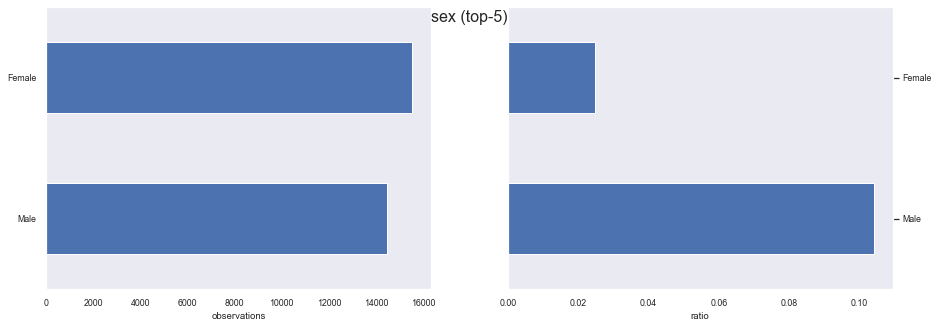

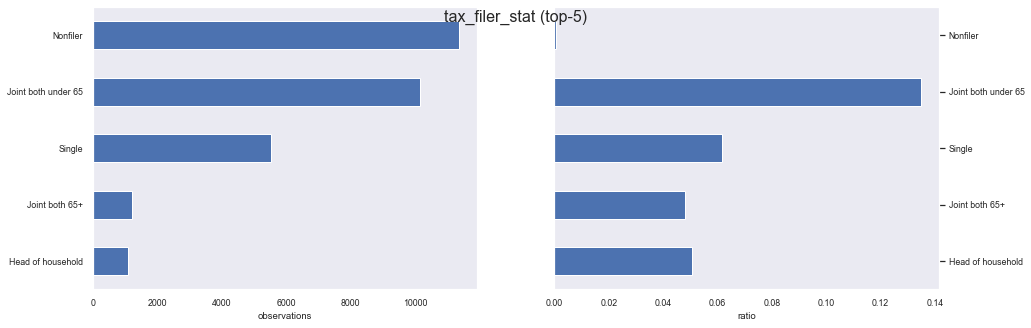

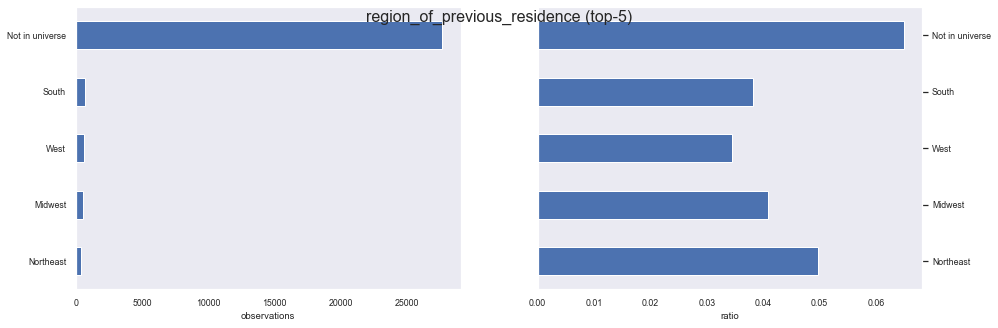

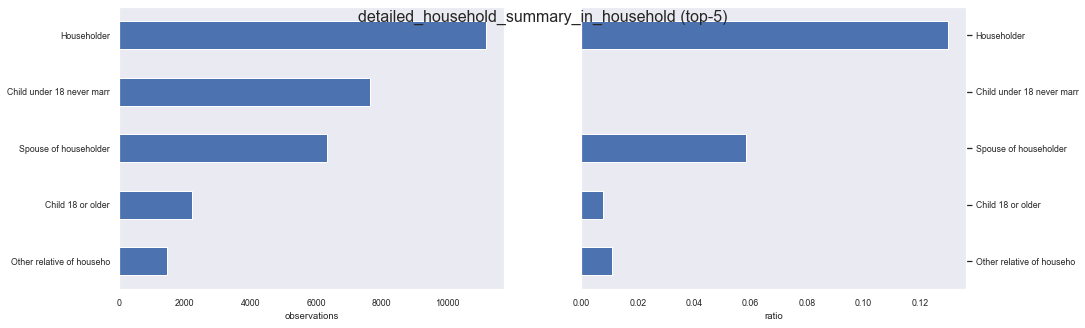

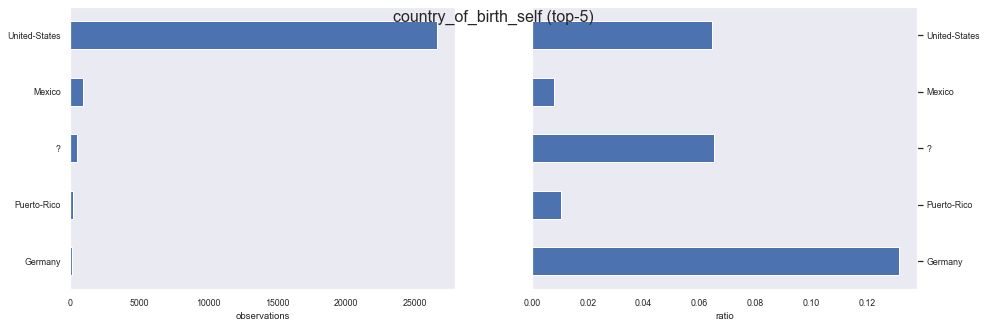

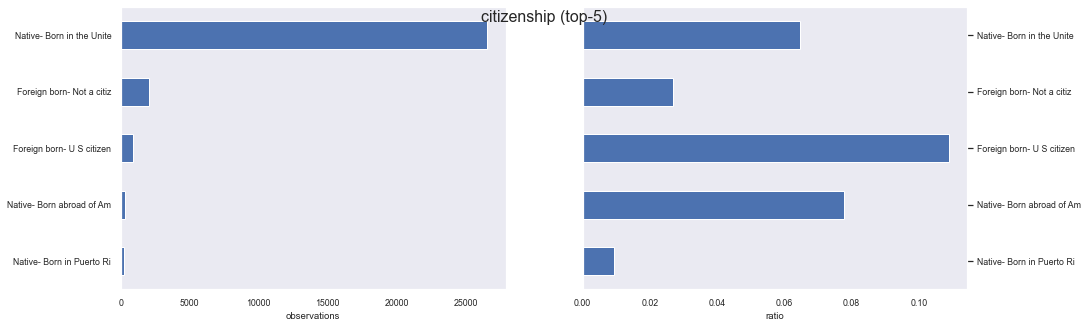

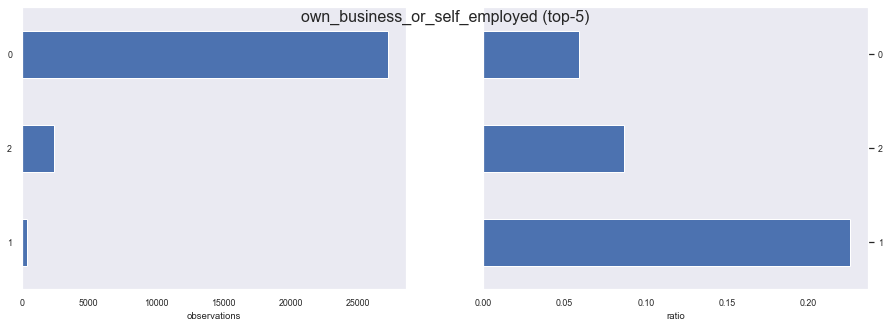

In [350]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = real_dataset.drop(['target'], axis=1).assign(cnt=1, target=real_dataset['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### DistillGPT

In [351]:
synt_data_distilgpt2.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      33.450533              13.076833                         1.881967   
std       21.638225             394.574328                         2.472483   
min        0.000000               0.000000                         0.000000   
25%       14.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         0.000000   
75%       47.000000               0.000000                         4.000000   
max       90.000000           50000.000000                        16.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.065567             22.533767  
std                         0.353655             25.425428  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [352]:
print(synt_data_distilgpt2.isna().sum().sum())
print(synt_data_distilgpt2.isna().sum())

0
age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
target                                     0
dtype: int64


In [353]:
synt_data_distilgpt2['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

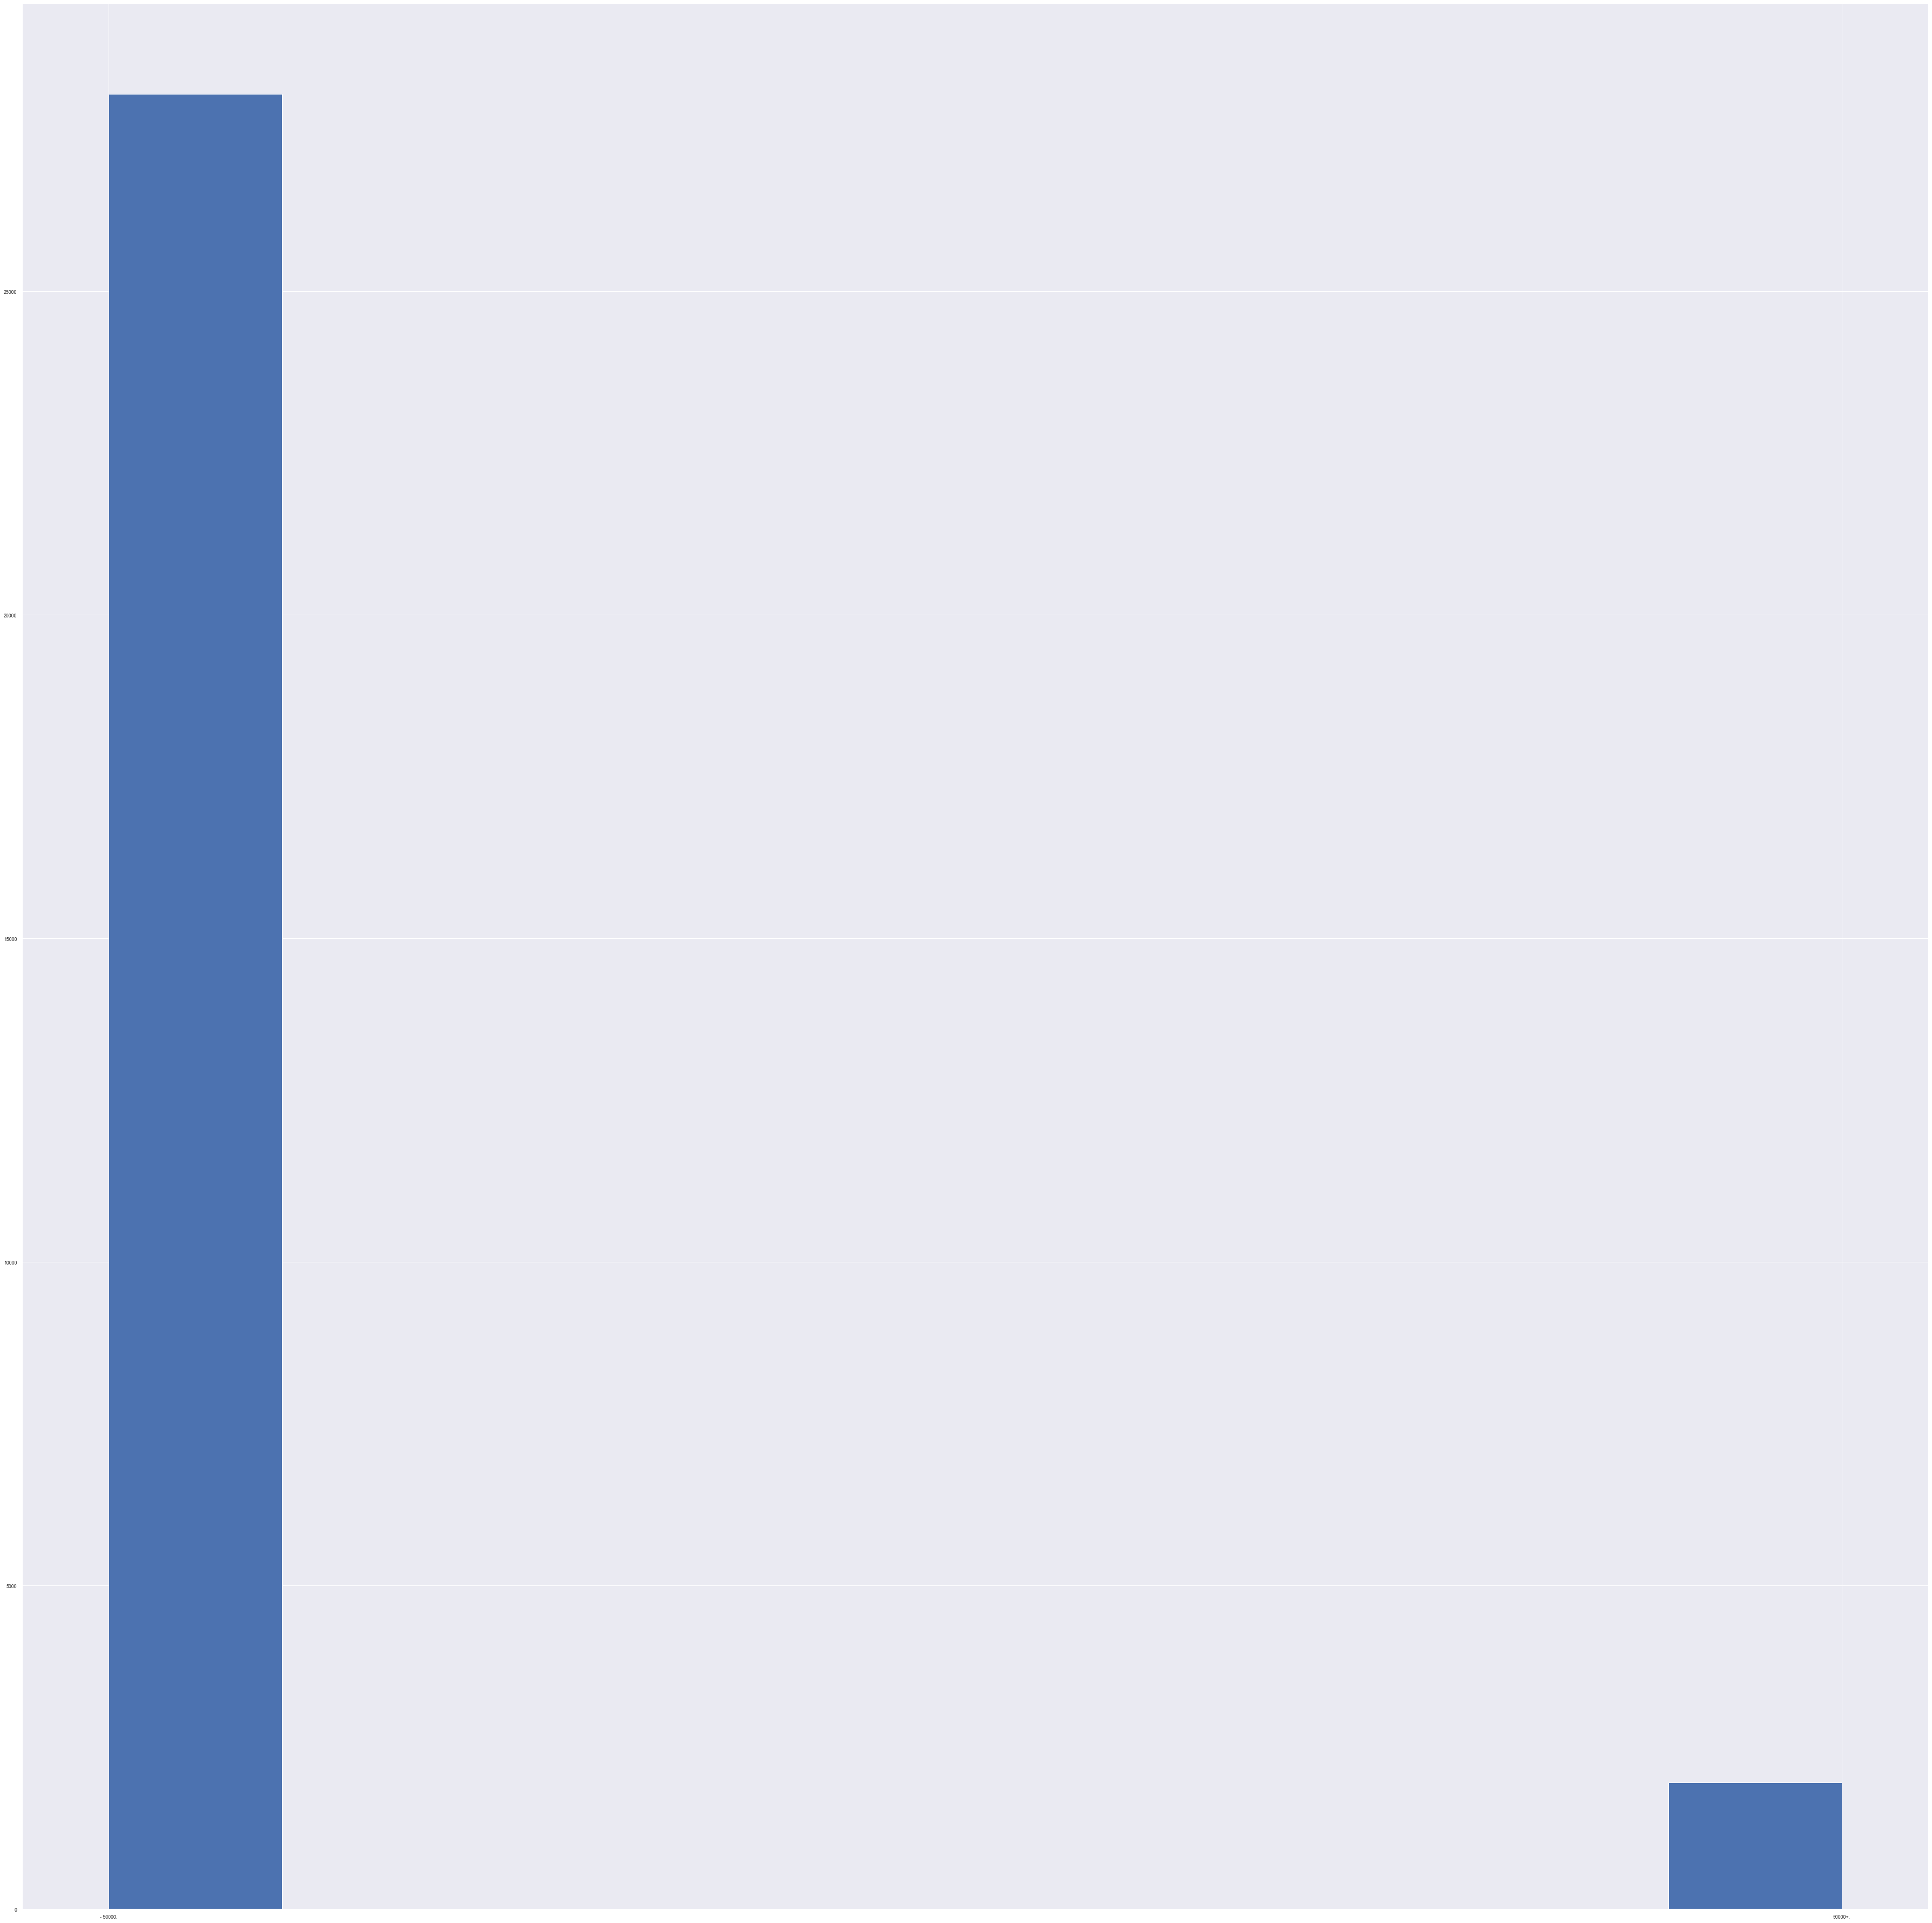

In [354]:
synt_data_distilgpt2['target'].hist()

In [355]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}% and {100-len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}%")


 Synthetic data for binary classification is imbalanced: 0.00% and 100.00%


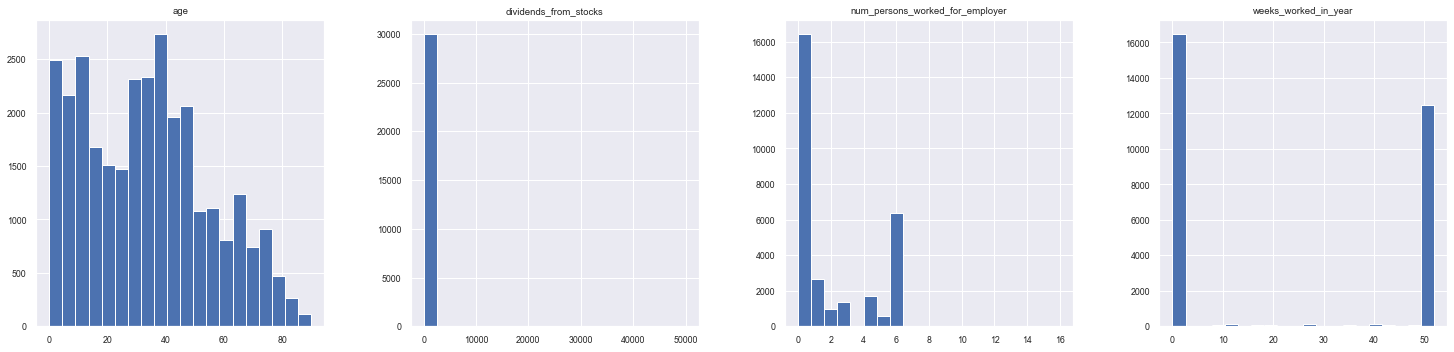

In [356]:
synt_data_distilgpt2[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 4))
plt.show()

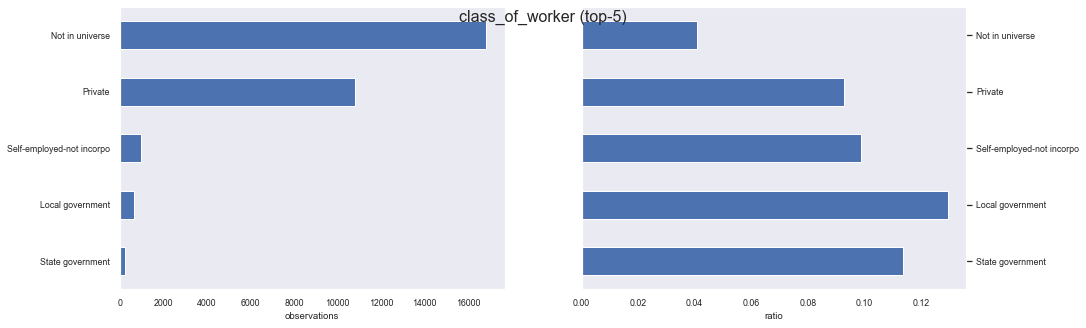

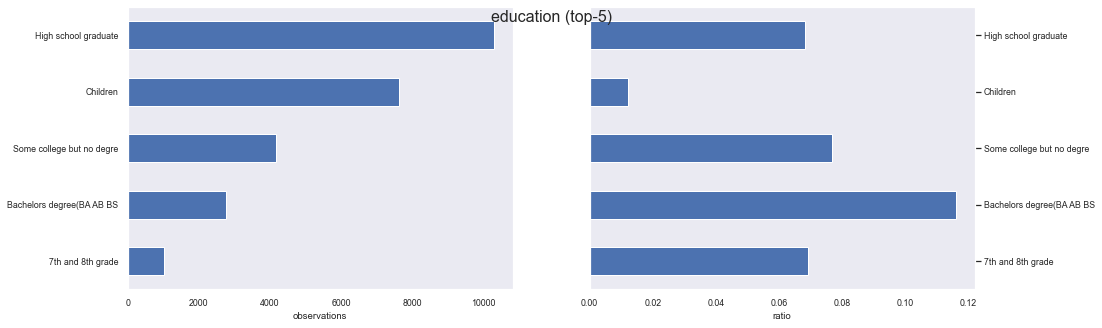

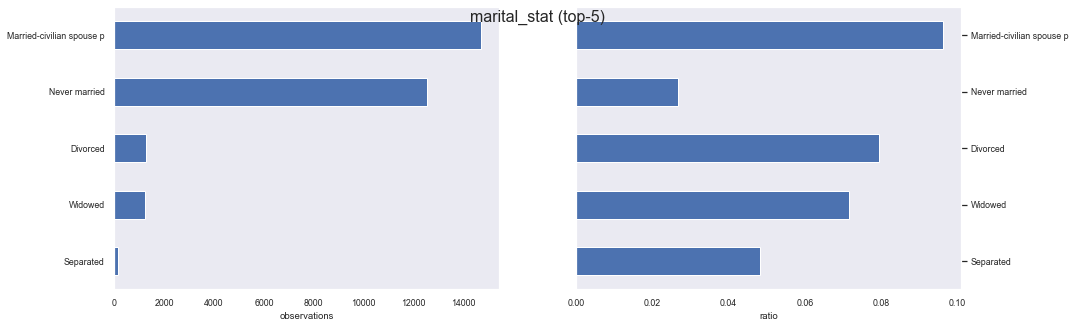

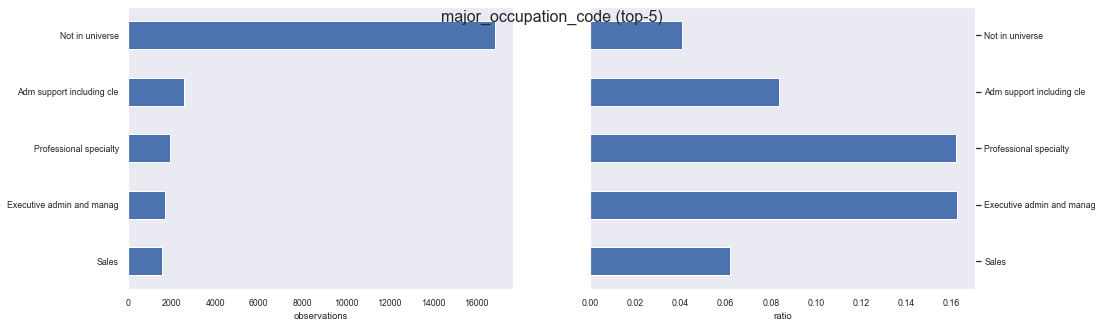

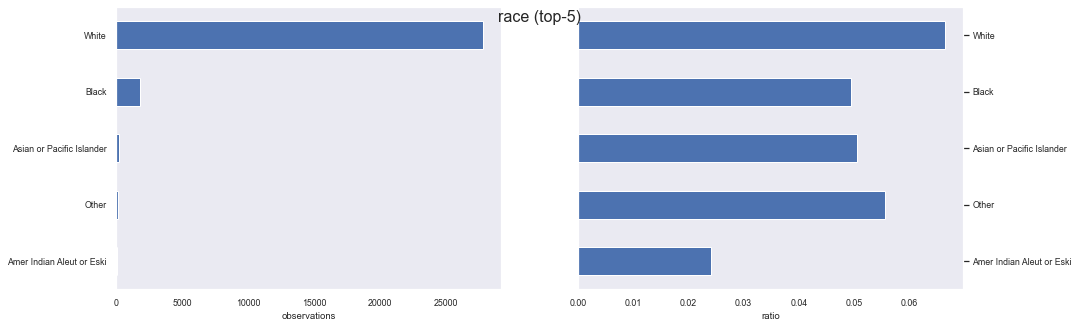

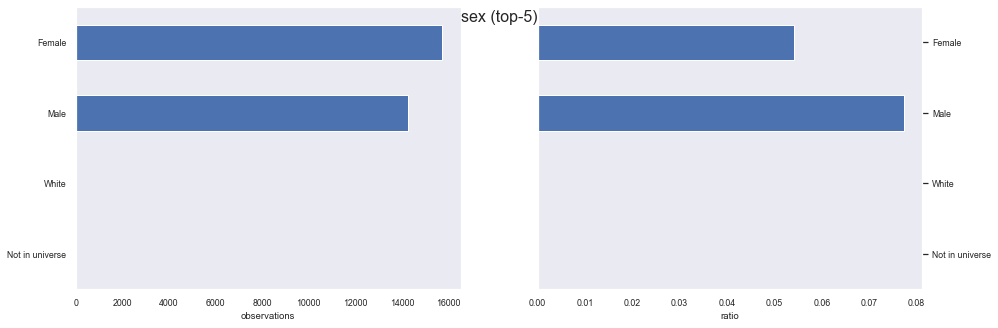

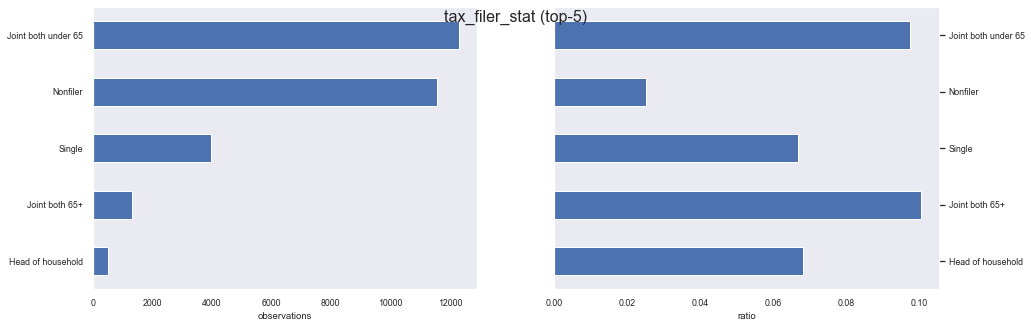

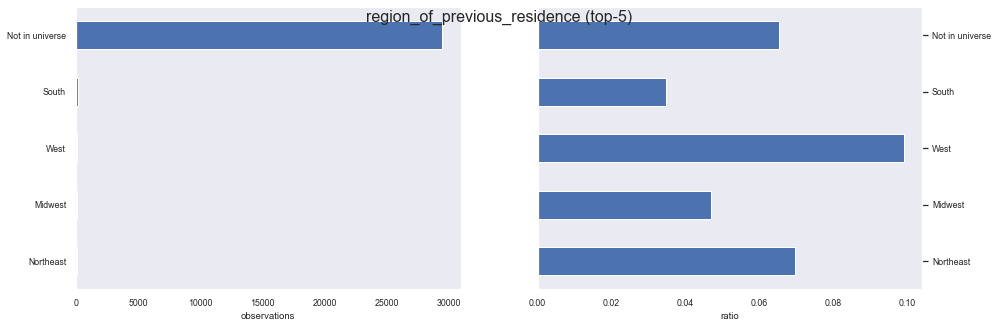

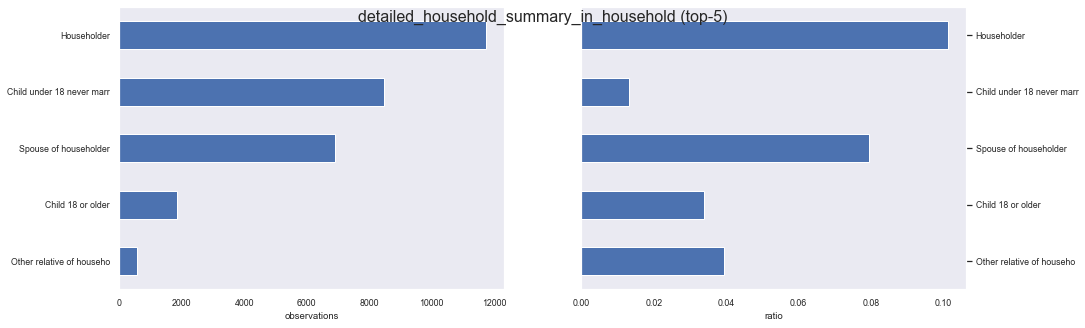

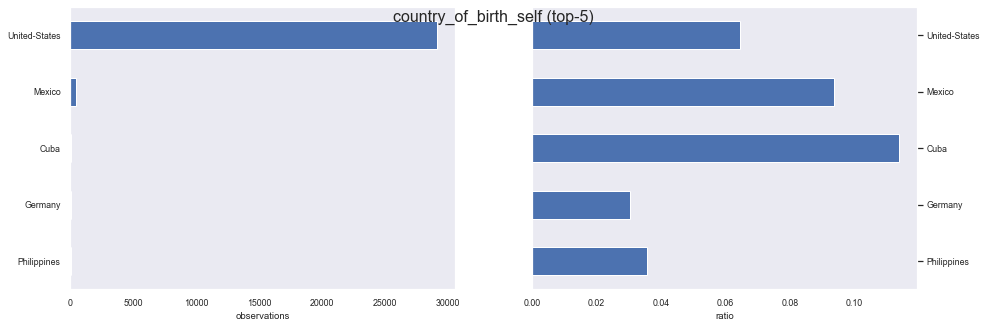

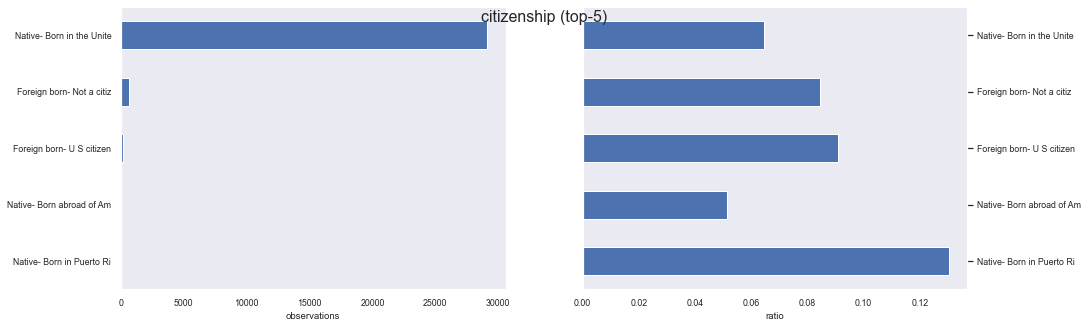

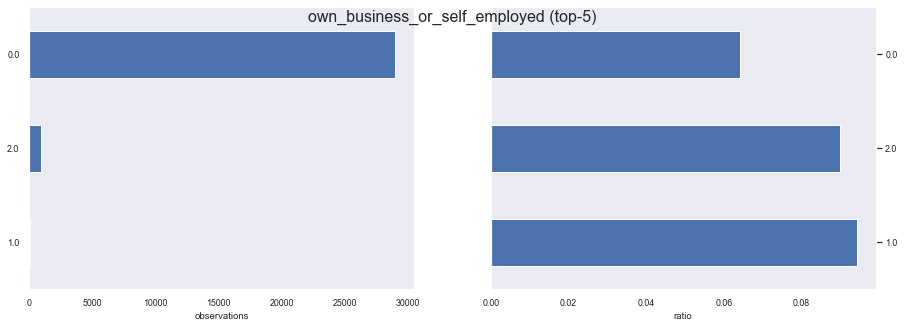

In [357]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_distilgpt2.drop(['target'], axis=1).assign(cnt=1, target=synt_data_distilgpt2['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### GPT2XL 

In [358]:
synt_data_gpt2xl.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      28.829033              25.915833                         1.855067   
std       21.472546             974.508406                         2.491399   
min        0.000000               0.000000                         0.000000   
25%       10.000000               0.000000                         0.000000   
50%       28.000000               0.000000                         0.000000   
75%       43.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.064133             21.627767  
std                         0.349797             25.332148  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         6.000000             52.000000

In [359]:
print(synt_data_gpt2xl.isna().sum().sum())

0


In [360]:
synt_data_gpt2xl['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

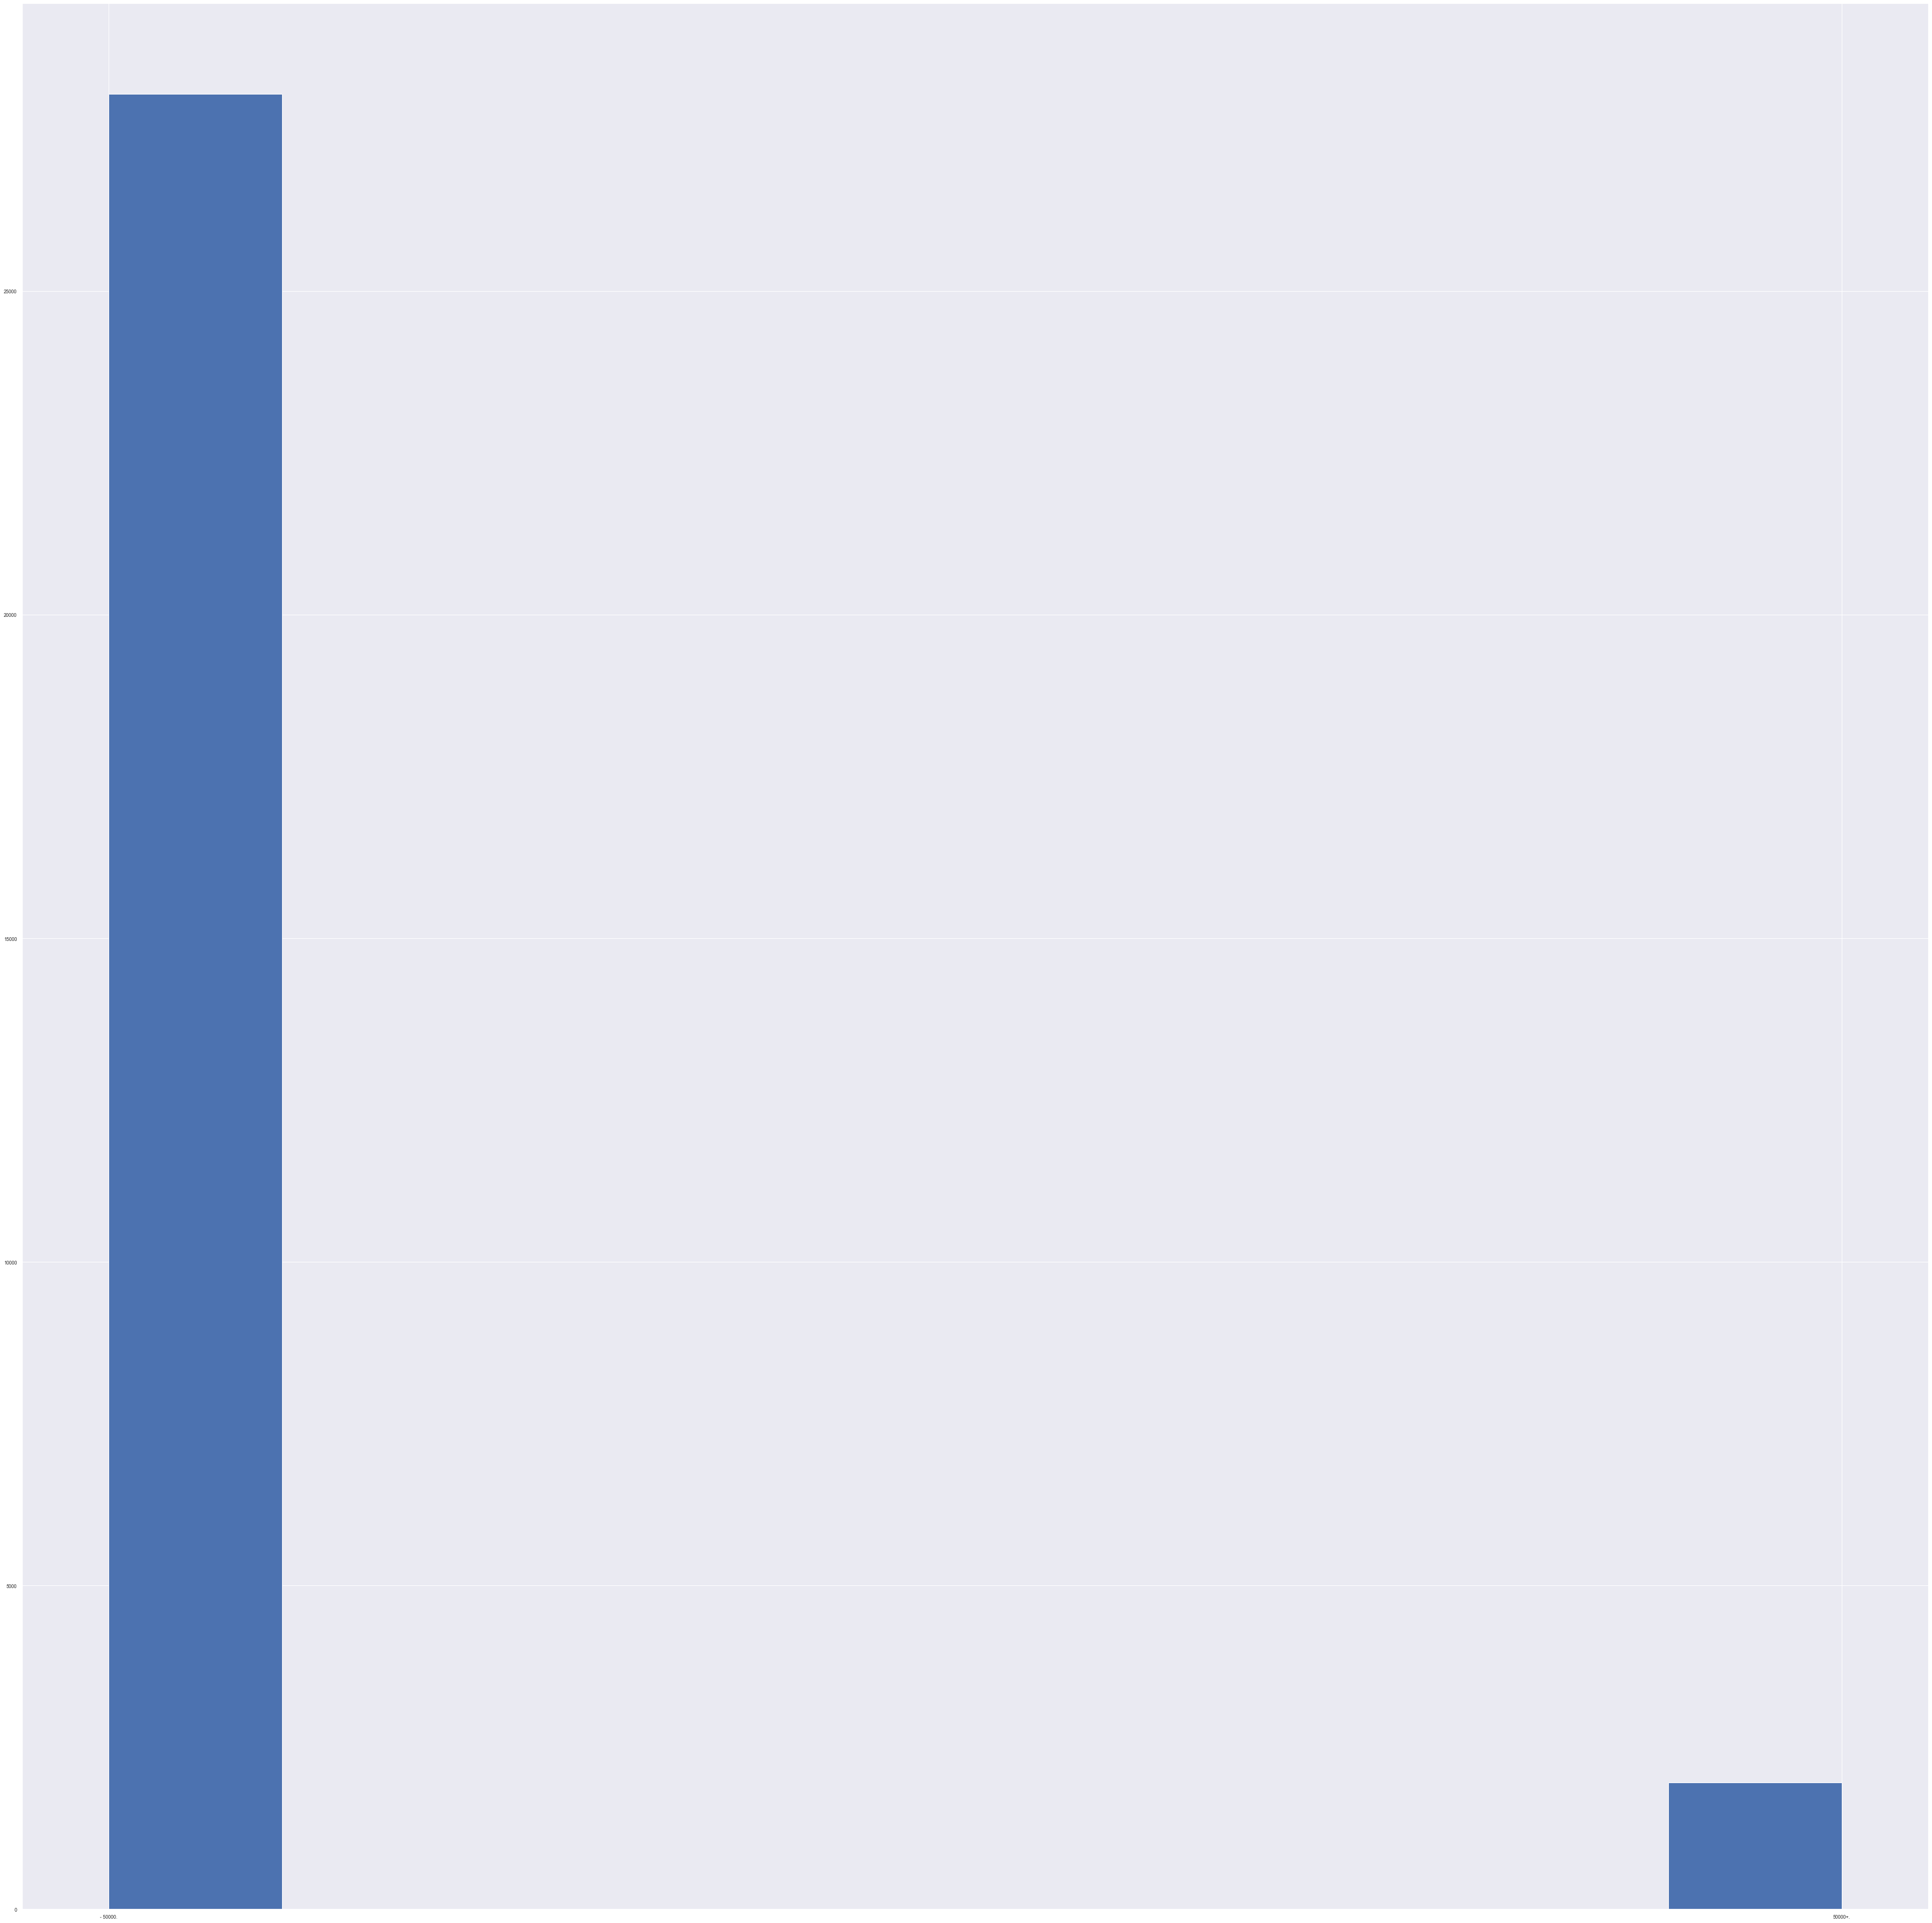

In [361]:
synt_data_gpt2xl['target'].hist()

In [362]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}% and {100-len(synt_data_gpt2xl[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.52% and 93.48%


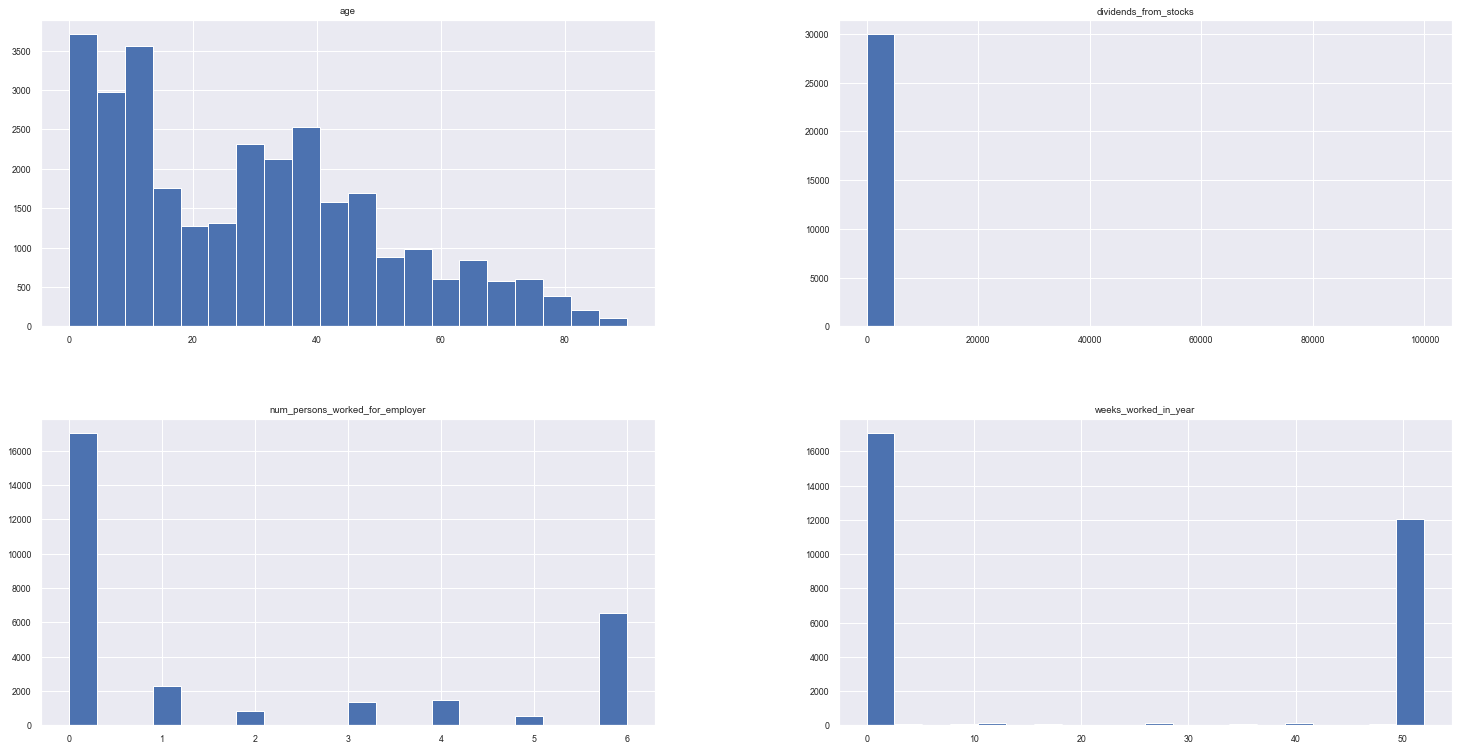

In [363]:
synt_data_gpt2xl[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

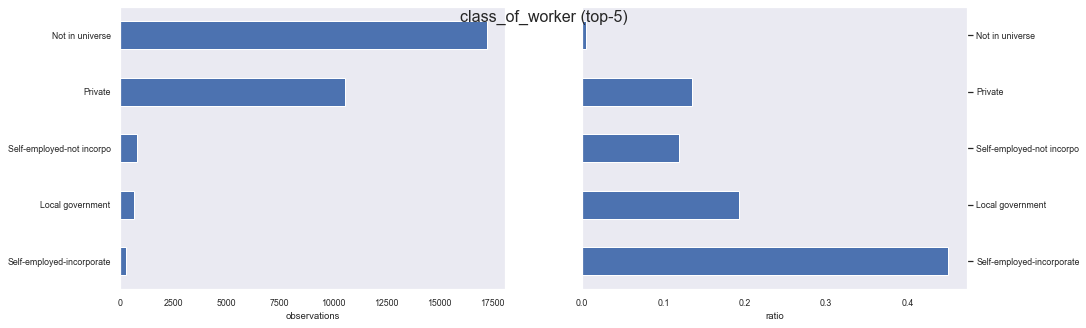

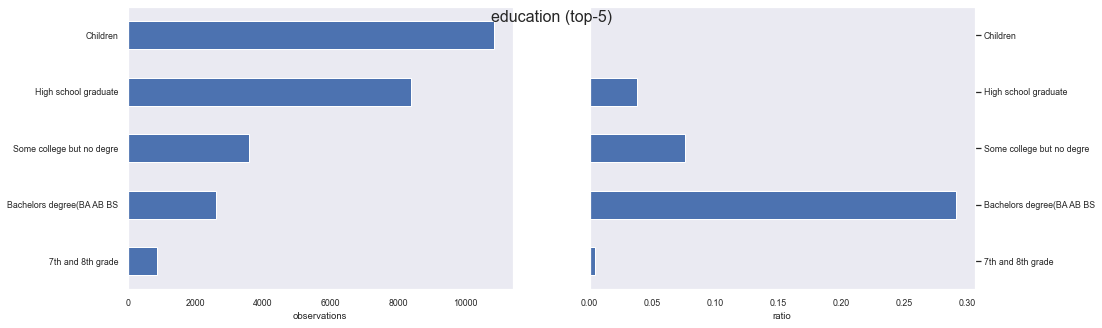

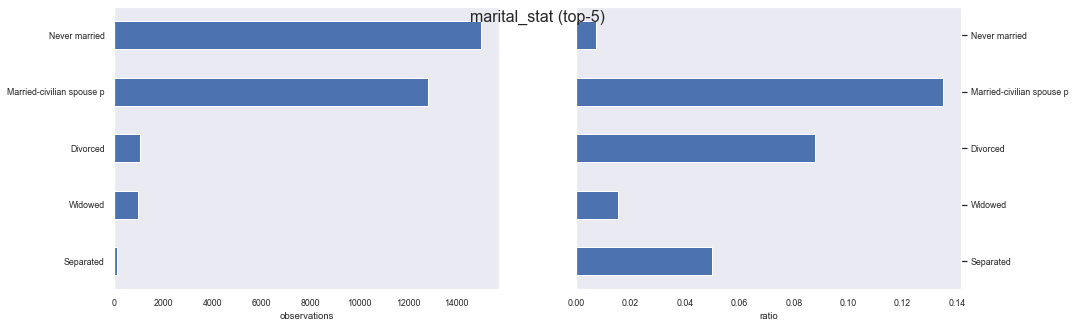

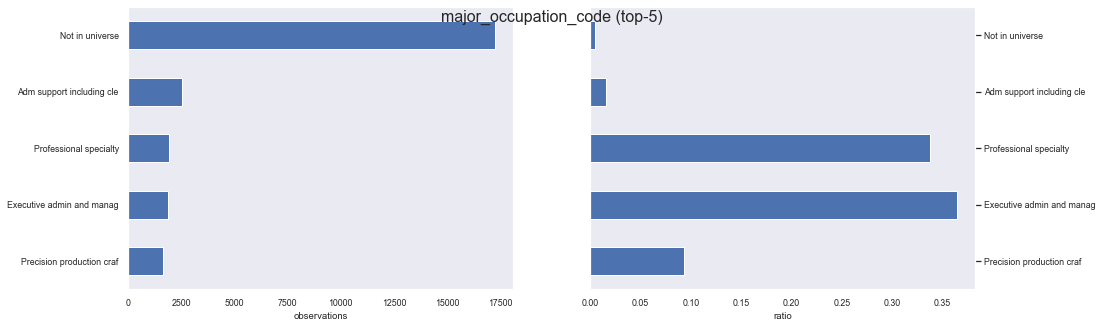

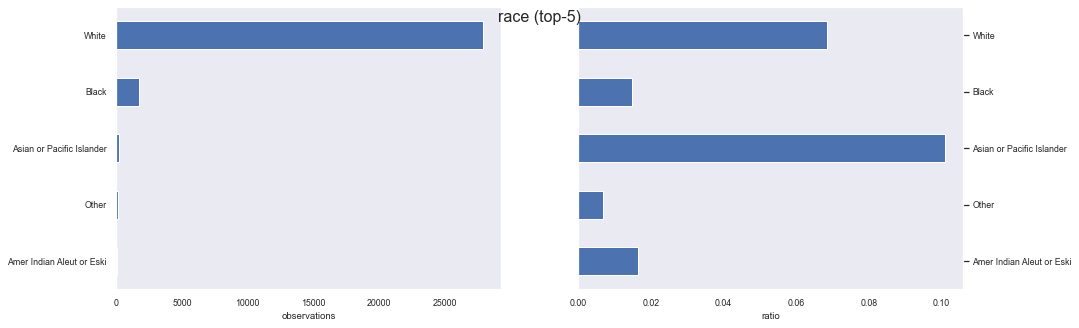

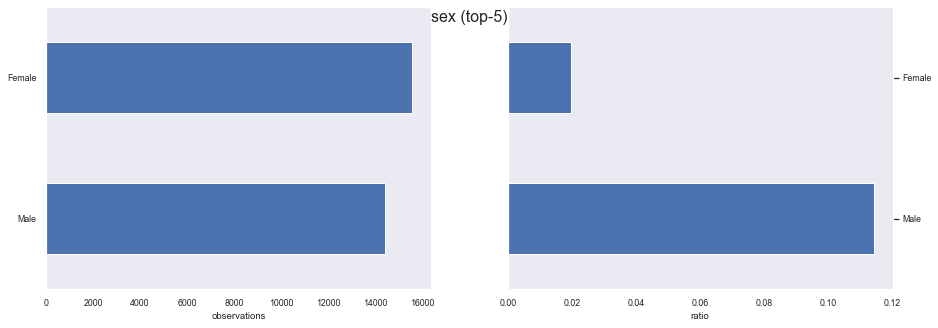

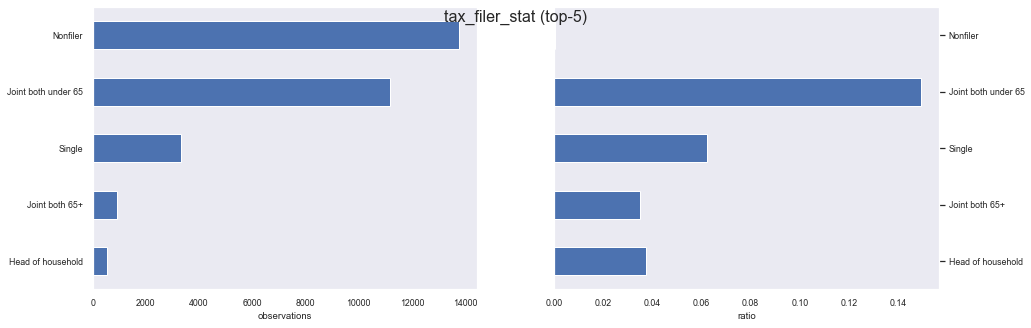

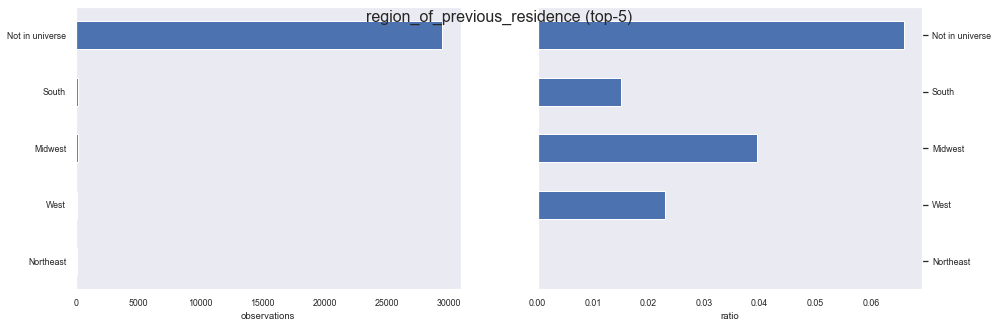

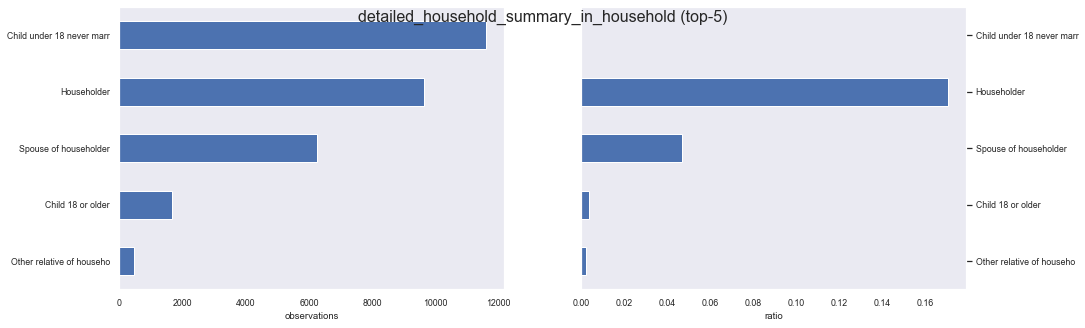

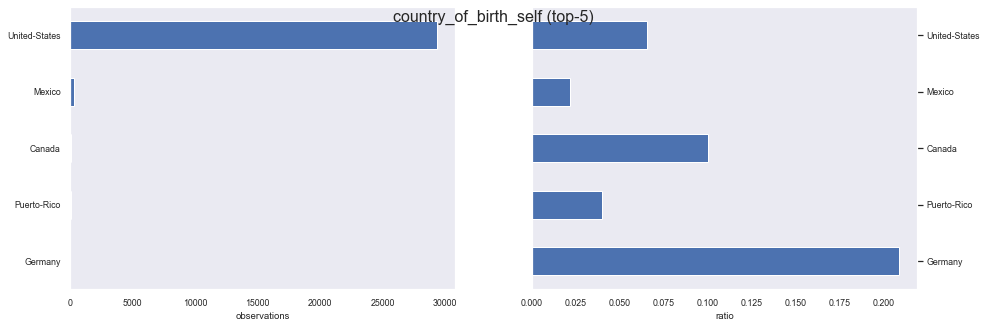

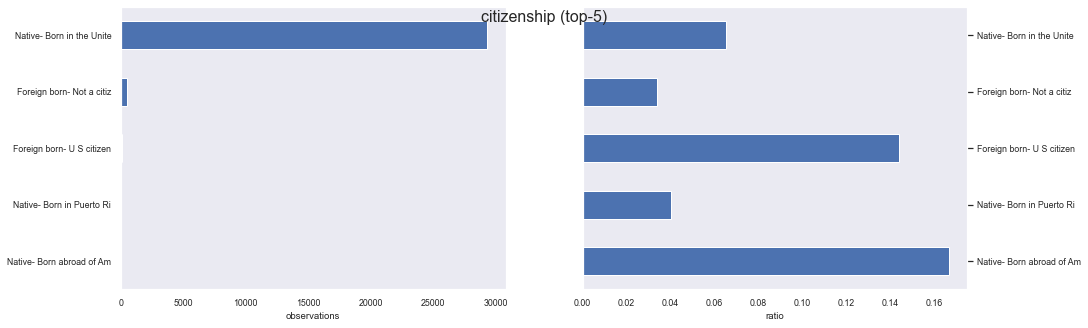

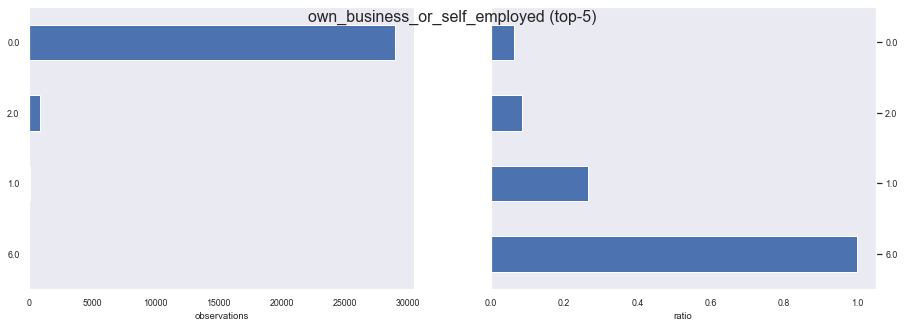

In [364]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_gpt2xl.drop(['target'], axis=1).assign(cnt=1, target=synt_data_gpt2xl['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Cerebras 

In [365]:
synt_data_cerebras.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      28.903600              18.938333                         1.846667   
std       21.543158             713.064579                         2.483323   
min        0.000000               0.000000                         0.000000   
25%       10.000000               0.000000                         0.000000   
50%       28.000000               0.000000                         0.000000   
75%       43.000000               0.000000                         4.000000   
max       90.000000           99999.000000                        10.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.062900             21.784433  
std                         0.344888             25.358511  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [366]:
print(synt_data_cerebras.isna().sum().sum())

0


In [367]:
synt_data_cerebras['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

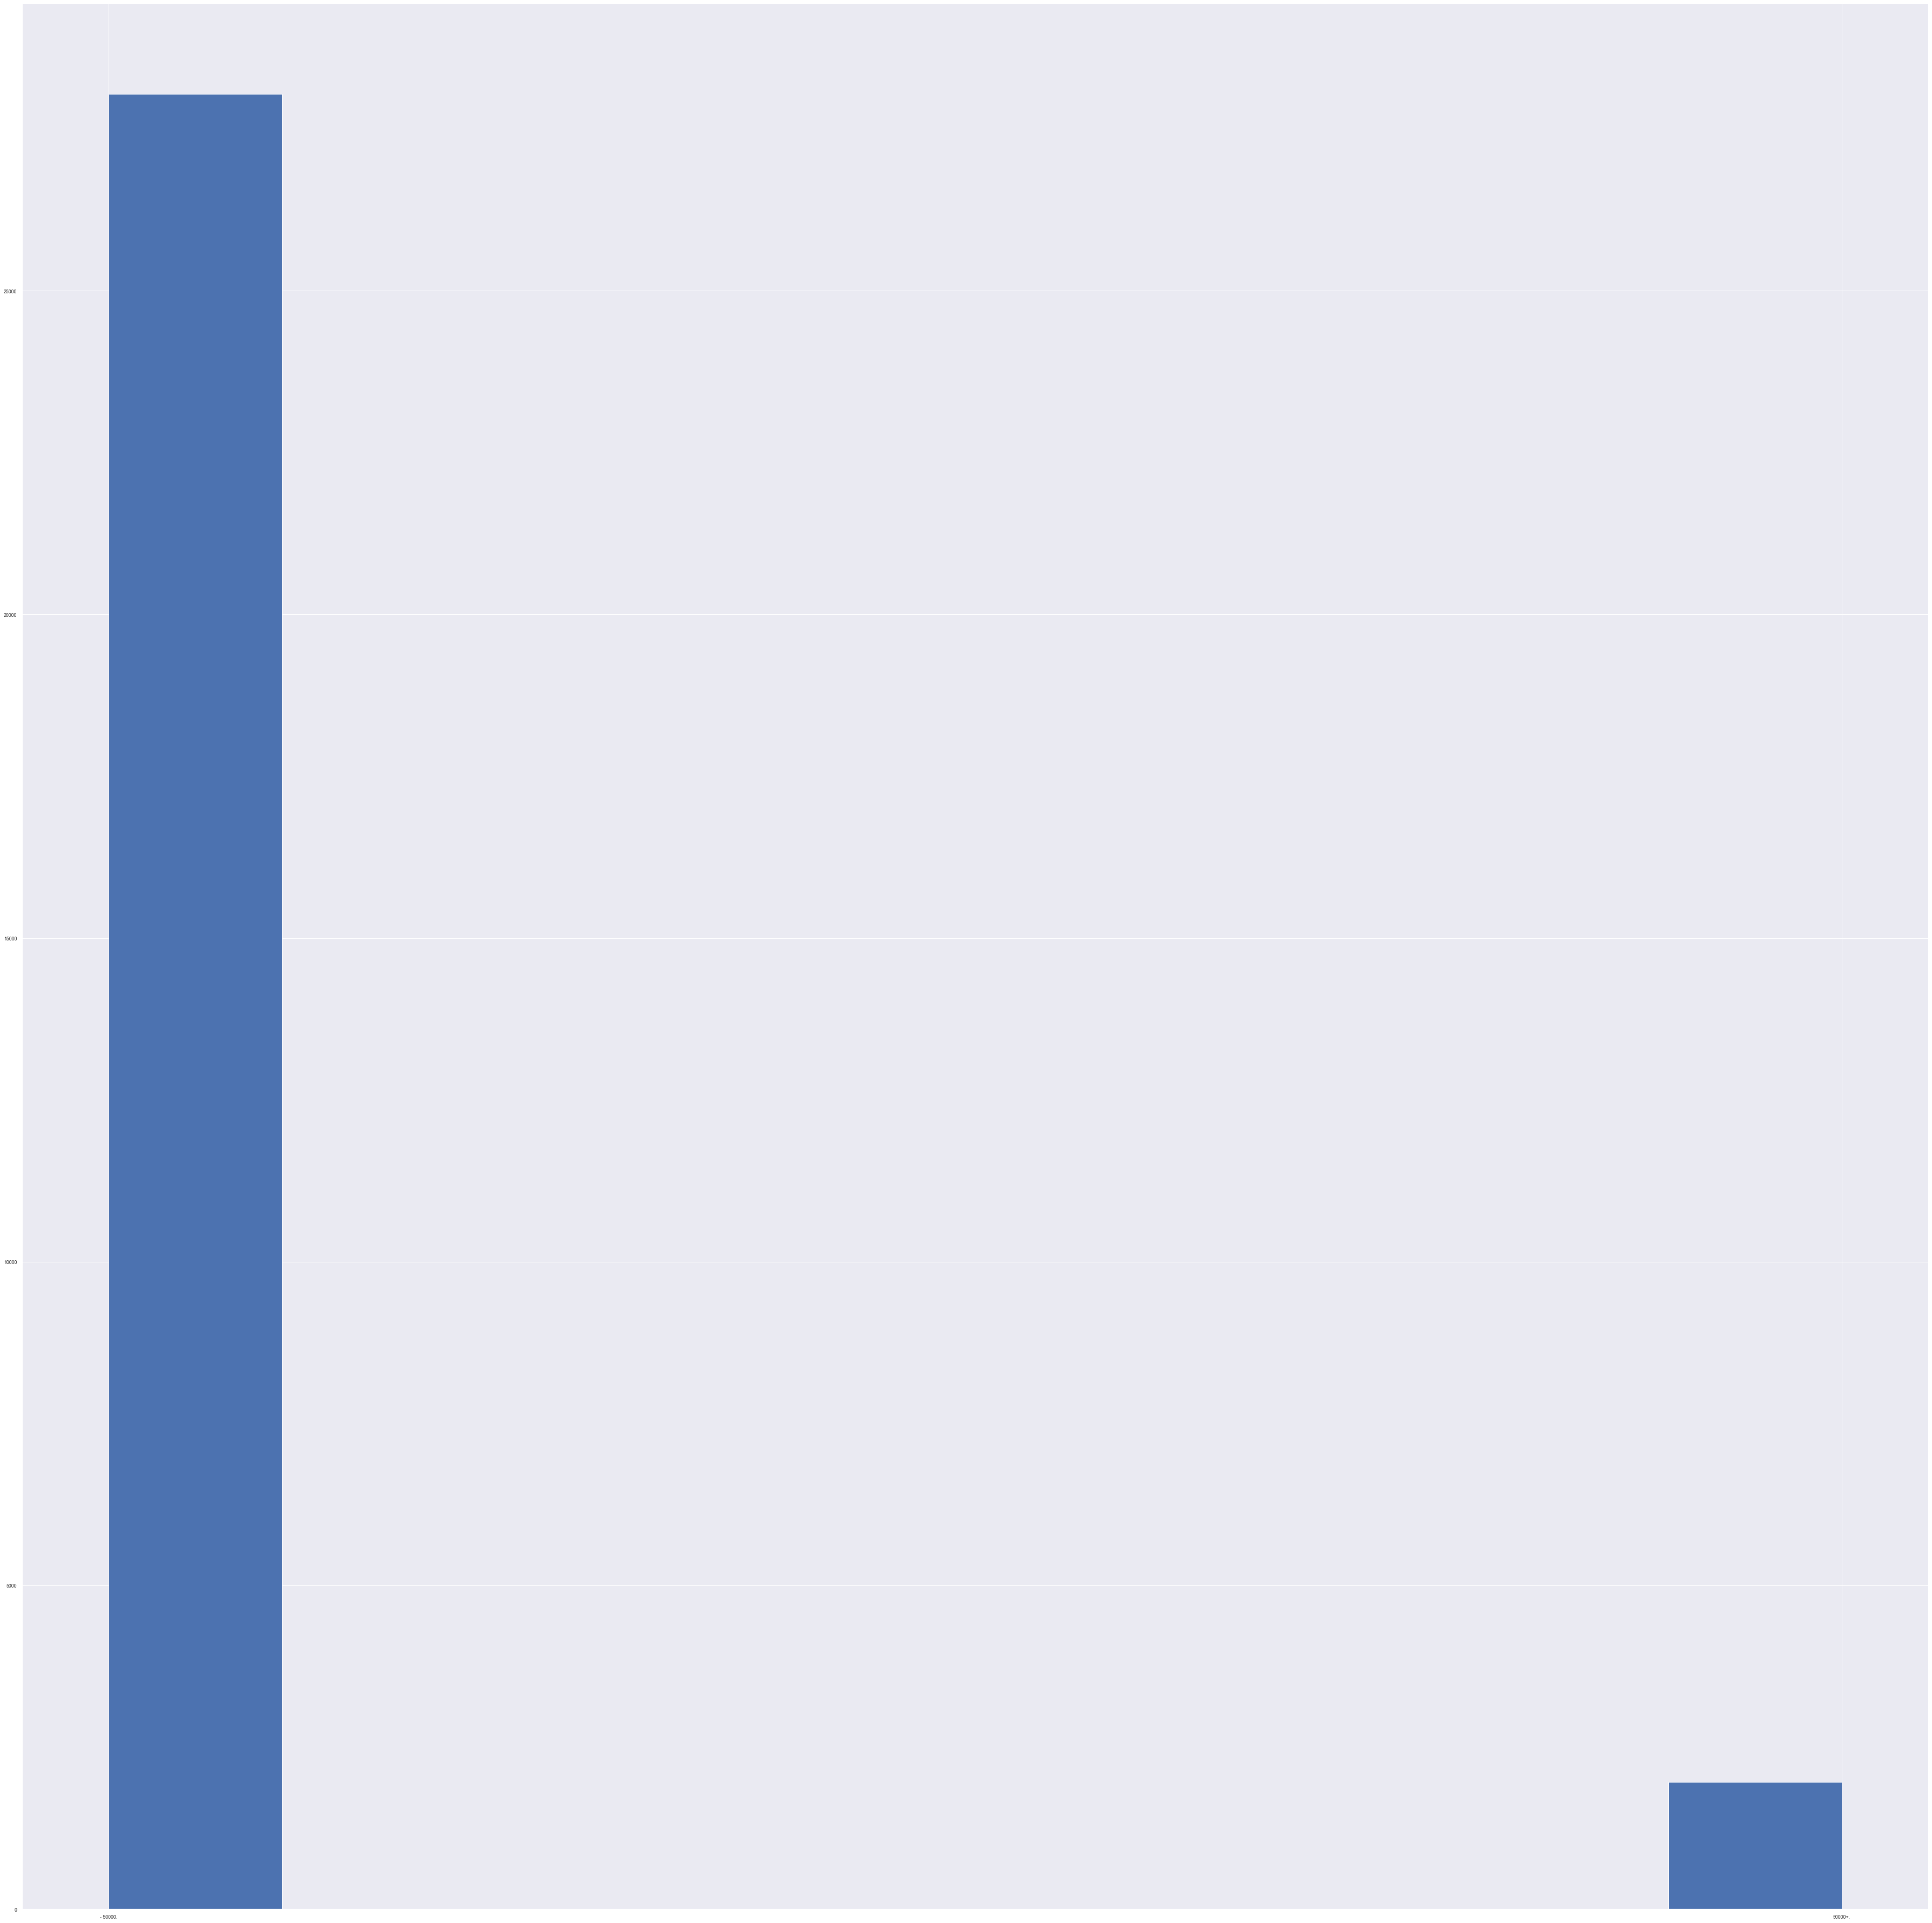

In [368]:
synt_data_cerebras['target'].hist()

In [369]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}% and {100-len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.54% and 93.46%


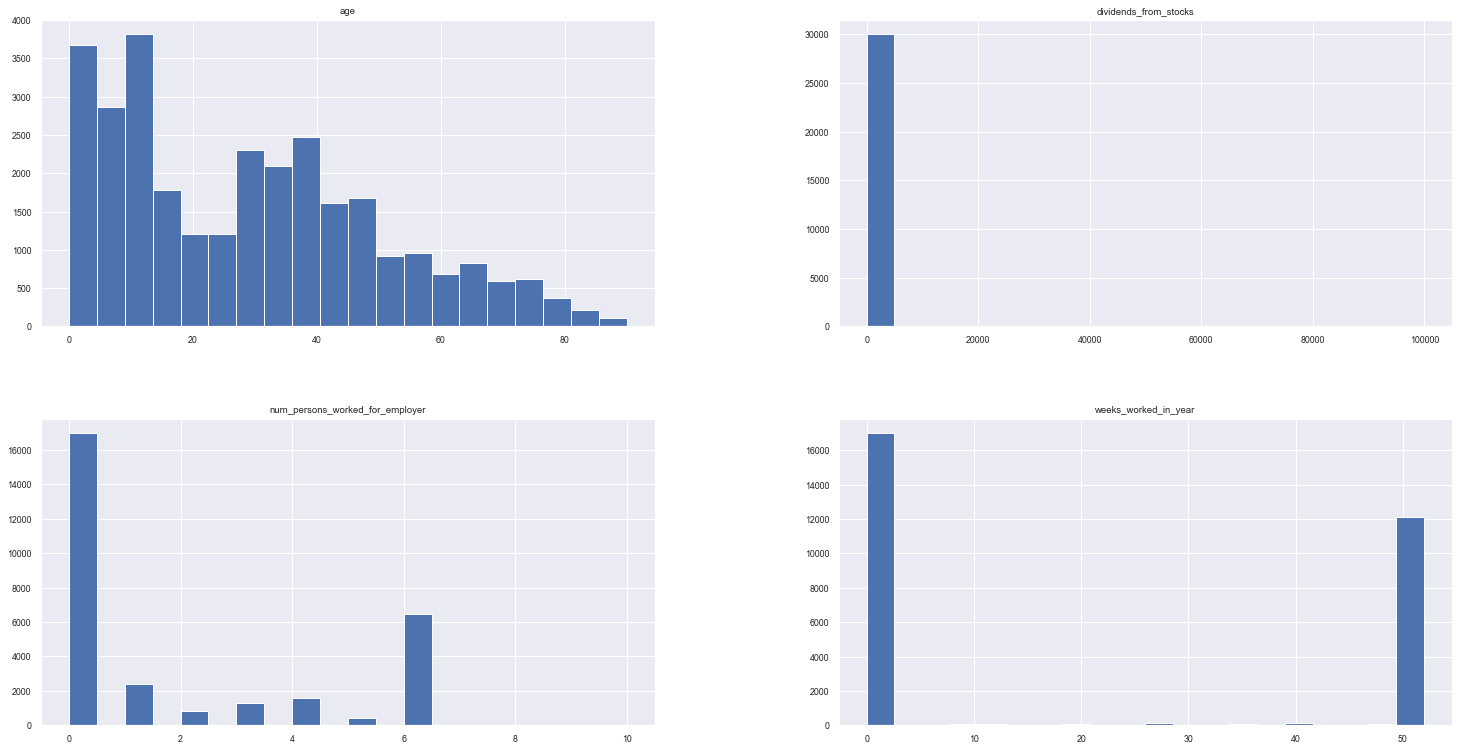

In [370]:
synt_data_cerebras[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

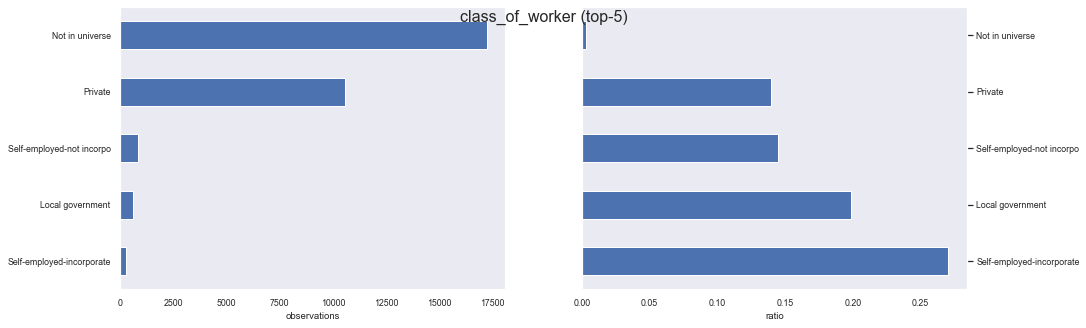

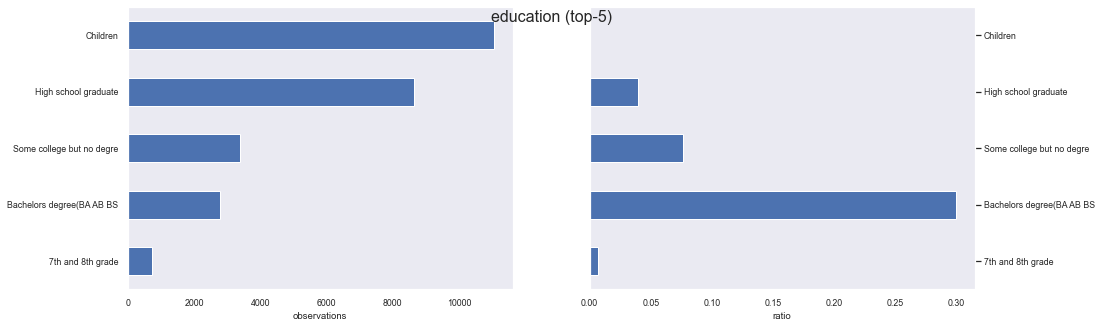

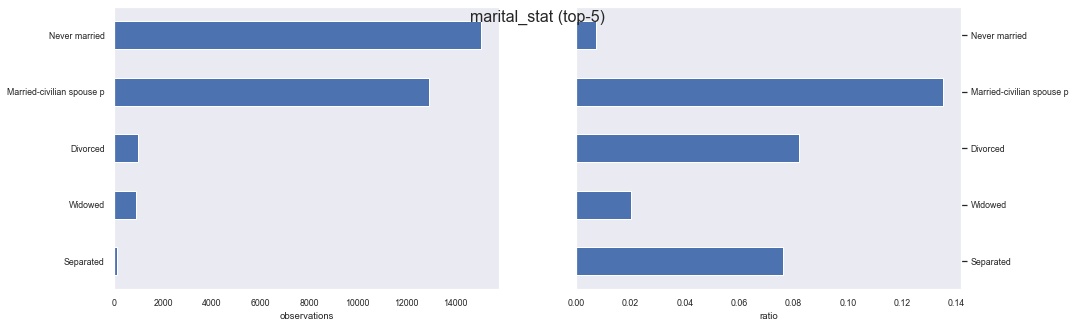

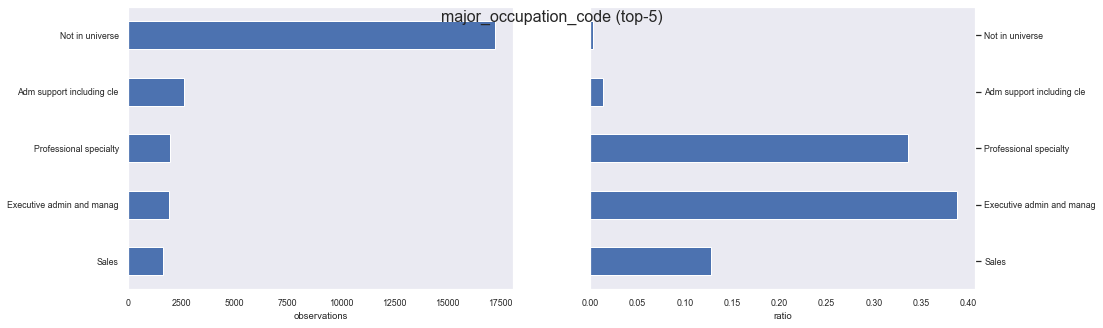

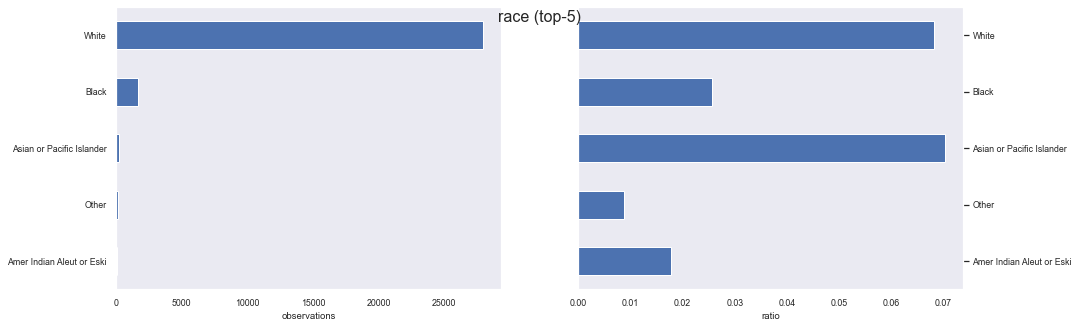

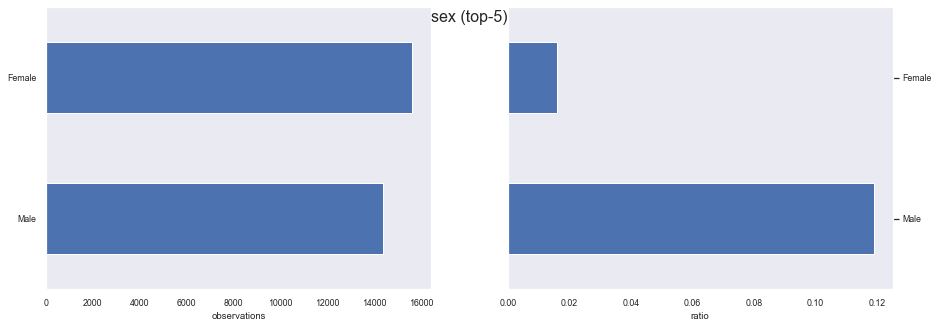

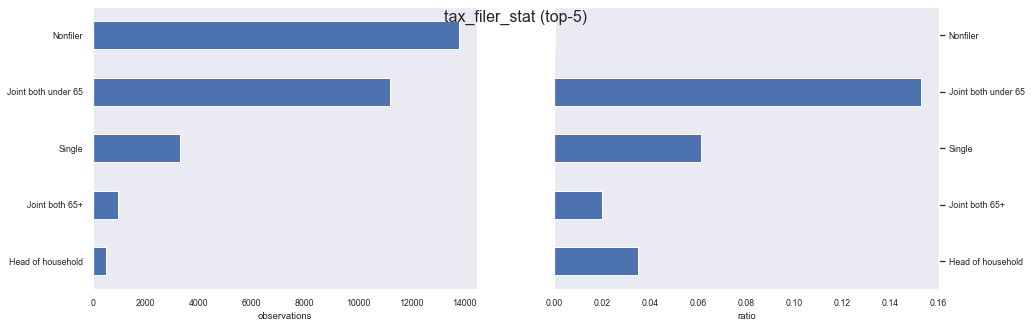

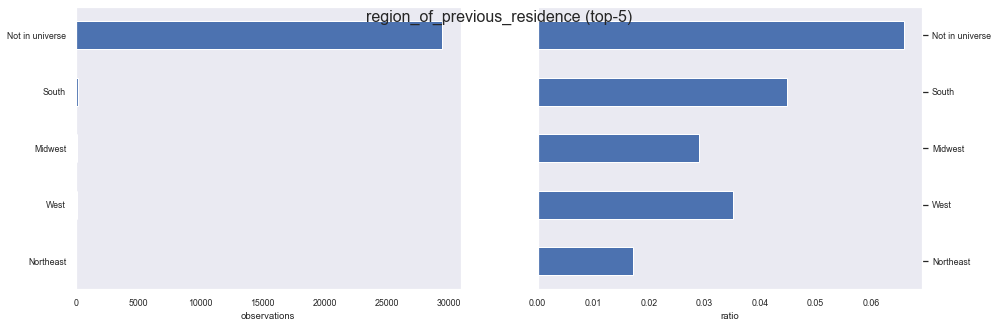

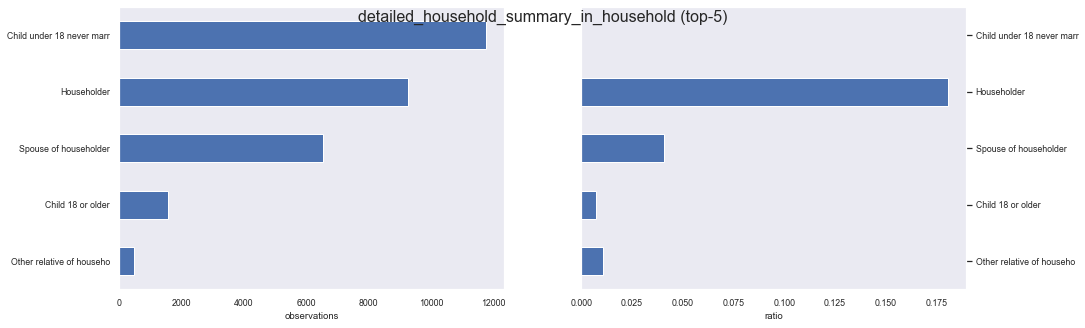

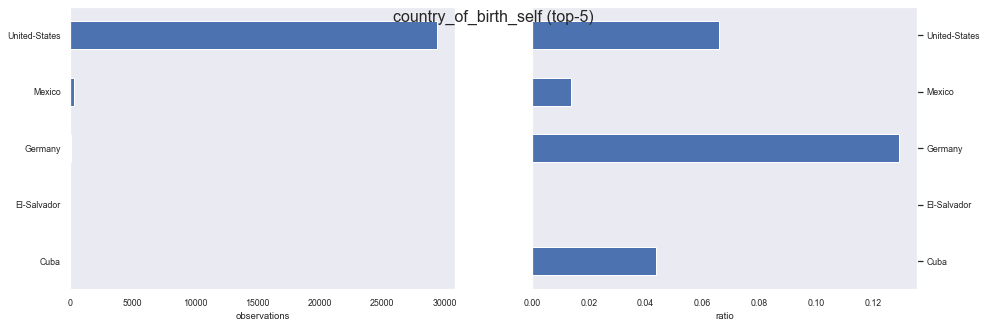

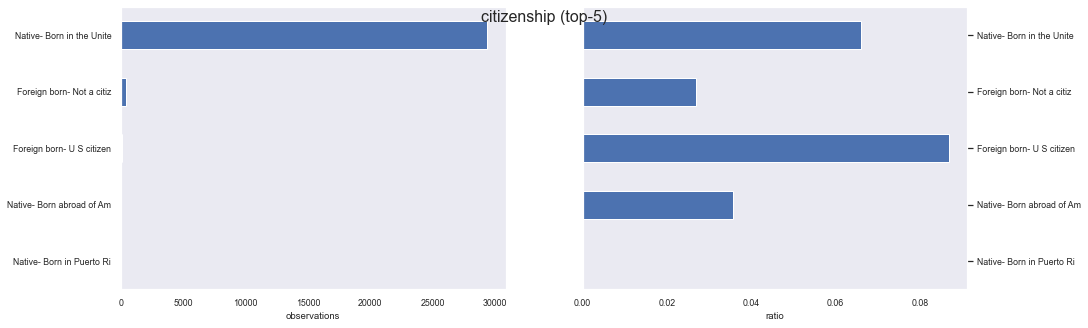

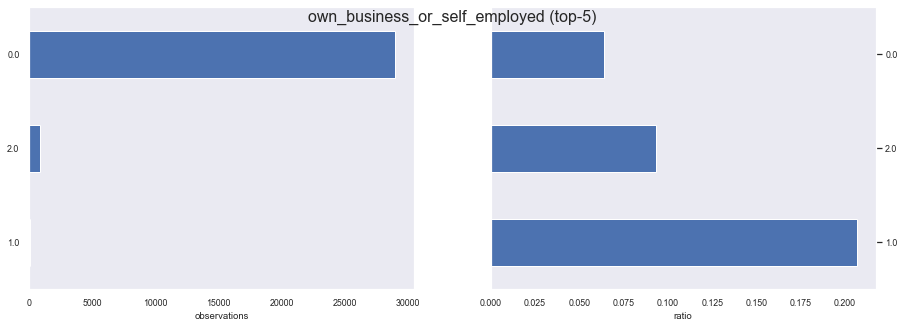

In [371]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_cerebras.drop(['target'], axis=1).assign(cnt=1, target=synt_data_cerebras['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Phi1.5 

In [372]:
synt_data_phi.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      28.972967              21.432367                         1.849333   
std       21.575236             717.993969                         2.475312   
min        0.000000               0.000000                         0.000000   
25%       10.000000               0.000000                         0.000000   
50%       28.000000               0.000000                         0.000000   
75%       43.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                    30000.00000          30000.000000  
mean                         0.06530             22.096967  
std                          0.35153             25.436634  
min                          0.00000              0.000000  
25%                          0.00000              0.000000  
50%                          0.00000              0.000000  
75%                          0.00000             52.000000  
max                          2.00000             52.000000

In [373]:
print(synt_data_phi.isna().sum().sum())

0


In [374]:
synt_data_phi['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

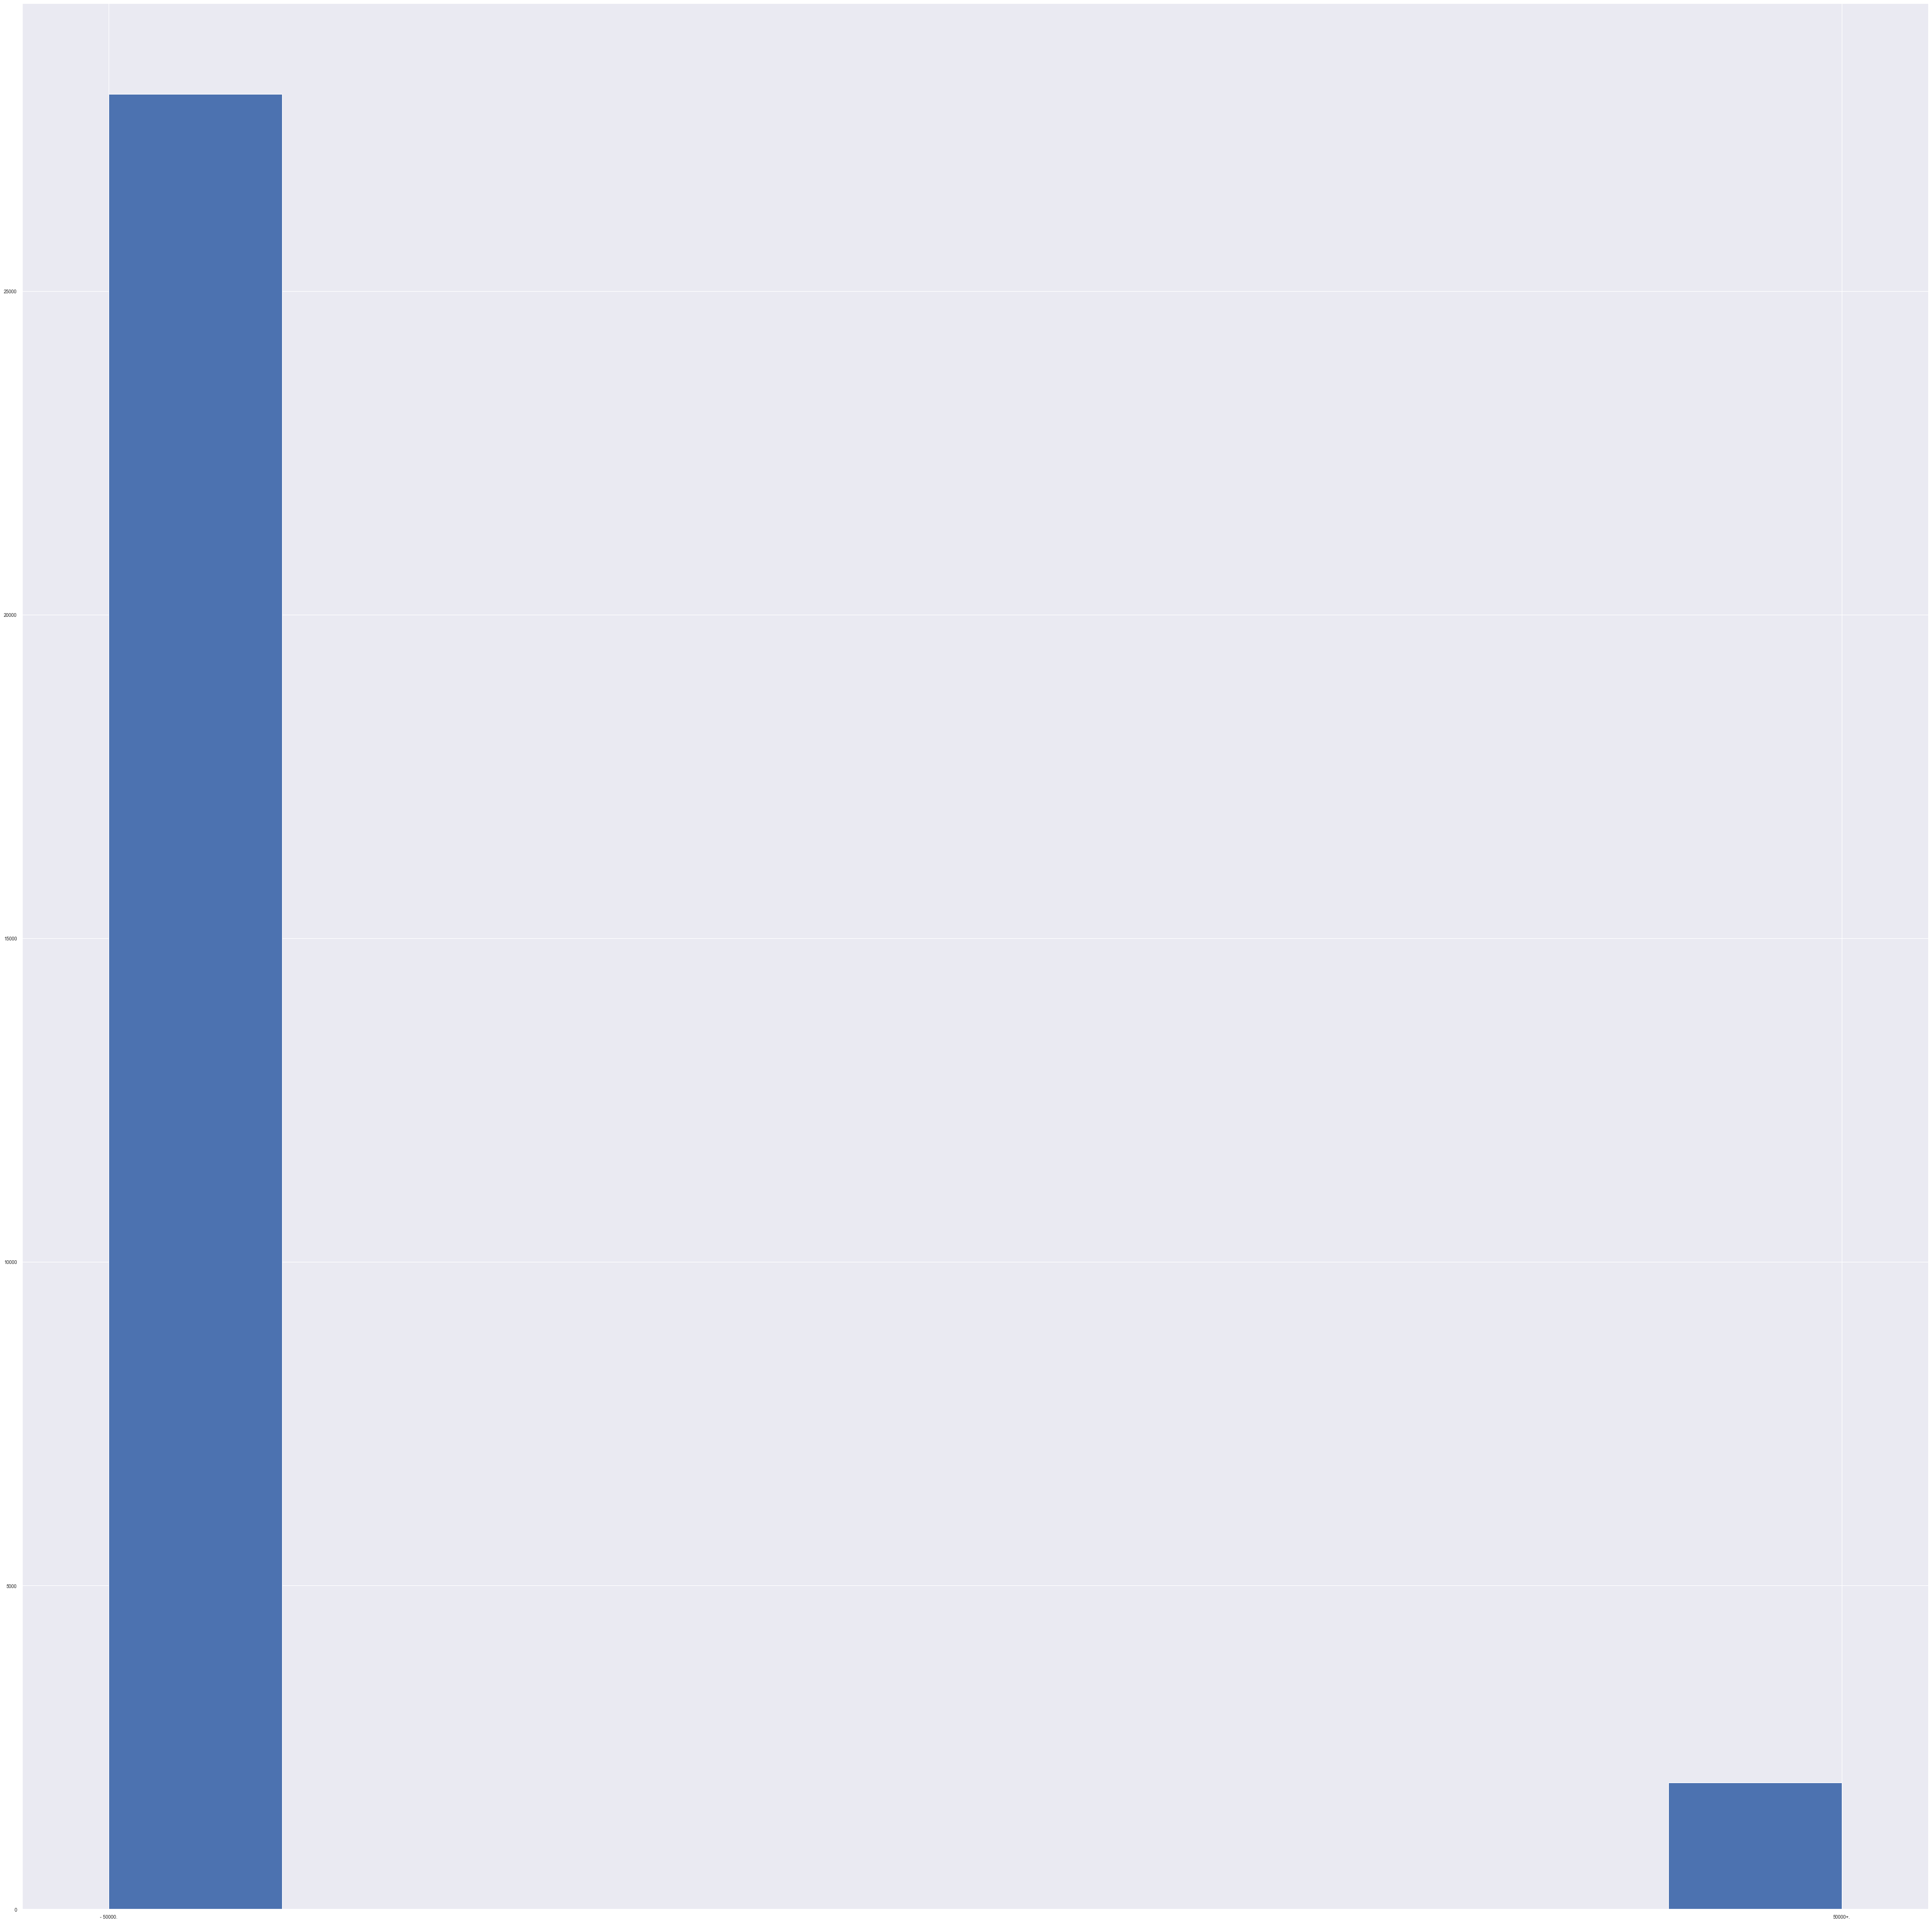

In [375]:
synt_data_phi['target'].hist()

In [376]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}% and {100-len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.53% and 93.47%


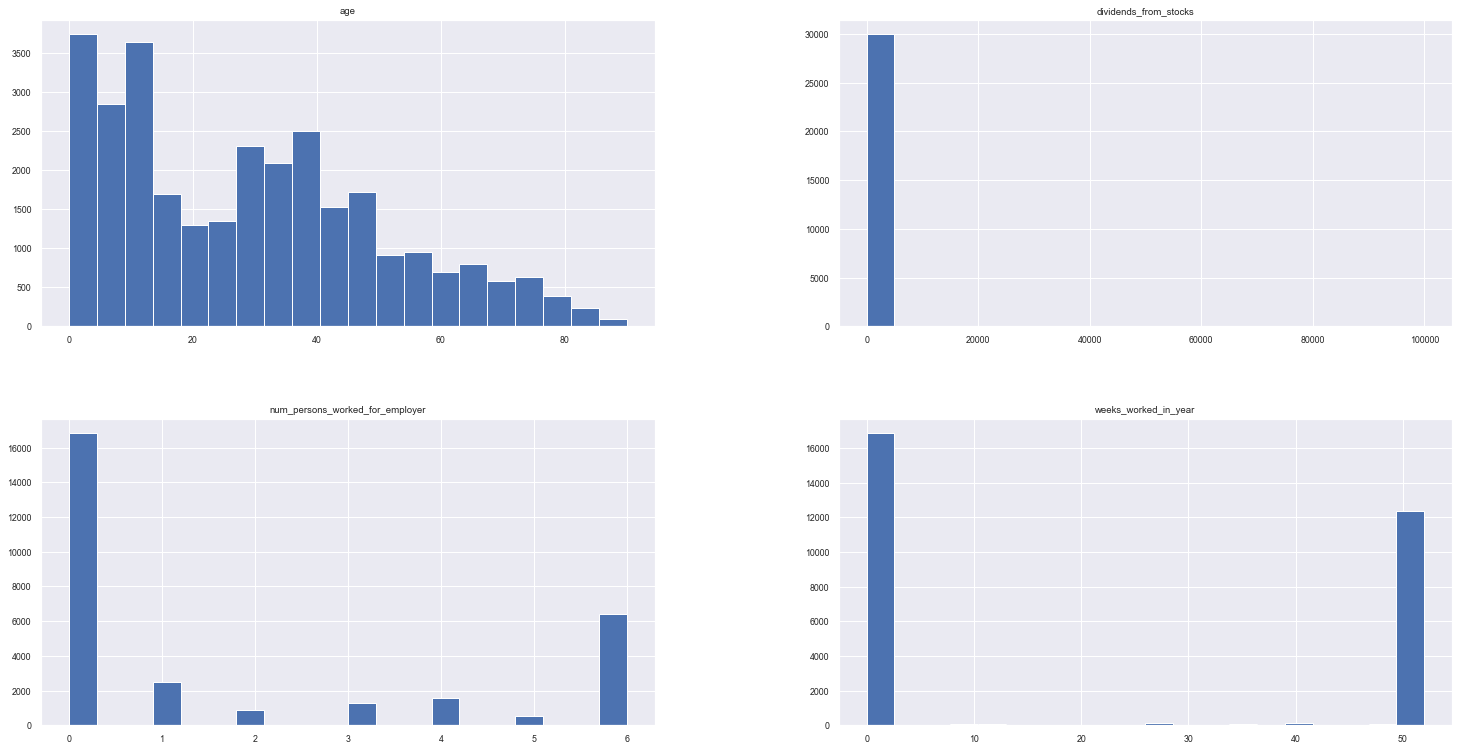

In [377]:
synt_data_phi[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

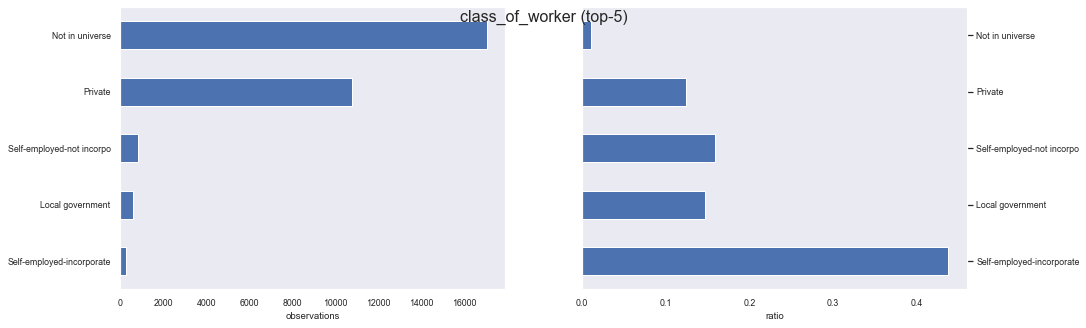

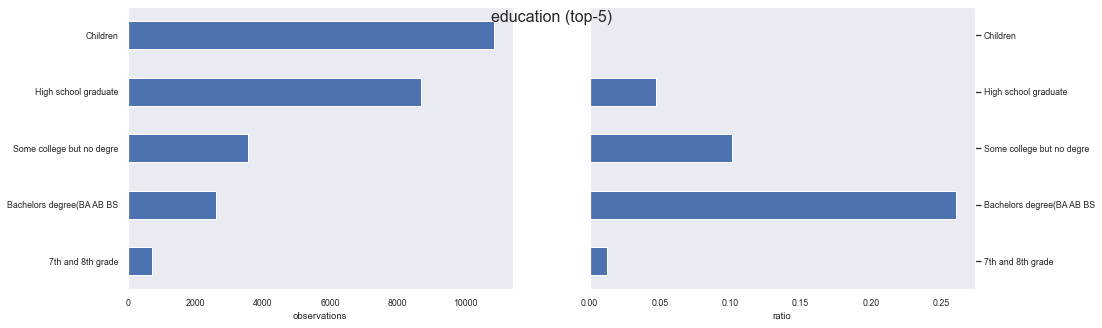

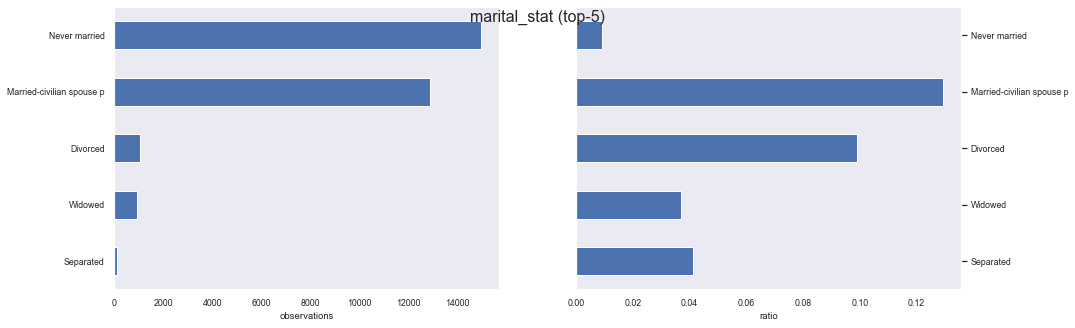

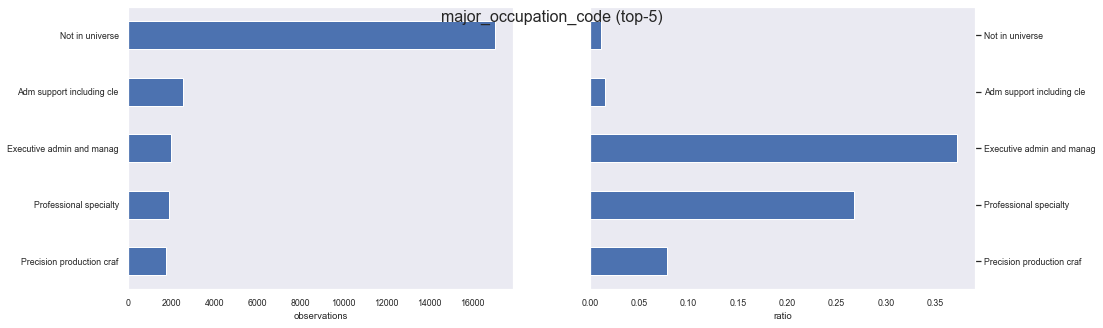

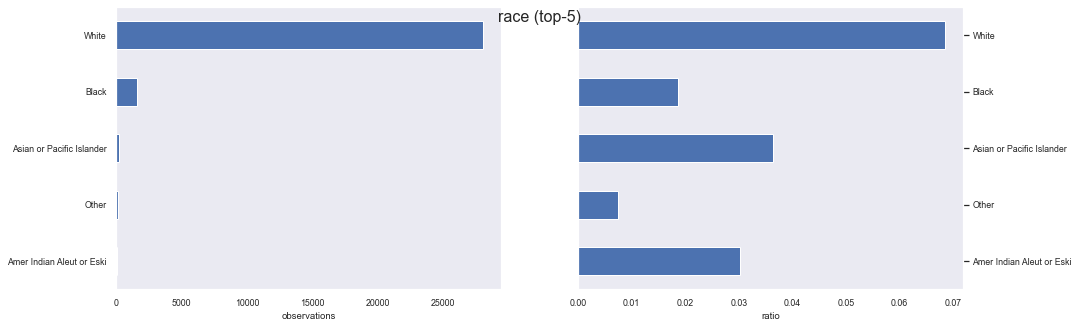

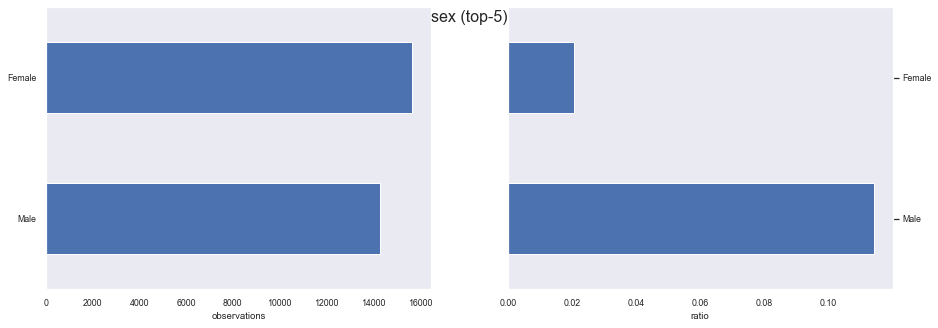

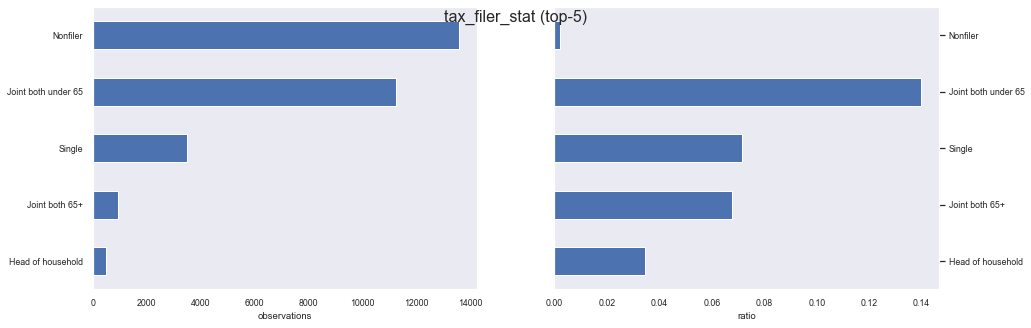

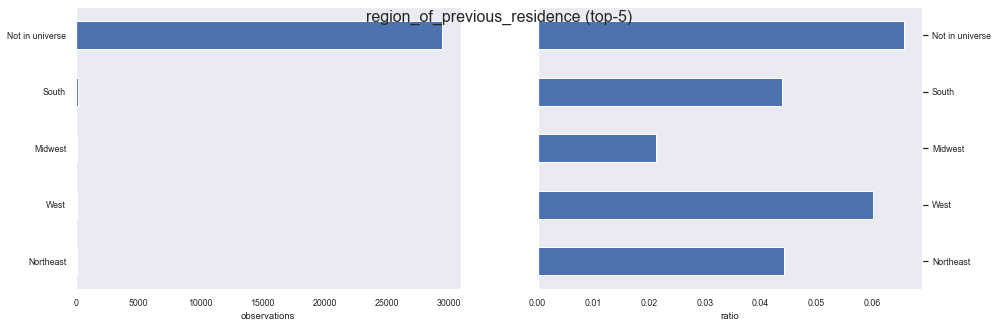

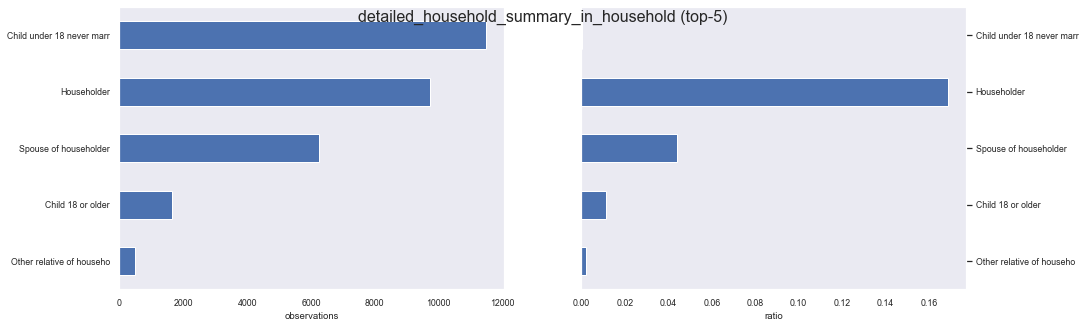

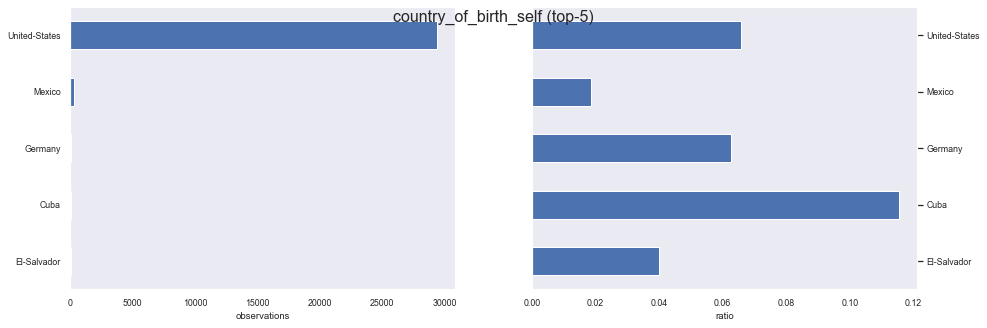

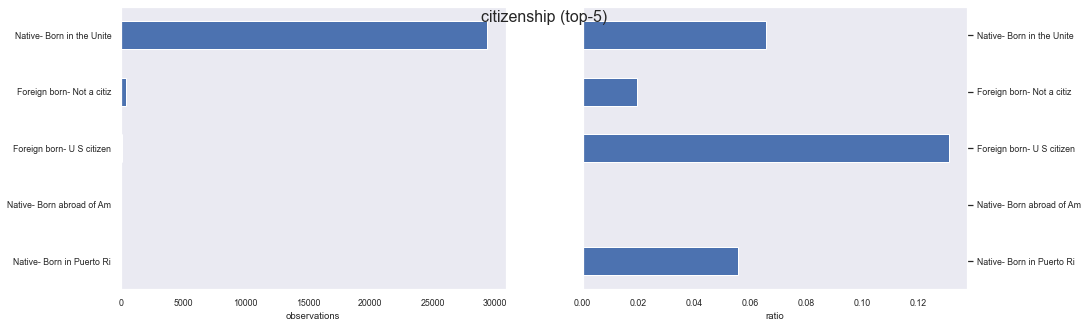

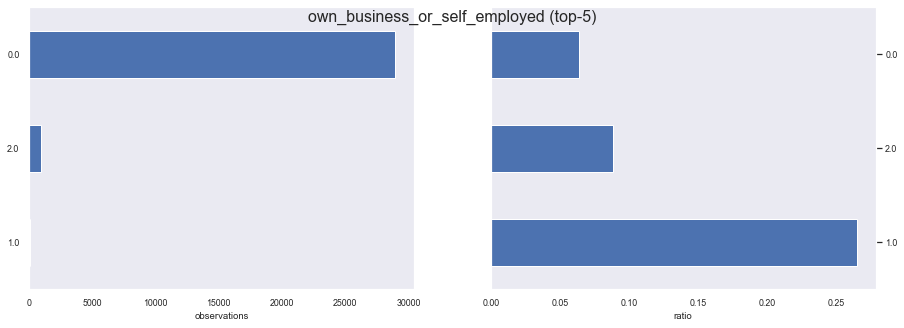

In [378]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_phi.drop(['target'], axis=1).assign(cnt=1, target=synt_data_phi['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Dataset comparsion

In [379]:
synt_datasets = dict()
synt_datasets['distilgpt2'] = synt_data_distilgpt2
synt_datasets['gpt2xl'] = synt_data_gpt2xl
synt_datasets['cerebras'] = synt_data_cerebras
synt_datasets['phi'] = synt_data_phi

In [380]:
cols_compare = dict()
for col in cols:
    cols_compare[col] = {}
    cols_compare[col]['real'] = real_dataset[col].to_numpy()
    for synt in synt_datasets:
        cols_compare[col][synt] = synt_datasets[synt][col].to_numpy()


In [381]:
all_data = list()
for col in cols :
    all_data.append((col,[x for x in [(i,cols_compare[col][i]) for i in cols_compare[col]]]))

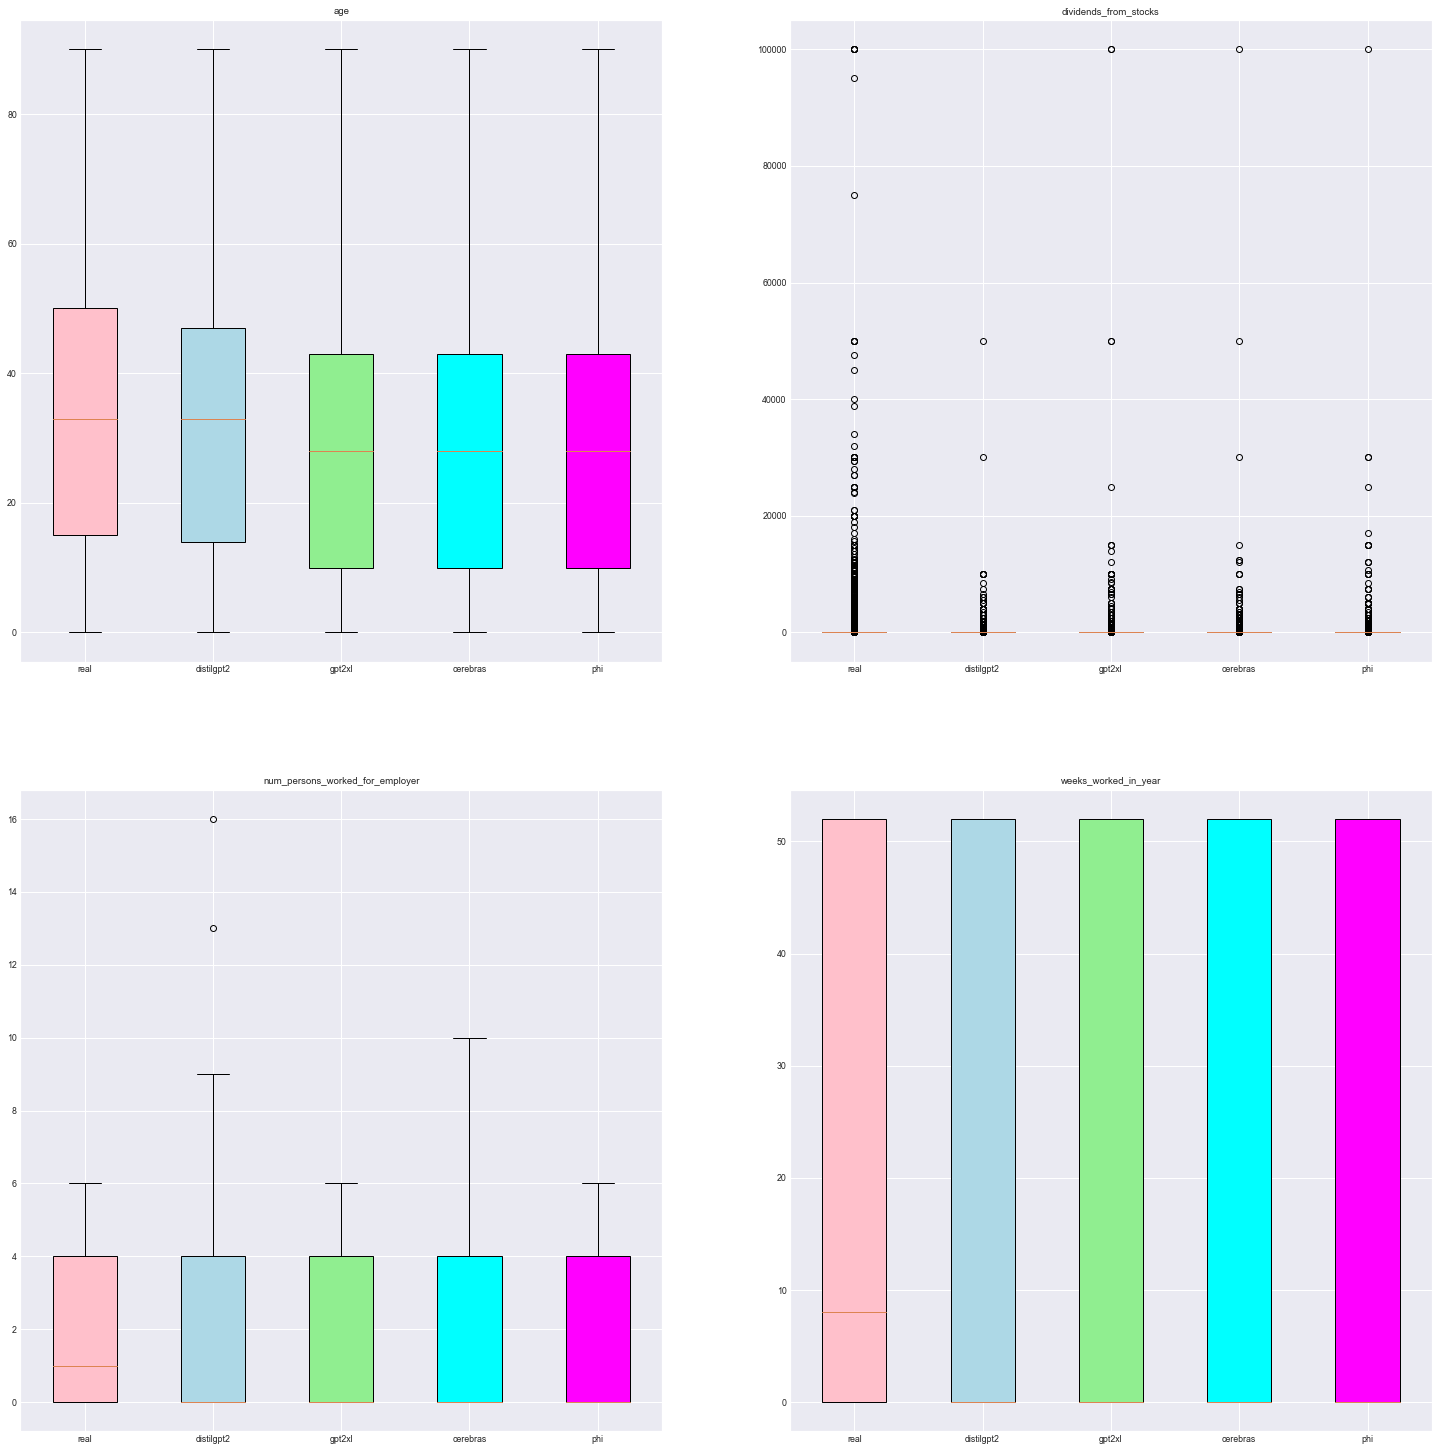

In [382]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
ncols=2
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
bplots = list()

i=0
for _, col in enumerate(all_data) :
    col_name = col[0]
    if not(col_name in numeric):
        continue
    col_data = col[1]
    rw = i//ncols
    cl = i%ncols
    i+=1
    axs[rw,cl].set_title(col_name)
     
    bplots.append(axs[rw,cl].boxplot([x[1] for x in col_data],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=[x[0] for x in col_data]))  # will be used to label x-ticks
           
#fill with colors
colors = ['pink', 'lightblue', 'lightgreen','cyan','magenta','yellow',]
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

# Binary classification task on rough data

## General data preprocessing

In [383]:
to_encode = [i for i in categs]

In [384]:
to_encode

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [385]:
target_encoder= {' 50000+.': 1, 
                ' - 50000.': 0,
                '50000+.': 1, 
                '- 50000.': 0} 

In [386]:
edu_encoder= {' Children': 1, 
            ' Less than 1st grade': 2, 
            ' 1st 2nd 3rd or 4th grade': 3, 
            ' 5th or 6th grade': 4,
            ' 7th and 8th grade': 5, 
            ' 9th grade': 6, 
            ' 10th grade': 7, 
            ' 11th grade': 8 , 
            ' 12th grade no diploma': 9,
            ' High school graduate': 10, 
            ' Some college but no degree': 11, 
            ' Associates degree-occup /vocational': 12,
            ' Associates degree-academic program': 13, 
            ' Bachelors degree(BA AB BS)' : 14,
            ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
            ' Doctorate degree(PhD EdD)': 16,
            ' Prof school degree (MD DDS DVM LLB JD)': 17,
            'Children': 1, 
            'Less than 1st grade': 2, 
            '1st 2nd 3rd or 4th grade': 3, 
            '5th or 6th grade': 4,
            '7th and 8th grade': 5, 
            '9th grade': 6, 
            '10th grade': 7, 
            '11th grade': 8 , 
            '12th grade no diploma': 9,
            'High school graduate': 10, 
            'Some college but no degree': 11, 
            'Associates degree-occup /vocational': 12,
            'Associates degree-academic program': 13, 
            'Bachelors degree(BA AB BS)' : 14,
            'Masters degree(MA MS MEng MEd MSW MBA)': 15,
            'Doctorate degree(PhD EdD)': 16,
            'Prof school degree (MD DDS DVM LLB JD)': 17}
to_encode.remove('education')

## Real data preprocessing and classification modeling

### Data preprocessing

In [387]:
real_data = real_dataset.copy()

In [388]:
X_tr, X_te, y_tr, y_te = train_test_split(real_data.drop(columns = ['target']),real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [389]:
X_te_real_validate = X_te.copy()
y_te_real_validate = y_te.copy()

In [390]:
print(real_data['target'].unique(), len(real_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [391]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)

In [392]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [393]:
print(real_data['education'].unique(), len(real_data['education'].unique()))

['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)'] 17


In [394]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)

In [395]:
print(X_tr['education'].unique(), len(X_tr['education'].unique()))

[ 5 11  1 15 10 14  9 12  6  2 13  7  3  8  4 17 16] 17


In [396]:
to_encode_real = to_encode.copy() 

In [397]:
# mean target encoding
for i in to_encode_real.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes[x])
        to_encode_real.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ citizenship
+ own_business_or_self_employed


In [398]:
#frequency encoding 
for i in to_encode_real.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    to_encode_real.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self


In [399]:
to_encode_real

[]

In [400]:
print(X_tr.isna().sum().sum())
print(X_te.isna().sum().sum())

0
0


In [401]:
X_tr.dtypes

age                                          int64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                        int64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer              int64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                         int64
dtype: object

### Features selection

In [402]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.273832   0.554347   
class_of_worker                         -0.273832         1.000000  -0.586404   
education                                0.554347        -0.586404   1.000000   
marital_stat                             0.680123        -0.380808   0.535738   
major_occupation_code                   -0.235530         0.860999  -0.485680   
race                                     0.068959        -0.053021   0.100718   
sex                                     -0.038577        -0.094046   0.005064   
dividends_from_stocks                    0.256355        -0.134686   0.309286   
tax_filer_stat                           0.471370        -0.632230   0.660937   
region_of_previous_residence             0.090736         0.014371   0.001013   
detailed_household_summary_in_household  0.252836        -0.083663   0.108197   
num_persons_worked_for_employer          0.245655        -0.764200   0.587607   
country_of_birth_self                   -0.072291         0.035267  -0.025496   
citizenship                              0.046291        -0.014168   0.065853   
own_business_or_self_employed            0.030568        -0.269053   0.216898   
weeks_worked_in_year                     0.286815        -0.835988   0.604476   
target                                   0.169496        -0.241753   0.304604   

                                         marital_stat  major_occupation_code  \
age                                          0.680123              -0.235530   
class_of_worker                             -0.380808               0.860999   
education                                    0.535738              -0.485680   
marital_stat                                 1.000000              -0.337805   
major_occupation_code                       -0.337805               1.000000   
race                                         0.109519              -0.045462   
sex                                         -0.007314              -0.175800   
dividends_from_stocks                        0.230006              -0.079366   
tax_filer_stat                               0.760664              -0.601035   
region_of_previous_residence                 0.049349               0.022531   
detailed_household_summary_in_household      0.178682              -0.087470   
num_persons_worked_for_employer              0.359423              -0.736346   
country_of_birth_self                       -0.078488               0.064963   
citizenship                                  0.017042               0.017550   
own_business_or_self_employed                0.084303              -0.258446   
weeks_worked_in_year                         0.413837              -0.807133   
target                                       0.200576              -0.180488   

                                             race       sex  \
age                                      0.068959 -0.038577   
class_of_worker                         -0.053021 -0.094046   
education                                0.100718  0.005064   
marital_stat                             0.109519 -0.007314   
major_occupation_code                   -0.045462 -0.175800   
race                                     1.000000  0.022378   
sex                                      0.022378  1.000000   
dividends_from_stocks                    0.081465  0.031495   
tax_filer_stat                           0.114606  0.037119   
region_of_previous_residence             0.022446  0.001121   
detailed_household_summary_in_household  0.012262  0.242139   
num_persons_worked_for_employer          0.036247  0.072372   
country_of_birth_self                   -0.120298  0.014380   
citizenship                              0.001725  0.010086   
own_business_or_self_employed            0.030773  0.036088   
weeks_worked_in_year                     0.062989  0.110199   
target                                   0.056979  0.168318   

           

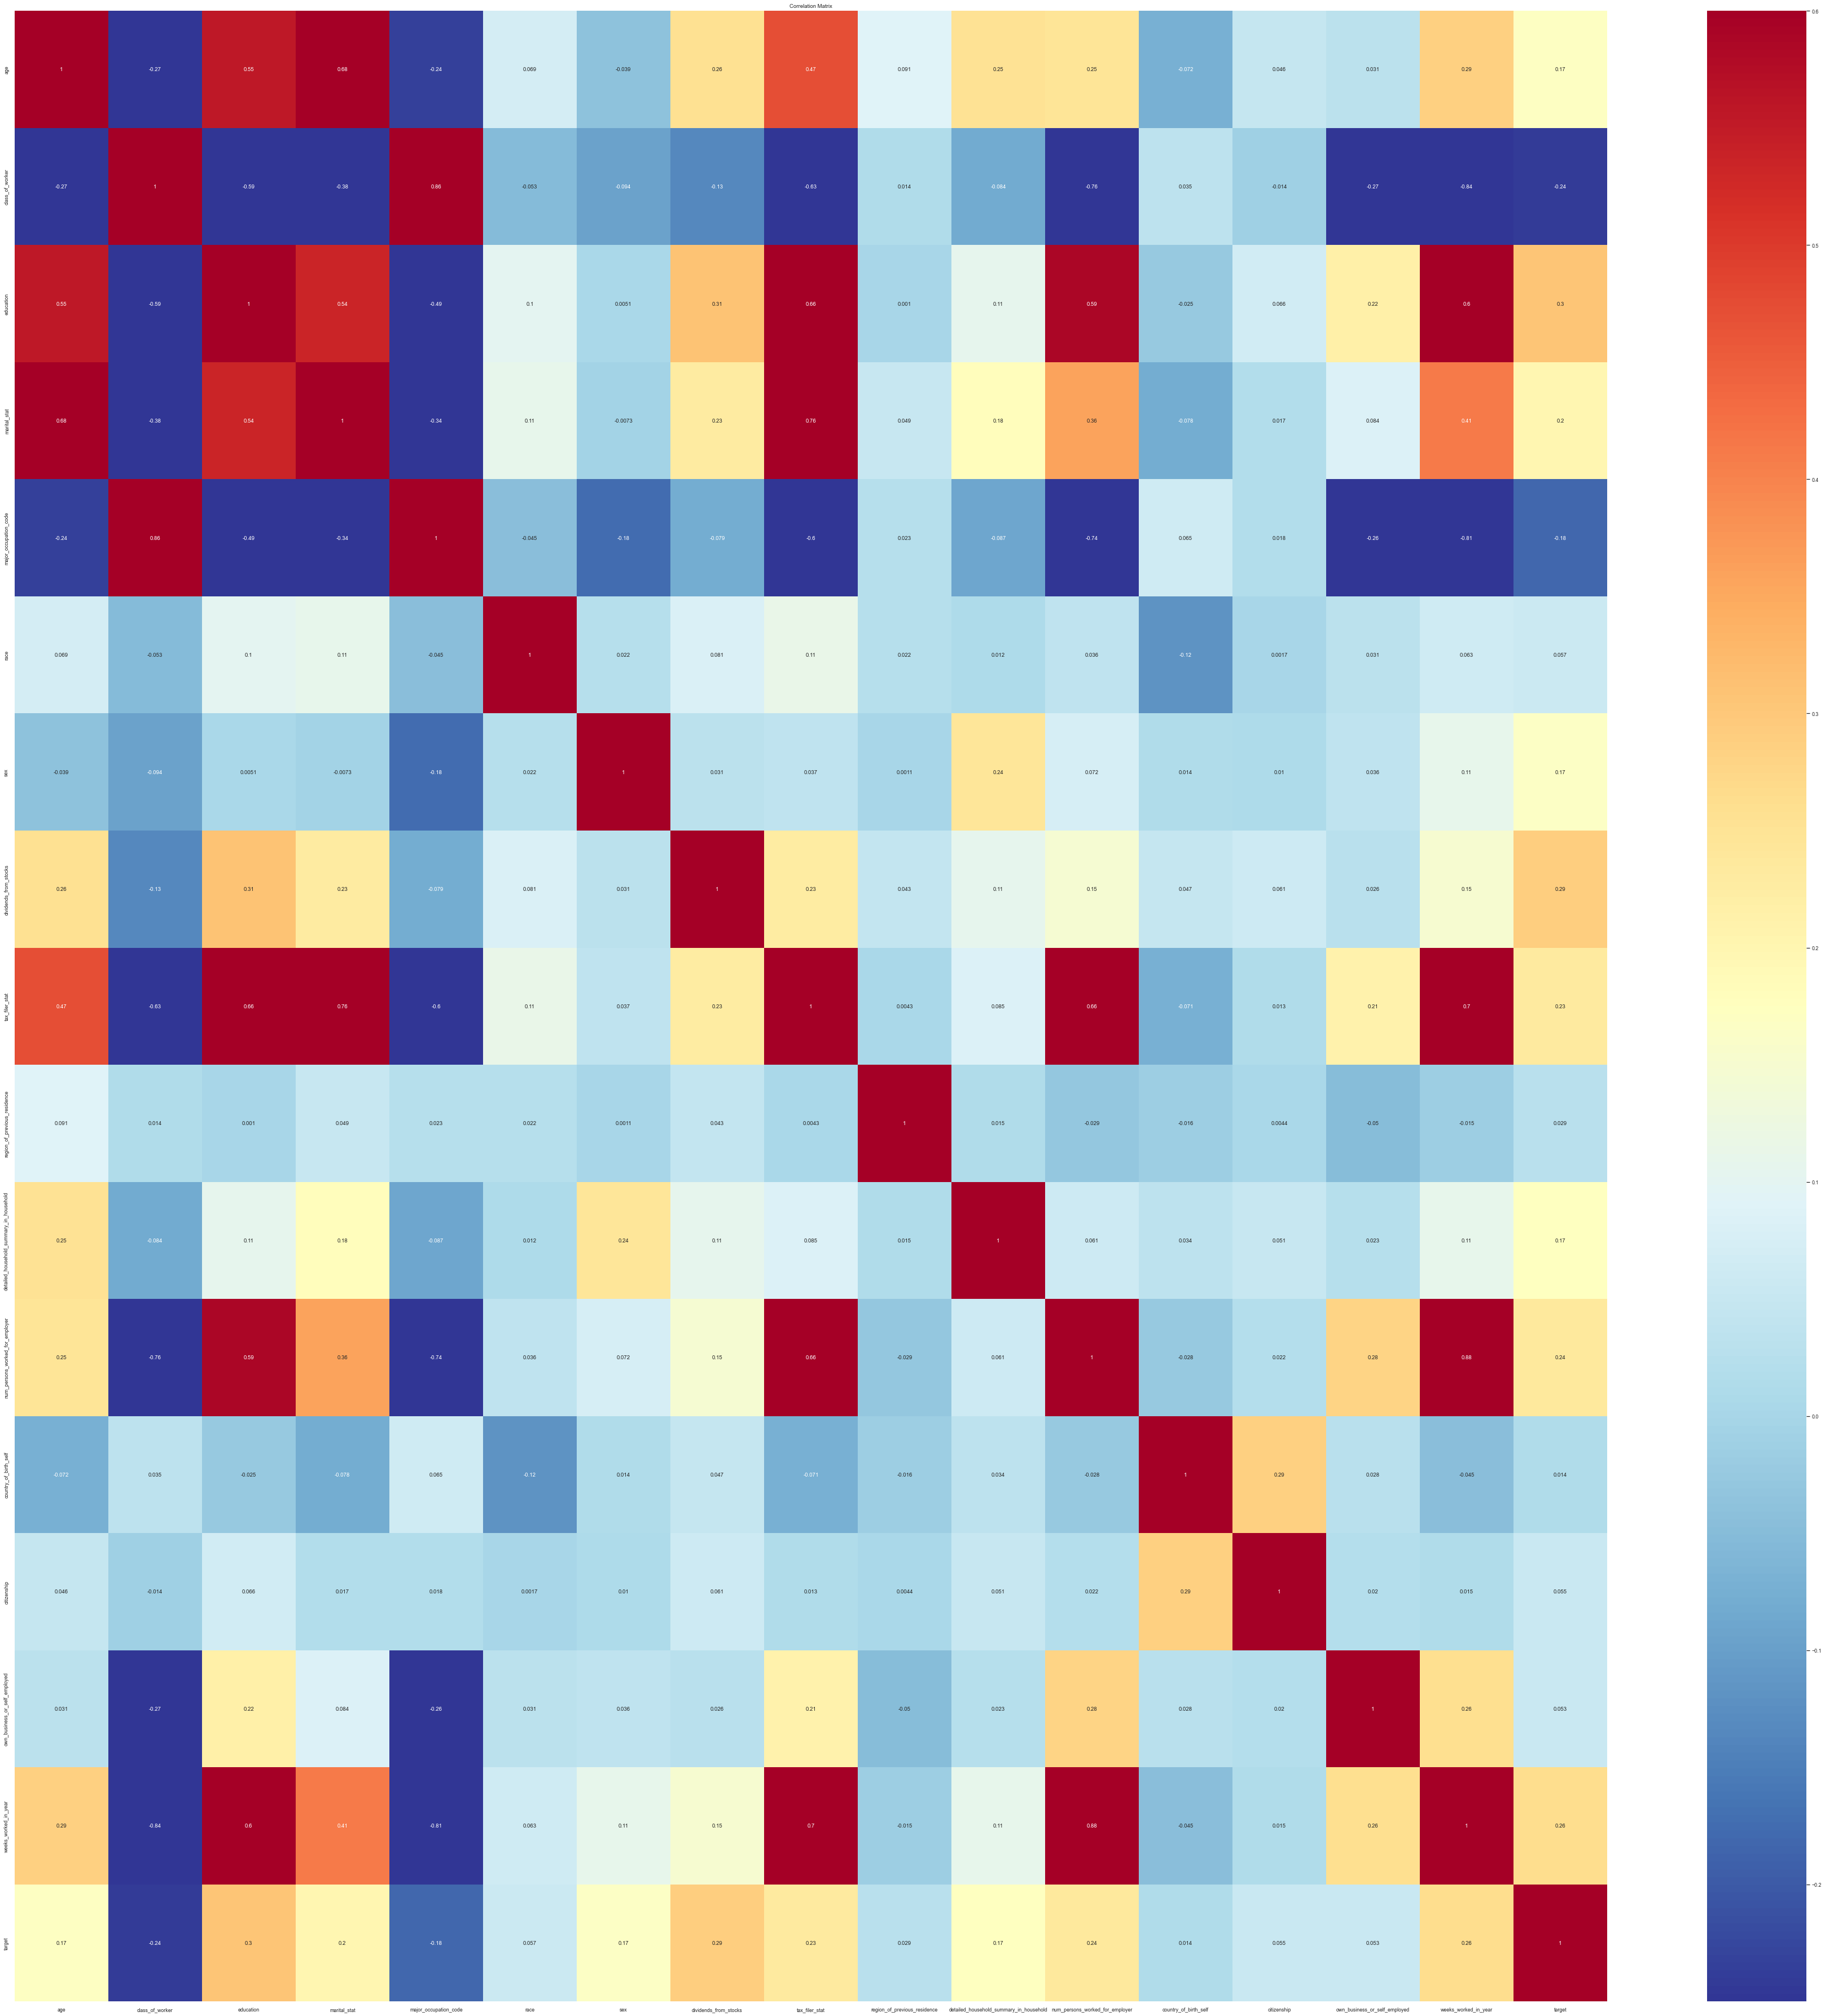

In [403]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [404]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 3
The number of features remaining: 13


In [405]:
del_features

array(['class_of_worker', 'major_occupation_code',
       'num_persons_worked_for_employer'], dtype='<U31')

In [406]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 13


In [407]:
real_model_features = count_features.copy()
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic Regression

In [408]:
#X_tr, X_te_real, y_tr, y_te_real = train_test_split(real_data[count_features],real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [409]:
X_tr = X_tr[count_features]
X_te = X_te[count_features]

In [410]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr, y_tr)

CPU times: total: 188 ms
Wall time: 210 ms


In [411]:
log_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR', LogisticRegression())
])

log_parameters = {
    'LR__solver': ['saga'],
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}


In [412]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.838 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.830 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.839 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.825 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.848 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.840 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.835 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.852 total time=   0.1s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [413]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8464060619430963
LogisticRegression(C=0.1, solver='saga')


In [414]:
y_pred_test = grid_pipe_log.best_estimator_.predict(X_te)

In [415]:
model_results = pd.DataFrame(columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test = pd.DataFrame([['LogRegression Real data','Real test',
                        balanced_accuracy_score(y_te, y_pred_test),
                        recall_score(y_te, y_pred_test),
                        precision_score(y_te, y_pred_test),
                        roc_auc_score(y_te, y_pred_test)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\616206078.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, res_test],axis=0)


In [416]:
res_test

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

In [417]:
model_results

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

## DistillGPT2 classification

### Data preprocessing 

In [418]:
synt_data = synt_data_distilgpt2.copy()

In [419]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [420]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [421]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [422]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [423]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [424]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Some college but no degree' 'High school graduate' 'Children'
 '11th grade' 'Bachelors degree(BA AB BS)'
 'Associates degree-academic program' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)' '7th and 8th grade'
 '5th or 6th grade' 'Associates degree-occup /vocational' '9th grade'
 'Prof school degree (MD DDS DVM LLB JD)' '12th grade no diploma'
 'Doctorate degree(PhD EdD)' 'Less than 1st grade' '1st 2nd or 4th grade'
 '1st 2nd 3rd or 4th grade' '9th grade no diploma'
 'Prof school degree (MD DDS DVM LLB JD LLB JD)' '14th grade no diploma'
 '50000+.' '4th or 5th grade' '8th and 8th grade' '12 or older'
 'State government' '15th or older' '15th and 8th grade'
 '6th and 8th grade' '20 or older' 'Masters degree(BA AB BS)'
 'Not in universe' '2nd 3rd or 4th grade' '18 or older'] 34


In [425]:
for edu in synt_data['education'].unique():
    if edu in edu_encoder.keys() :
        continue
    else :
        edu_encoder[edu] = 0
        print (edu)
edu_encoder

1st 2nd or 4th grade
9th grade no diploma
Prof school degree (MD DDS DVM LLB JD LLB JD)
14th grade no diploma
50000+.
4th or 5th grade
8th and 8th grade
12 or older
State government
15th or older
15th and 8th grade
6th and 8th grade
20 or older
Masters degree(BA AB BS)
Not in universe
2nd 3rd or 4th grade
18 or older


{' Children': 1,
 ' Less than 1st grade': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' 10th grade': 7,
 ' 11th grade': 8,
 ' 12th grade no diploma': 9,
 ' High school graduate': 10,
 ' Some college but no degree': 11,
 ' Associates degree-occup /vocational': 12,
 ' Associates degree-academic program': 13,
 ' Bachelors degree(BA AB BS)': 14,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
 ' Doctorate degree(PhD EdD)': 16,
 ' Prof school degree (MD DDS DVM LLB JD)': 17,
 'Children': 1,
 'Less than 1st grade': 2,
 '1st 2nd 3rd or 4th grade': 3,
 '5th or 6th grade': 4,
 '7th and 8th grade': 5,
 '9th grade': 6,
 '10th grade': 7,
 '11th grade': 8,
 '12th grade no diploma': 9,
 'High school graduate': 10,
 'Some college but no degree': 11,
 'Associates degree-occup /vocational': 12,
 'Associates degree-academic program': 13,
 'Bachelors degree(BA AB BS)': 14,
 'Masters degree(MA MS MEng MEd MSW MBA)': 15,
 'Doctorate degree(PhD E

In [426]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [427]:
to_encode_synt = to_encode.copy() 

In [428]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ own_business_or_self_employed


In [429]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship


In [430]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [431]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [432]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.263520   0.585941   
class_of_worker                         -0.263520         1.000000  -0.579203   
education                                0.585941        -0.579203   1.000000   
marital_stat                             0.424828        -0.350907   0.446502   
major_occupation_code                   -0.237683         0.914405  -0.521423   
race                                     0.067439        -0.041157   0.058096   
sex                                      0.032438         0.060524  -0.014150   
dividends_from_stocks                    0.077501        -0.059857   0.088531   
tax_filer_stat                           0.147248        -0.310973   0.266609   
region_of_previous_residence             0.039099         0.008249   0.007967   
detailed_household_summary_in_household  0.235581        -0.091118   0.109133   
num_persons_worked_for_employer          0.249011        -0.859848   0.573722   
country_of_birth_self                   -0.026693         0.029454  -0.018479   
citizenship                             -0.027998         0.028169  -0.019255   
own_business_or_self_employed            0.030813        -0.186036   0.128889   
weeks_worked_in_year                     0.267376        -0.916355   0.588906   
target                                   0.150942        -0.115795   0.155783   

                                         marital_stat  major_occupation_code  \
age                                          0.424828              -0.237683   
class_of_worker                             -0.350907               0.914405   
education                                    0.446502              -0.521423   
marital_stat                                 1.000000              -0.313599   
major_occupation_code                       -0.313599               1.000000   
race                                         0.060017              -0.033661   
sex                                         -0.007629               0.089534   
dividends_from_stocks                        0.067066              -0.043580   
tax_filer_stat                               0.684688              -0.271333   
region_of_previous_residence                 0.012288               0.005179   
detailed_household_summary_in_household     -0.010371              -0.094200   
num_persons_worked_for_employer              0.343047              -0.833595   
country_of_birth_self                       -0.031274               0.033760   
citizenship                                 -0.030674               0.032676   
own_business_or_self_employed                0.044773              -0.187587   
weeks_worked_in_year                         0.360290              -0.885595   
target                                       0.107033              -0.089970   

                                             race       sex  \
age                                      0.067439  0.032438   
class_of_worker                         -0.041157  0.060524   
education                                0.058096 -0.014150   
marital_stat                             0.060017 -0.007629   
major_occupation_code                   -0.033661  0.089534   
race                                     1.000000 -0.012140   
sex                                     -0.012140  1.000000   
dividends_from_stocks                    0.015610 -0.002863   
tax_filer_stat                           0.040391 -0.002065   
region_of_previous_residence             0.012014  0.000256   
detailed_household_summary_in_household  0.015879 -0.352241   
num_persons_worked_for_employer          0.038361 -0.056016   
country_of_birth_self                    0.090493 -0.005468   
citizenship                              0.090963 -0.007005   
own_business_or_self_employed            0.002448 -0.012298   
weeks_worked_in_year                     0.041280 -0.062268   
target                                   0.022782 -0.045407   

           

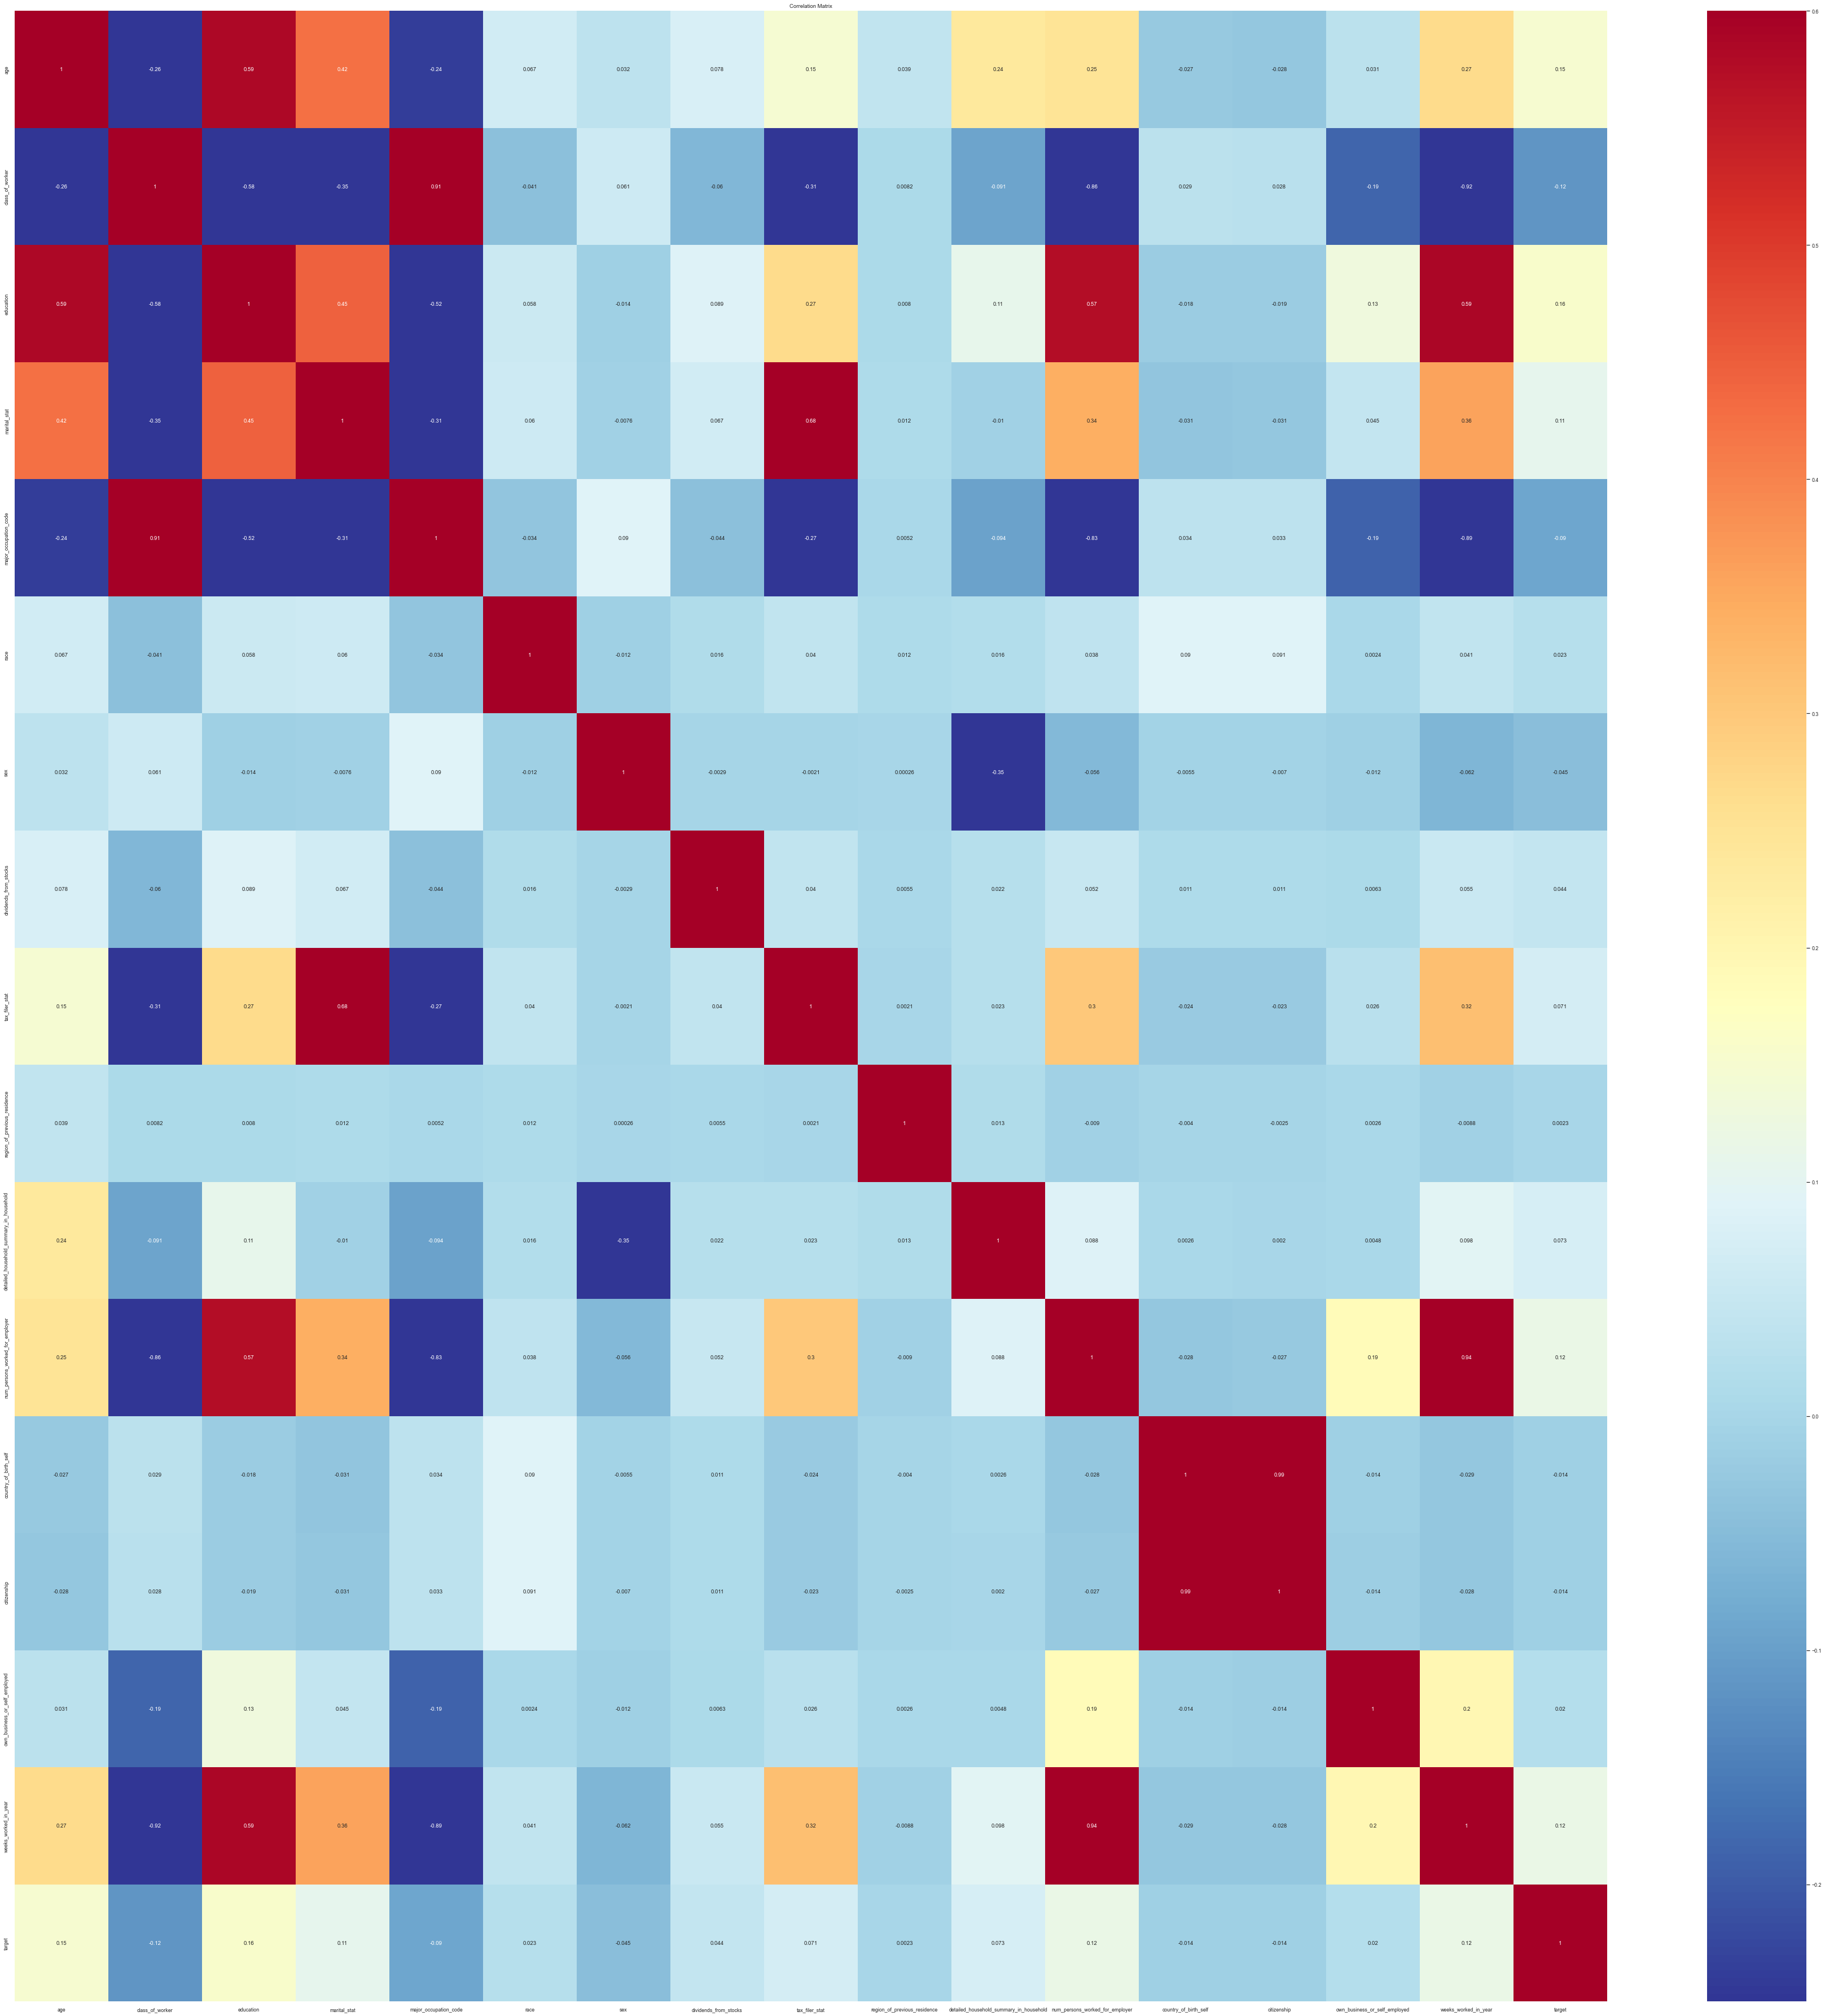

In [433]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [434]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 4
The number of features remaining: 12


In [435]:
del_features

array(['citizenship', 'class_of_worker', 'major_occupation_code',
       'weeks_worked_in_year'], dtype='<U21')

In [436]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 12


In [437]:
sorted(count_features)

['age',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat']

In [438]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [439]:
#X_tr, X_te, y_tr, y_te = train_test_split(synt_data[real_model_features],synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [440]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [441]:
X_te1.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       1
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             3
region_of_previous_residence               0
detailed_household_summary_in_household    1
num_persons_worked_for_employer            0
country_of_birth_self                      0
own_business_or_self_employed              0
dtype: int64

In [442]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       1
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             3
region_of_previous_residence               0
detailed_household_summary_in_household    1
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [443]:
X_te_real1.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      5
num_persons_worked_for_employer              0
country_of_birth_self                      113
own_business_or_self_employed                0
dtype: int64

In [444]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      5
country_of_birth_self                      113
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [445]:
sorted(synt_data['citizenship'].unique()) 


['Children',
 'Foreign born- Not a citizen of U S',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States',
 'Never married']

In [446]:
sorted(real_data['citizenship'].unique())

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [447]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\2398710961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\2398710961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\2398710961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0

In [448]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 203 ms
Wall time: 218 ms


In [449]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.674 total time=   0.0s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.636 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.654 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.665 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.651 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.669 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.634 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.654 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.665 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.657 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.668 total time=   0.1s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [450]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.656050609160644
LogisticRegression(C=0.0001, solver='saga')


In [451]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)


In [452]:
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [453]:
res_test11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test11, res_test_real11],axis=0)

In [454]:
res_test11

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Synth test           0.646746   

     Recall  Precision   ROC_AUC  
0  0.757033    0.10221  0.646746

In [455]:
res_test_real11

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Real test           0.771826   

     Recall  Precision   ROC_AUC  
0  0.949735   0.135882  0.771826

In [456]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 203 ms
Wall time: 202 ms


In [457]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.674 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.641 total time=   0.0s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.661 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.659 total time=   0.0s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.651 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.674 total time=   0.3s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.641 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.660 total time=   0.0s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.667 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.657 total time=   0.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.674 total time=   1.0s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.641 total time=   0.9s
[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.661 total time=   0.6s
[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.669 total time=   0.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.659 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.674 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.642 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.661 total time=   1.2s
[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.669 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.660 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.674 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.642 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.661 total time=   0.9s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.669 total time=   0.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.660 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.674 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.642 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.661 total time=   1.2s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.669 total time=   0.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.660 total time=   1.1s
CPU times: total: 25.4 s
Wall time: 25.9 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [458]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.661105181326868
LogisticRegression(C=0.1, solver='saga')


In [459]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)


In [460]:
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [461]:
res_test12 = pd.DataFrame([['LogRegression DistillGPT real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real12 = pd.DataFrame([['LogRegression DistillGPT real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test12, res_test_real12],axis=0)

In [462]:
res_test12

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Synth test           0.650103   

     Recall  Precision   ROC_AUC  
0  0.754476   0.103764  0.650103

In [463]:
res_test_real12

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Real test            0.77364   

     Recall  Precision  ROC_AUC  
0  0.920635   0.142215  0.77364

## GPT2XL classification

### Data preprocessing 

In [464]:
synt_data = synt_data_gpt2xl.copy()

In [465]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [466]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [467]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [468]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [469]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' '10th grade' '12th grade no diploma' '7th and 8th grade'
 'High school graduate' 'Associates degree-occup /vocational'
 'Bachelors degree(BA AB BS)' 'Doctorate degree(PhD EdD)' '11th grade'
 '5th or 6th grade' 'Some college but no degree' 'Less than 1st grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Prof school degree (MD DDS DVM LLB JD)'
 'Associates degree-academic program' '9th grade'
 '1st 2nd 3rd or 4th grade' 'Prof school degree (MD DVM LLB JD)'
 '3rd or 4th grade'] 19


In [470]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [471]:
to_encode_synt = to_encode.copy() 

In [472]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ race
+ sex
+ tax_filer_stat
+ citizenship
+ own_business_or_self_employed


In [473]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self


In [474]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [475]:
X_tr.fillna(0,inplace=True)

In [476]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [477]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.461246   0.721937   
class_of_worker                         -0.461246         1.000000  -0.709908   
education                                0.721937        -0.709908   1.000000   
marital_stat                            -0.831042         0.483739  -0.670686   
major_occupation_code                   -0.427880         0.924500  -0.645351   
race                                     0.057530        -0.057357   0.067337   
sex                                     -0.020596        -0.102419   0.015749   
dividends_from_stocks                    0.103312        -0.098257   0.140847   
tax_filer_stat                           0.664893        -0.759084   0.794534   
region_of_previous_residence             0.035167        -0.001806   0.010064   
detailed_household_summary_in_household -0.640707         0.538704  -0.721816   
num_persons_worked_for_employer          0.435292        -0.890296   0.708538   
country_of_birth_self                   -0.055308         0.048377  -0.034116   
citizenship                              0.006021         0.011055   0.009795   
own_business_or_self_employed            0.063781        -0.199465   0.167939   
weeks_worked_in_year                     0.464470        -0.943845   0.723652   
target                                   0.223345        -0.295700   0.345757   

                                         marital_stat  major_occupation_code  \
age                                         -0.831042              -0.427880   
class_of_worker                              0.483739               0.924500   
education                                   -0.670686              -0.645351   
marital_stat                                 1.000000               0.444080   
major_occupation_code                        0.444080               1.000000   
race                                        -0.062543              -0.049380   
sex                                          0.067136              -0.151402   
dividends_from_stocks                       -0.092378              -0.079005   
tax_filer_stat                              -0.714033              -0.725118   
region_of_previous_residence                -0.020525               0.009044   
detailed_household_summary_in_household      0.558071               0.520204   
num_persons_worked_for_employer             -0.459768              -0.862084   
country_of_birth_self                        0.051858               0.068902   
citizenship                                 -0.002800               0.033985   
own_business_or_self_employed               -0.059234              -0.200183   
weeks_worked_in_year                        -0.493774              -0.914953   
target                                      -0.207898              -0.247093   

                                             race       sex  \
age                                      0.057530 -0.020596   
class_of_worker                         -0.057357 -0.102419   
education                                0.067337  0.015749   
marital_stat                            -0.062543  0.067136   
major_occupation_code                   -0.049380 -0.151402   
race                                     1.000000  0.030310   
sex                                      0.030310  1.000000   
dividends_from_stocks                    0.023928  0.041739   
tax_filer_stat                           0.096908  0.023728   
region_of_previous_residence             0.016844  0.012330   
detailed_household_summary_in_household -0.019496  0.168967   
num_persons_worked_for_employer          0.048544  0.084934   
country_of_birth_self                   -0.077392 -0.005464   
citizenship                             -0.022567 -0.002984   
own_business_or_self_employed            0.017403  0.027342   
weeks_worked_in_year                     0.059196  0.104316   
target                                   0.053133  0.190657   

           

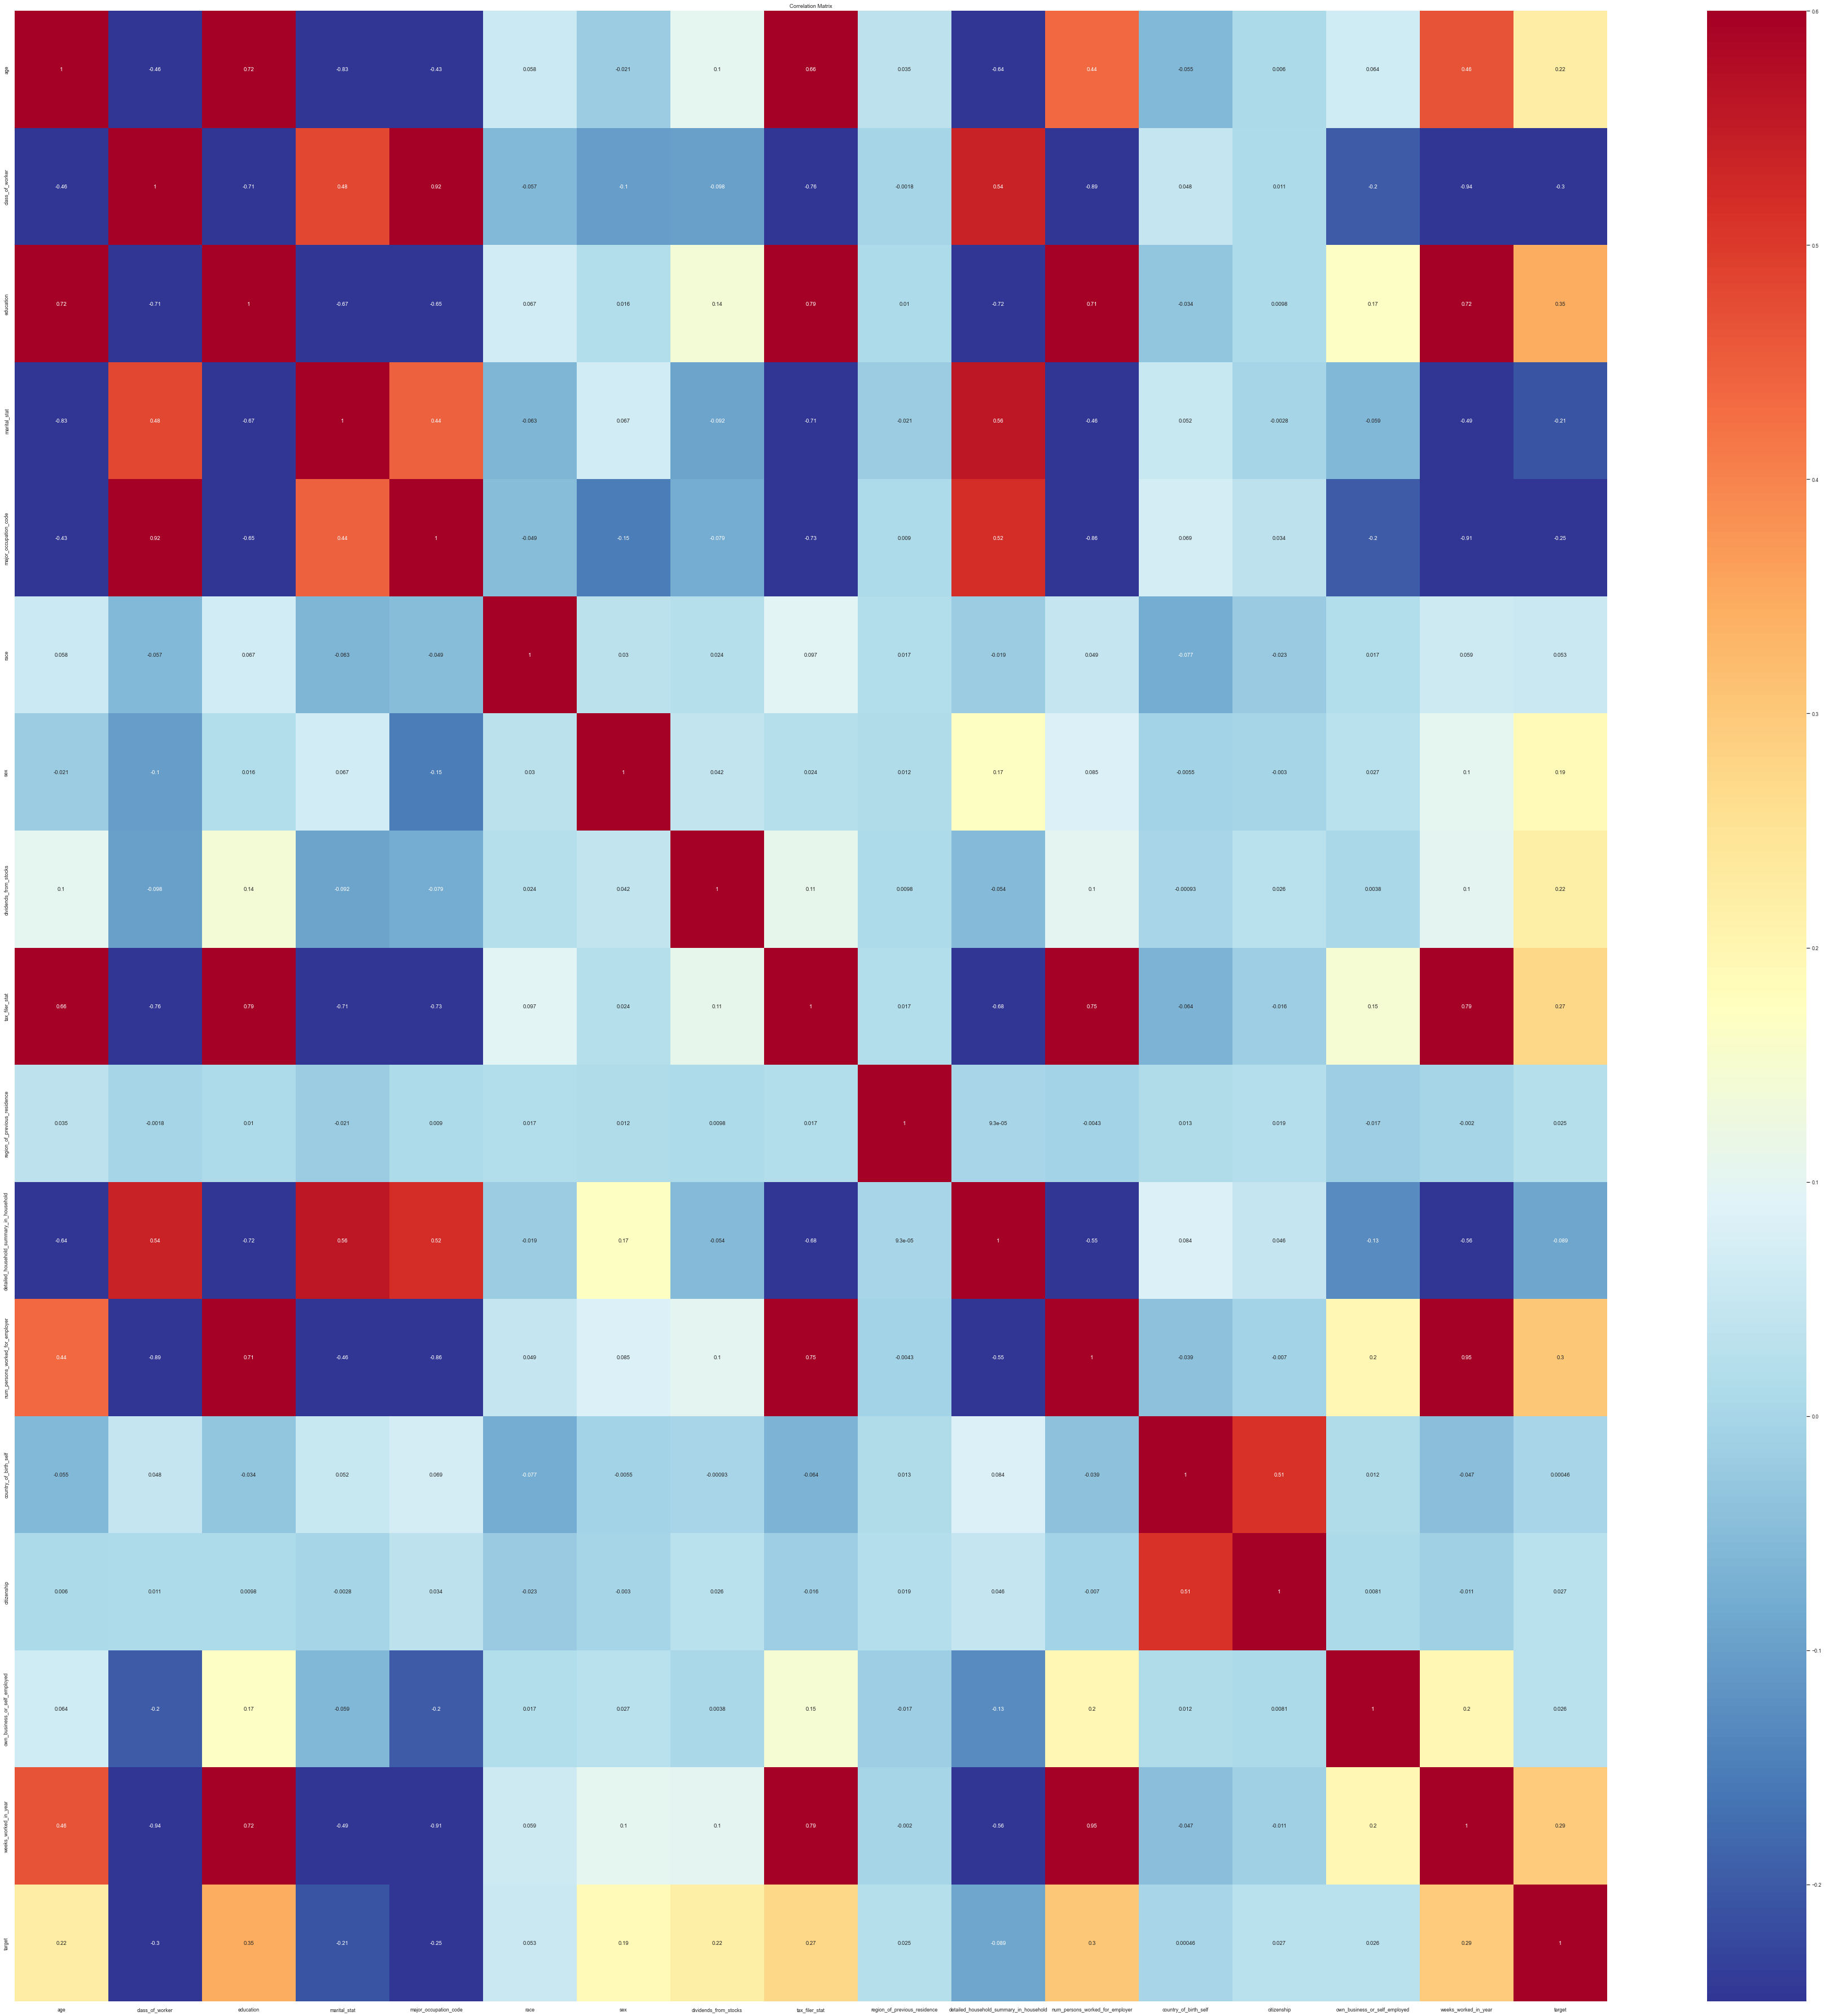

In [478]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [479]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 4
The number of features remaining: 12


In [480]:
del_features

array(['class_of_worker', 'major_occupation_code', 'marital_stat',
       'weeks_worked_in_year'], dtype='<U21')

In [481]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 12


In [482]:
sorted(count_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat']

In [483]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [484]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [485]:
X_te2.isna().sum()

age                                        0
education                                  2
marital_stat                               0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    1
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [486]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [487]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [488]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\839306755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\839306755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\839306755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna

In [489]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 203 ms
Wall time: 204 ms


In [490]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.842 total time=   0.0s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.851 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.852 total time=   0.0s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.845 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.851 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.853 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.855 total time=   0.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.863 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.0s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.864 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.854 total time=   0.4s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.860 total time=   0.9s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.854 total time=   0.8s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.860 total time=   0.9s
[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.855 total time=   0.8s
[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.854 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.860 total time=   1.0s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.854 total time=   0.7s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.860 total time=   0.9s
CPU times: total: 18.1 s
Wall time: 18.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [491]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8576088979451091
LogisticRegression(C=0.001, solver='saga')


In [492]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [493]:
res_test21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test21, res_test_real21],axis=0)

In [494]:
res_test21

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Synth test            0.86789   

     Recall  Precision  ROC_AUC  
0  0.925831   0.253501  0.86789

In [495]:
res_test_real21

Model    Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Real test           0.832253   

     Recall  Precision   ROC_AUC  
0  0.857143   0.230277  0.832253

In [496]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 234 ms
Wall time: 241 ms


In [497]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.845 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.856 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.848 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.843 total time=   0.0s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.848 total time=   0.0s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.861 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.864 total time=   0.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.862 total time=   0.0s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.862 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.862 total time=   0.4s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.857 total time=   0.9s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.846 total time=   0.8s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.858 total time=   0.9s
[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.862 total time=   0.7s
[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.862 total time=   0.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.857 total time=   0.9s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.845 total time=   0.7s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.858 total time=   1.1s
CPU times: total: 17.7 s
Wall time: 18.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [498]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8605869066632813
LogisticRegression(C=0.001, solver='saga')


In [499]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [500]:
res_test22 = pd.DataFrame([['LogRegression GPT2xl real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real22 = pd.DataFrame([['LogRegression GPT2xl real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test22, res_test_real22],axis=0)

In [501]:
res_test22

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl real features  Synth test           0.864914   

     Recall  Precision   ROC_AUC  
0  0.915601   0.255714  0.864914

In [502]:
res_test_real22

Model    Dataset  Balanced_accuracy   Recall  \
0  LogRegression GPT2xl real features  Real test           0.839401  0.87037   

   Precision   ROC_AUC  
0   0.233997  0.839401

## Cerebras classification

### Data preprocessing 

In [503]:
synt_data = synt_data_cerebras.copy()

In [504]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [505]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [506]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [507]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [508]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' '7th and 8th grade' 'High school graduate'
 'Some college but no degree' 'Associates degree-occup /vocational'
 'Prof school degree (MD DDS DVM LLB JD)'
 'Masters degree(MA MS MEng MEd MSW MBA)' 'Bachelors degree(BA AB BS)'
 '1st 2nd 3rd or 4th grade' '5th or 6th grade'
 'Associates degree-academic program' '10th grade' '11th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' 'Less than 1st grade'
 '12th grade no diploma'] 17


In [509]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [510]:
to_encode_synt = to_encode.copy() 

In [511]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ own_business_or_self_employed


In [512]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship


In [513]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [514]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [515]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.464228   0.728029   
class_of_worker                         -0.464228         1.000000  -0.716690   
education                                0.728029        -0.716690   1.000000   
marital_stat                             0.784367        -0.559911   0.712306   
major_occupation_code                   -0.431899         0.925898  -0.654021   
race                                     0.072954        -0.070560   0.076046   
sex                                     -0.031313        -0.092784   0.012876   
dividends_from_stocks                    0.101704        -0.095573   0.145117   
tax_filer_stat                           0.666630        -0.767304   0.799890   
region_of_previous_residence             0.038852         0.013929  -0.004957   
detailed_household_summary_in_household -0.651014         0.551833  -0.730674   
num_persons_worked_for_employer          0.445120        -0.890540   0.715350   
country_of_birth_self                   -0.047872         0.032942  -0.024710   
citizenship                             -0.047901         0.032968  -0.024625   
own_business_or_self_employed            0.053114        -0.190042   0.158730   
weeks_worked_in_year                     0.469761        -0.942552   0.729136   
target                                   0.221205        -0.297123   0.345877   

                                         marital_stat  major_occupation_code  \
age                                          0.784367              -0.431899   
class_of_worker                             -0.559911               0.925898   
education                                    0.712306              -0.654021   
marital_stat                                 1.000000              -0.517240   
major_occupation_code                       -0.517240               1.000000   
race                                         0.111147              -0.059700   
sex                                         -0.006362              -0.150125   
dividends_from_stocks                        0.108507              -0.074064   
tax_filer_stat                               0.858963              -0.734631   
region_of_previous_residence                 0.029301               0.012858   
detailed_household_summary_in_household     -0.615213               0.525712   
num_persons_worked_for_employer              0.539651              -0.864805   
country_of_birth_self                       -0.049331               0.052718   
citizenship                                 -0.049383               0.052781   
own_business_or_self_employed                0.064893              -0.195575   
weeks_worked_in_year                         0.571207              -0.915708   
target                                       0.250477              -0.247614   

                                             race       sex  \
age                                      0.072954 -0.031313   
class_of_worker                         -0.070560 -0.092784   
education                                0.076046  0.012876   
marital_stat                             0.111147 -0.006362   
major_occupation_code                   -0.059700 -0.150125   
race                                     1.000000  0.023583   
sex                                      0.023583  1.000000   
dividends_from_stocks                    0.025408  0.040439   
tax_filer_stat                           0.107106  0.021576   
region_of_previous_residence             0.022810  0.012385   
detailed_household_summary_in_household -0.026673  0.183686   
num_persons_worked_for_employer          0.054290  0.080149   
country_of_birth_self                    0.085644  0.000279   
citizenship                              0.084910  0.000279   
own_business_or_self_employed            0.017154  0.021675   
weeks_worked_in_year                     0.068937  0.095682   
target                                   0.041630  0.208630   

           

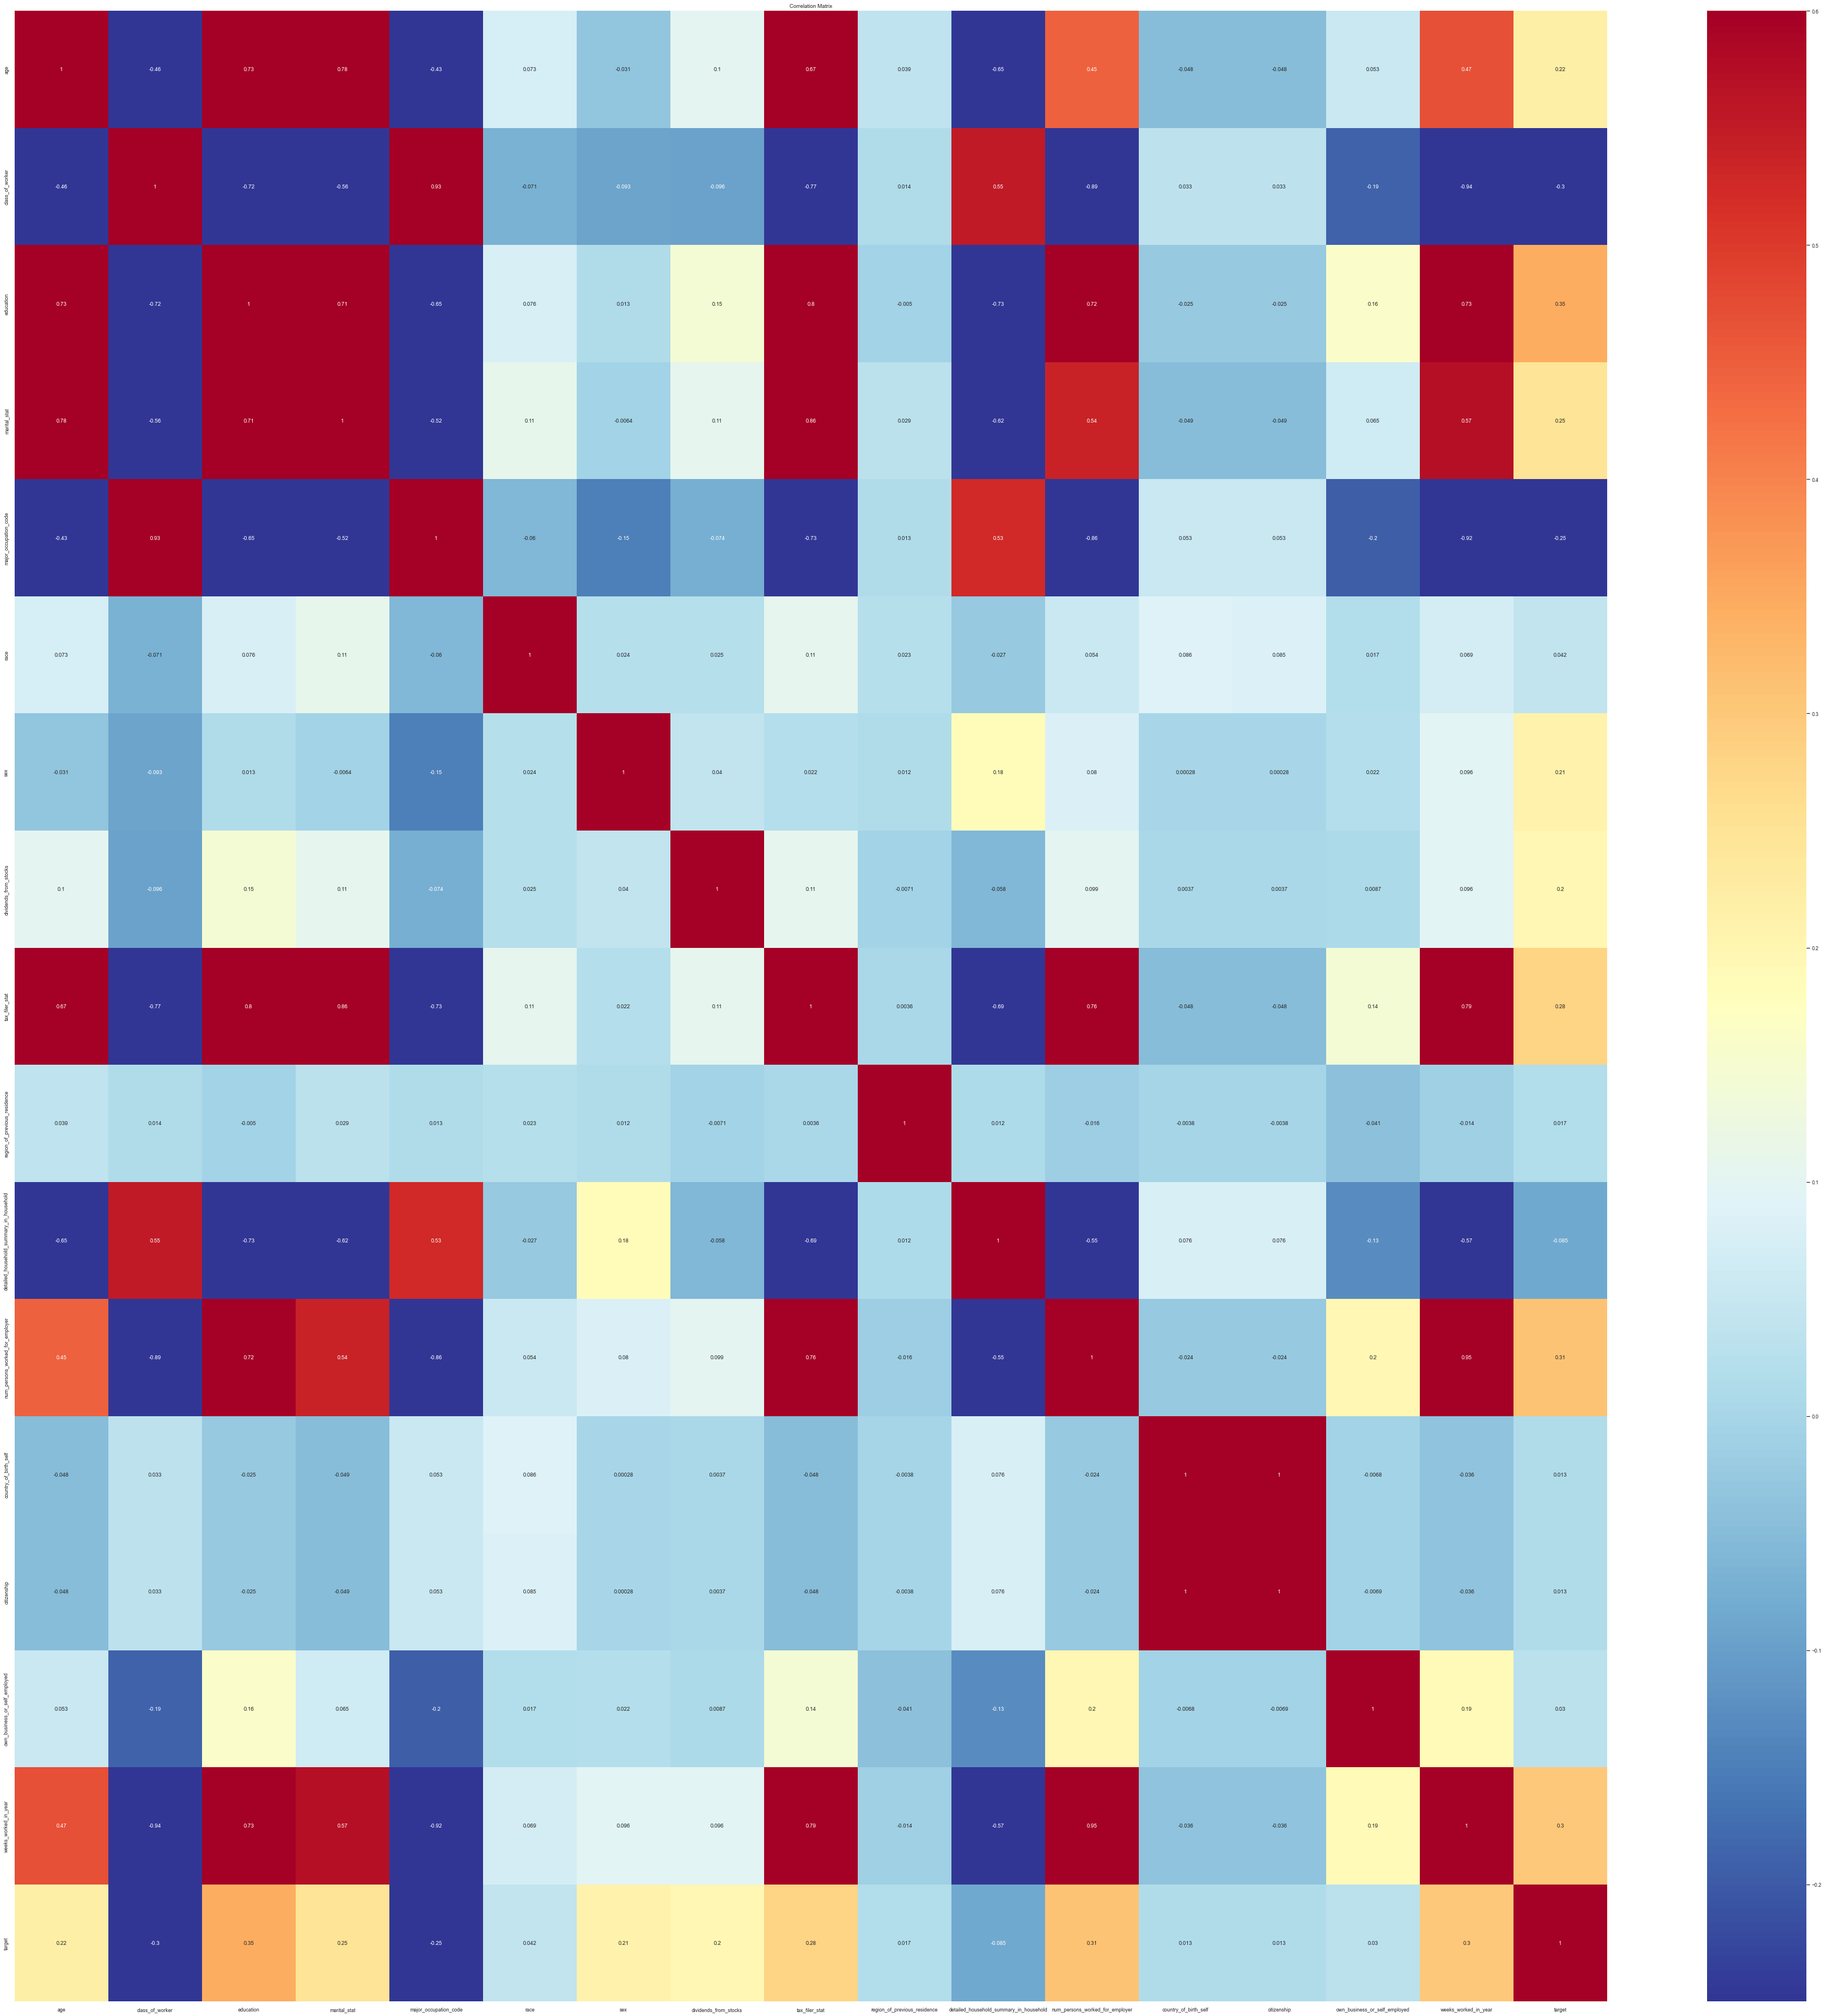

In [516]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [517]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 5
The number of features remaining: 11


In [518]:
del_features

array(['class_of_worker', 'country_of_birth_self',
       'major_occupation_code', 'marital_stat', 'weeks_worked_in_year'],
      dtype='<U21')

In [519]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 11


In [520]:
sorted(count_features)

['age',
 'citizenship',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat']

In [521]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [522]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [523]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      2
country_of_birth_self                      108
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [524]:
sorted(synt_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [525]:
sorted(real_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [526]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\2848899291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\2848899291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)


In [527]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 359 ms
Wall time: 348 ms


In [528]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.855 total time=   0.0s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.852 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.854 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.851 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.858 total time=   0.0s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.867 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.866 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.867 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.862 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.868 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.869 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.865 total time=   0.8s
[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.859 total time=   0.4s
[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.860 total time=   0.4s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.866 total time=   0.5s
[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.869 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.865 total time=   1.1s
[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.859 total time=   0.6s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.859 total time=   0.4s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.866 total time=   0.6s
[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.869 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.865 total time=   1.0s
[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.859 total time=   0.4s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.860 total time=   0.4s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.866 total time=   0.5s
CPU times: total: 14.5 s
Wall time: 14.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [529]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8660431185131611
LogisticRegression(C=0.001, solver='saga')


In [530]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [531]:
res_test31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test31, res_test_real31],axis=0)

In [532]:
res_test31

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Synth test            0.86132   

     Recall  Precision  ROC_AUC  
0  0.903308   0.259503  0.86132

In [533]:
res_test_real31

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Real test           0.828064   

     Recall  Precision   ROC_AUC  
0  0.838624   0.236039  0.828064

In [534]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 234 ms
Wall time: 220 ms


In [535]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.844 total time=   0.0s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.834 total time=   0.0s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.841 total time=   0.0s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.852 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.850 total time=   0.0s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.868 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.863 total time=   0.3s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.870 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.873 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.873 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.872 total time=   0.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.863 total time=   0.9s
[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.864 total time=   0.5s
[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.872 total time=   0.4s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.872 total time=   0.5s
[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.873 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.863 total time=   0.8s
[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.862 total time=   0.5s
[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.871 total time=   0.5s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.874 total time=   0.5s
[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.873 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.863 total time=   0.9s
[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.862 total time=   0.6s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.871 total time=   0.5s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.874 total time=   0.5s
[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.873 total time=   0.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.863 total time=   0.9s
[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.862 total time=   0.5s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.871 total time=   0.5s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.874 total time=   0.5s
CPU times: total: 16.2 s
Wall time: 16.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [536]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8693682940204642
LogisticRegression(C=0.001, solver='saga')


In [537]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [538]:
res_test32 = pd.DataFrame([['LogRegression Cerebras real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real32 = pd.DataFrame([['LogRegression Cerebras real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test32, res_test_real32],axis=0)

In [539]:
res_test32

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Synth test           0.868591   

     Recall  Precision   ROC_AUC  
0  0.908397   0.271071  0.868591

In [540]:
res_test_real32

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Real test           0.830565   

     Recall  Precision   ROC_AUC  
0  0.835979   0.243264  0.830565

## Phi1.5 classification

### Data preprocessing 

In [541]:
synt_data = synt_data_phi.copy()

In [542]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [543]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [544]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [545]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [546]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'Some college but no degree' 'High school graduate'
 'Associates degree-academic program'
 'Prof school degree (MD DDS DVM LLB JD)'
 'Associates degree-occup /vocational' '7th and 8th grade'
 'Bachelors degree(BA AB BS)' '10th grade' '9th grade'
 'Doctorate degree(PhD EdD)' '11th grade' '1st 2nd 3rd or 4th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)' '5th or 6th grade'
 '12th grade no diploma' 'Less than 1st grade'] 17


In [547]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [548]:
to_encode_synt = to_encode.copy() 

In [549]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ marital_stat
+ sex
+ tax_filer_stat
+ own_business_or_self_employed


In [550]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ major_occupation_code
+ race
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship


In [551]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [552]:
#X_tr.fillna(0,inplace=True)

In [553]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [554]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.453342   0.716709   
class_of_worker                         -0.453342         1.000000  -0.705726   
education                                0.716709        -0.705726   1.000000   
marital_stat                             0.779303        -0.546399   0.694066   
major_occupation_code                   -0.418961         0.923007  -0.643340   
race                                     0.083545        -0.078306   0.092630   
sex                                     -0.017760        -0.088002   0.011978   
dividends_from_stocks                    0.105777        -0.080921   0.137547   
tax_filer_stat                           0.670275        -0.753905   0.789980   
region_of_previous_residence             0.039283         0.006103  -0.001853   
detailed_household_summary_in_household -0.631718         0.544797  -0.719961   
num_persons_worked_for_employer          0.434648        -0.888545   0.702558   
country_of_birth_self                   -0.046460         0.031001  -0.007786   
citizenship                             -0.046546         0.031047  -0.007701   
own_business_or_self_employed            0.058544        -0.195440   0.167064   
weeks_worked_in_year                     0.460372        -0.942499   0.716222   
target                                   0.220503        -0.263433   0.321916   

                                         marital_stat  major_occupation_code  \
age                                          0.779303              -0.418961   
class_of_worker                             -0.546399               0.923007   
education                                    0.694066              -0.643340   
marital_stat                                 1.000000              -0.500709   
major_occupation_code                       -0.500709               1.000000   
race                                         0.115530              -0.070511   
sex                                          0.001814              -0.139077   
dividends_from_stocks                        0.104279              -0.057088   
tax_filer_stat                               0.860026              -0.717140   
region_of_previous_residence                 0.025726               0.005114   
detailed_household_summary_in_household     -0.591486               0.523274   
num_persons_worked_for_employer              0.526840              -0.862650   
country_of_birth_self                       -0.055048               0.057667   
citizenship                                 -0.055173               0.057748   
own_business_or_self_employed                0.072733              -0.197028   
weeks_worked_in_year                         0.559311              -0.911877   
target                                       0.234148              -0.213896   

                                             race       sex  \
age                                      0.083545 -0.017760   
class_of_worker                         -0.078306 -0.088002   
education                                0.092630  0.011978   
marital_stat                             0.115530  0.001814   
major_occupation_code                   -0.070511 -0.139077   
race                                     1.000000  0.026542   
sex                                      0.026542  1.000000   
dividends_from_stocks                    0.028478  0.027721   
tax_filer_stat                           0.118026  0.023452   
region_of_previous_residence             0.010782  0.005561   
detailed_household_summary_in_household -0.050226  0.170327   
num_persons_worked_for_employer          0.067543  0.071864   
country_of_birth_self                    0.075103  0.004763   
citizenship                              0.074072  0.004673   
own_business_or_self_employed            0.025501  0.011392   
weeks_worked_in_year                     0.082615  0.093748   
target                                   0.051745  0.186980   

           

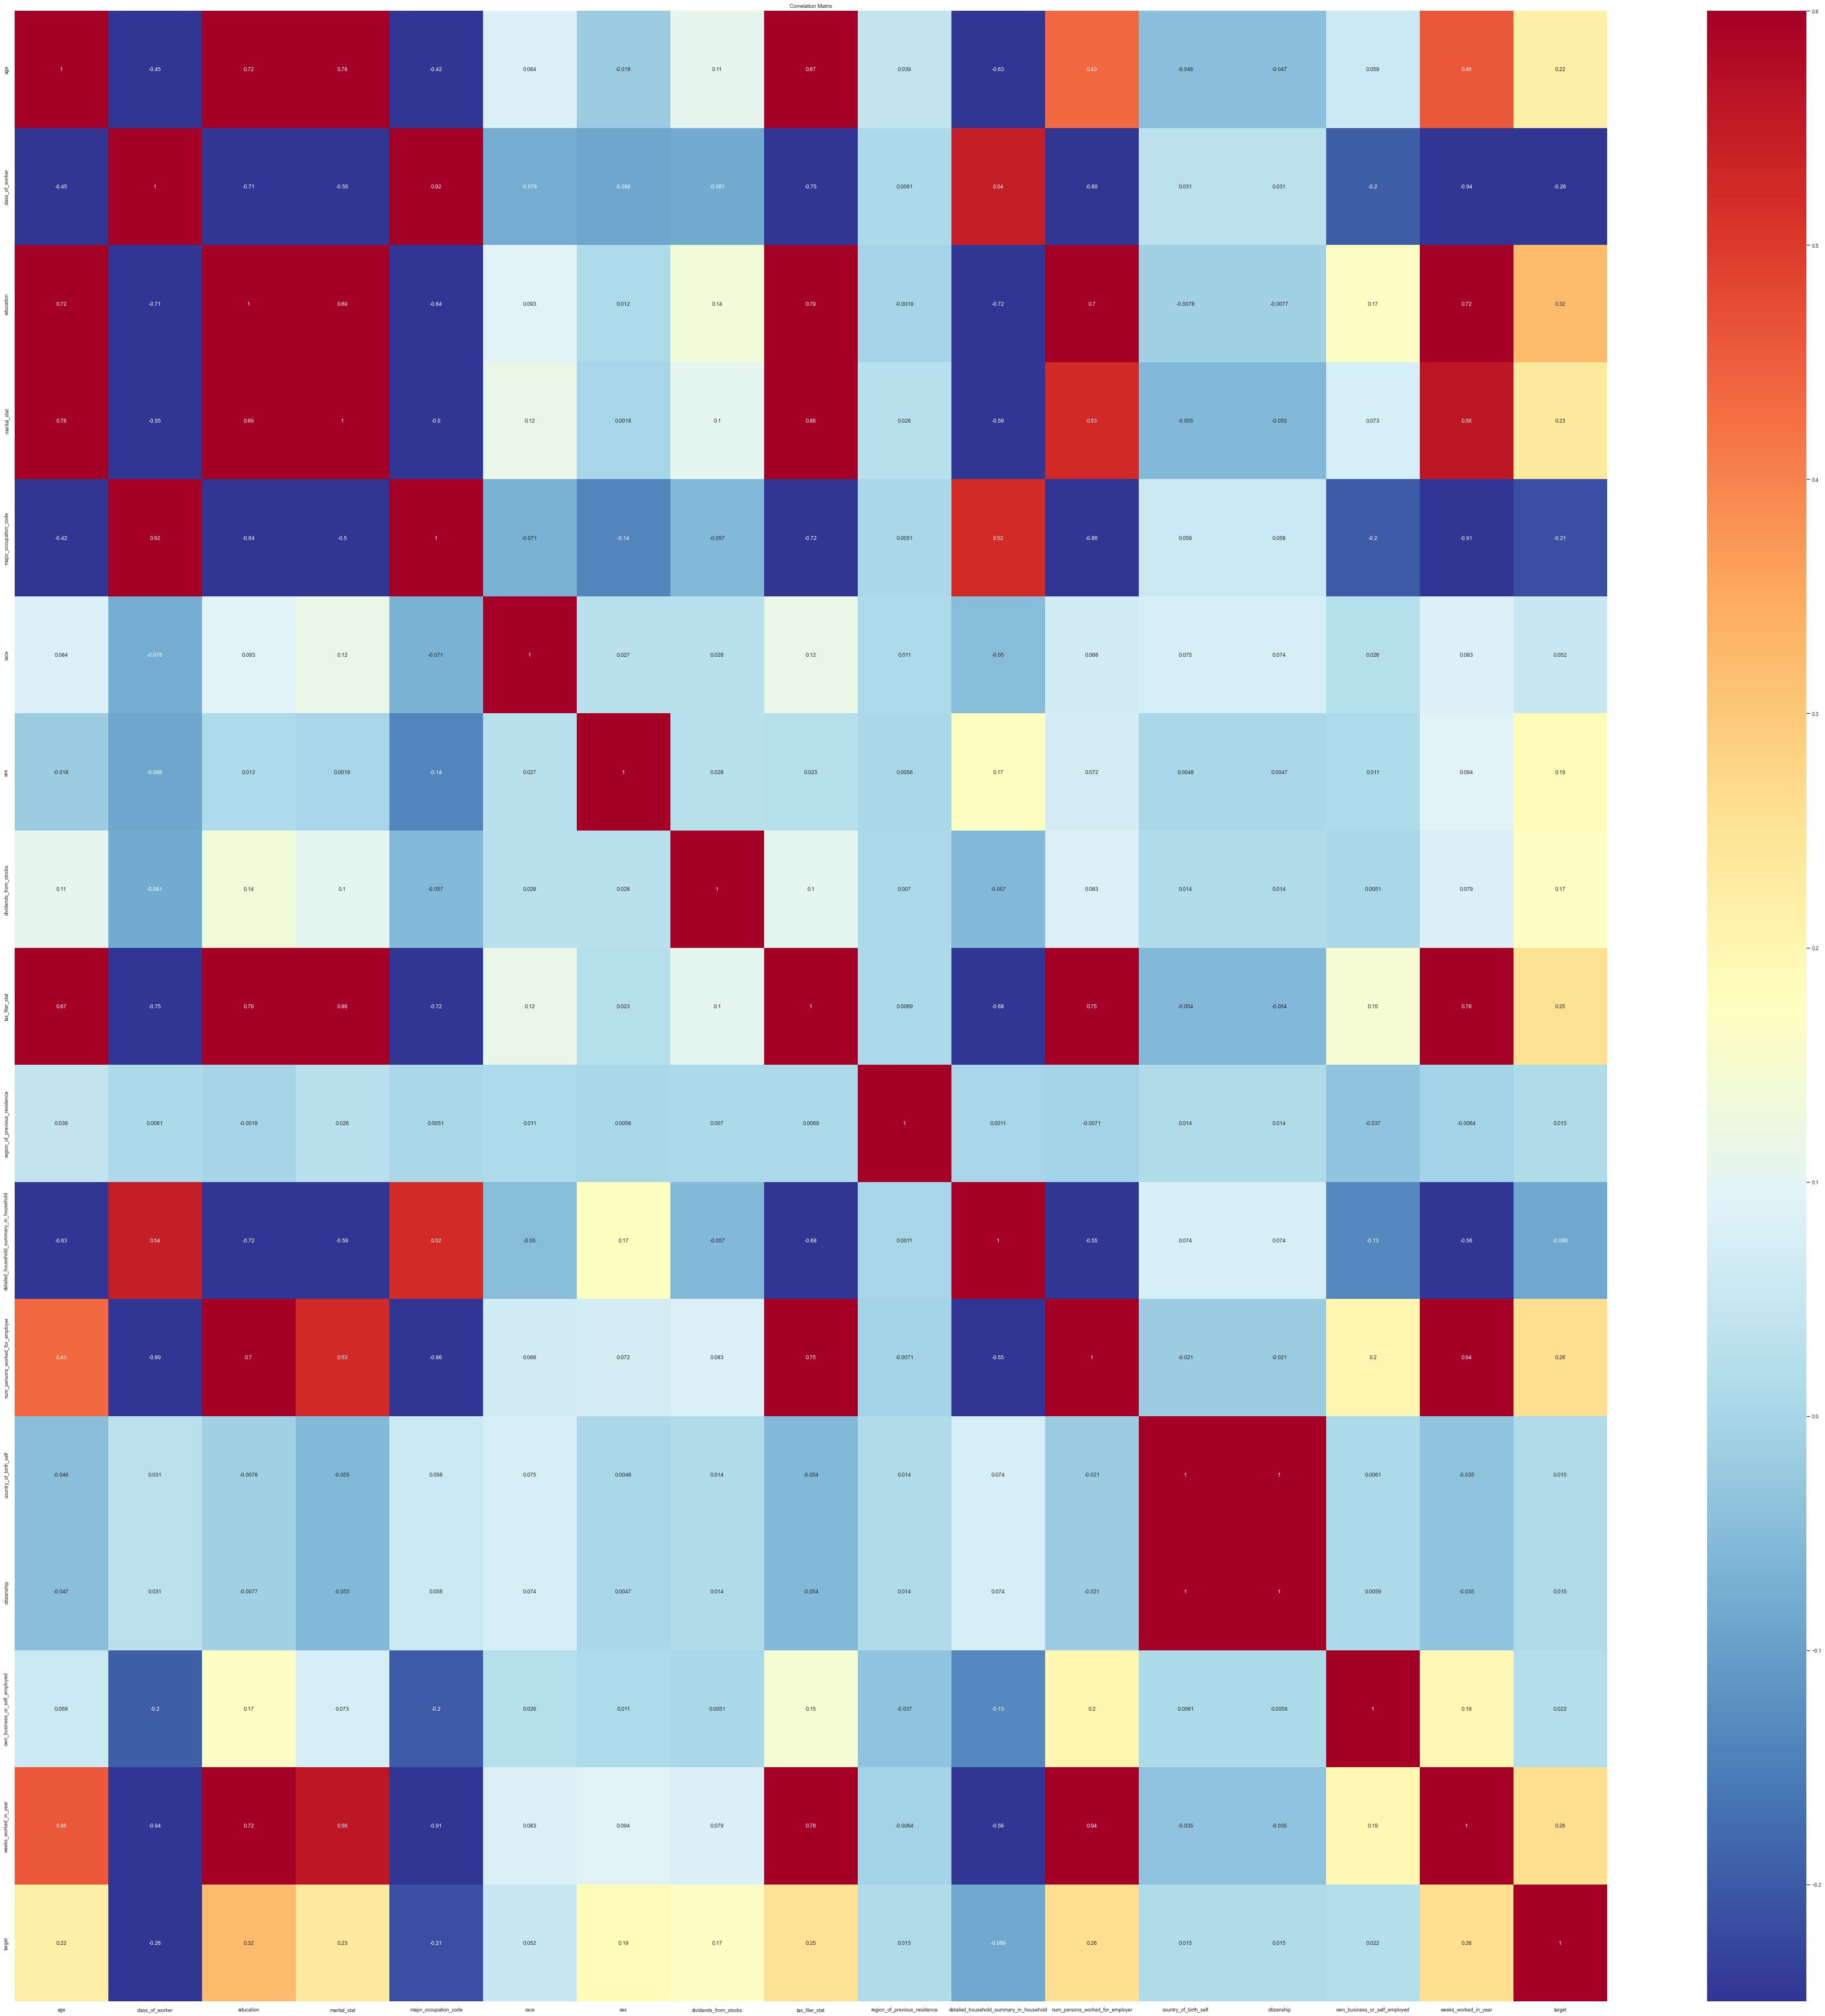

In [555]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [556]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 5
The number of features remaining: 11


In [557]:
del_features

array(['citizenship', 'major_occupation_code', 'marital_stat',
       'num_persons_worked_for_employer', 'weeks_worked_in_year'],
      dtype='<U31')

In [558]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 11


In [559]:
sorted(count_features)

['age',
 'class_of_worker',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat']

In [560]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [561]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [562]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      1
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [563]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Outlying-U S (Guam USVI etc)',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [564]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [565]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\839306755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\839306755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\839306755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna

In [566]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 188 ms
Wall time: 175 ms


In [567]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.826 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.851 total time=   0.0s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.836 total time=   0.0s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.844 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.835 total time=   0.0s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.828 total time=   0.0s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.851 total time=   0.0s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.836 total time=   0.0s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.0s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.838 total time=   0.0s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.829 total time=   0.1s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [568]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8402006103852875
LogisticRegression(C=0.01, solver='saga')


In [569]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [570]:
res_test41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test41, res_test_real41],axis=0)

In [571]:
res_test41

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Synth test           0.824702   

     Recall  Precision   ROC_AUC  
0  0.857143   0.223851  0.824702

In [572]:
res_test_real41

Model    Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Real test           0.835698   

     Recall  Precision   ROC_AUC  
0  0.883598    0.21873  0.835698

In [573]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 234 ms
Wall time: 250 ms


In [574]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.816 total time=   0.0s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.828 total time=   0.0s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.815 total time=   0.0s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.820 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.833 total time=   0.0s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.829 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.856 total time=   0.0s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.834 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.846 total time=   0.0s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.837 total time=   0.0s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.828 total time=   0.0s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.831 total time=   0.9s
[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.848 total time=   0.0s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.833 total time=   0.1s
[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.830 total time=   0.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.857 total time=   0.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.830 total time=   0.9s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.848 total time=   0.0s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.833 total time=   0.8s
[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.830 total time=   0.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.857 total time=   0.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.830 total time=   0.9s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.848 total time=   0.0s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.833 total time=   0.9s
CPU times: total: 10.7 s
Wall time: 10.7 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [575]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8405764626760133
LogisticRegression(C=0.001, solver='saga')


In [576]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [577]:
res_test42 = pd.DataFrame([['LogRegression Phi1.5 real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real42 = pd.DataFrame([['LogRegression Phi1.5 real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test42, res_test_real42],axis=0)

In [578]:
res_test42

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 real features  Synth test           0.823481   

     Recall  Precision   ROC_AUC  
0  0.859694   0.220261  0.823481

In [579]:
res_test_real42

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression Phi1.5 real features  Real test           0.830941  0.873016   

   Precision   ROC_AUC  
0   0.217535  0.830941

## Modelling result

In [580]:
model_results

Model     Dataset  Balanced_accuracy  \
0                      LogRegression Real data   Real test           0.845280   
0  LogRegression DistillGPT synthetic features  Synth test           0.646746   
0  LogRegression DistillGPT synthetic features   Real test           0.771826   
0       LogRegression DistillGPT real features  Synth test           0.650103   
0       LogRegression DistillGPT real features   Real test           0.773640   
0      LogRegression GPT2xl synthetic features  Synth test           0.867890   
0      LogRegression GPT2xl synthetic features   Real test           0.832253   
0           LogRegression GPT2xl real features  Synth test           0.864914   
0           LogRegression GPT2xl real features   Real test           0.839401   
0    LogRegression Cerebras synthetic features  Synth test           0.861320   
0    LogRegression Cerebras synthetic features   Real test           0.828064   
0         LogRegression Cerebras real features  Synth test           0.868591   
0         LogRegression Cerebras real features   Real test           0.830565   
0      LogRegression Phi1.5 synthetic features  Synth test           0.824702   
0      LogRegression Phi1.5 synthetic features   Real test           0.835698   
0           LogRegression Phi1.5 real features  Synth test           0.823481   
0           LogRegression Phi1.5 real features   Real test           0.830941   

     Recall  Precision   ROC_AUC  
0  0.888889   0.231564  0.845280  
0  0.757033   0.102210  0.646746  
0  0.949735   0.135882  0.771826  
0  0.754476   0.103764  0.650103  
0  0.920635   0.142215  0.773640  
0  0.925831   0.253501  0.867890  
0  0.857143   0.230277  0.832253  
0  0.915601   0.255714  0.864914  
0  0.870370   0.233997  0.839401  
0  0.903308   0.259503  0.861320  
0  0.838624   0.236039  0.828064  
0  0.908397   0.271071  0.868591  
0  0.835979   0.243264  0.830565  
0  0.857143   0.223851  0.824702  
0  0.883598   0.218730  0.835698  
0  0.859694   0.220261  0.823481  
0  0.873016   0.217535  0.830941

In [581]:
model_results.to_csv('model_results_shortincome_temp0.7.csv')

# Privacy metrics

In [582]:
from pandas import DataFrame, Series
from typing import List, Tuple, Dict, Callable
import scipy.stats as ss
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mannwhitneyu, chisquare, ks_2samp



In [583]:
privacy_results = pd.DataFrame(columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median'])

In [584]:
# bound value to determine quantiles
dcr_quantile = 0.95
# how many bins should be created for privacy histograms
privacy_number_of_bins = 30
#to avoid devision by zero
smoothing_factor = 1e-8
#test sample ratio
ratio = 0.3
control_size = 9000

random_state = 12*13*99*17-1

In [585]:
tgt_train = real_dataset.copy()

In [586]:
tgt_test = control_dataset.copy()

In [587]:
def create_hamming (df, columns) :
    hamming = dict()
    for i,col in enumerate(columns) :
        hamming[col] = create_hamming_dic(df, col)
    return hamming

def create_hamming_dic (df, column):
    hamming_dic = dict()
    keys = sorted(df[column].unique())
    for i, key in enumerate(keys):
        code = i+1
        hamming_dic[key] = code
    return hamming_dic    

def map_column_humming(df, column, hamming) :
    df[column] = df[column].map(hamming[column])  
    return df[column]

def map_humming (df, hamming) :
    keys = hamming.keys()
    for col in df.columns :
        if col in keys:
            df[col] = map_column_humming(df, col, hamming)
    df.fillna(0) 
    return df
def normal_coeff (df, columns) :
    coeff = list()
    for col in columns :
        coeff.append(df[col].max())
    return coeff

In [588]:
for_hmm_columns = categs.copy()
for_hmm_columns.append('target')
for_norm_columns = numeric.copy()
hmm_train = tgt_train.copy()
hmm_train = hmm_train[for_norm_columns+for_hmm_columns]
hmm_test = tgt_test.copy()
hmm_test = hmm_test[for_norm_columns+for_hmm_columns]

In [589]:
hmm = create_hamming(hmm_train, for_hmm_columns)

In [590]:
hmm_train = map_humming(hmm_train,hmm)

In [591]:
norm_weights = normal_coeff(hmm_train, for_norm_columns)  

In [592]:
norm_weights

[90, 99999, 6, 52]

In [593]:
def get_mixed_distance (x,y, norm_weights) :
    distance = 0
    for i in range(len(norm_weights)) :  #first numeric fields  
        distance += abs(x[i]-y[i])/norm_weights[i]
    for i in range(len(norm_weights), len(x)) :  # next categorical fields
        if x[i] != y[i] :
            distance += 1
    return distance        

In [594]:
def get_2_neighbors_for_vector (vector, base, norm_weights) :
    k1 = -1 
    k2 = -1
    d1 = -1
    d2 = -1
    for i, basis in enumerate(base) :
        curr_distance = get_mixed_distance (vector, basis, norm_weights)
        if k1 < 0 :
            k1 = i
            d1 = curr_distance
        elif k2 < 0 :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            else :
                k2 = i
                d2 = curr_distance
        else :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            elif curr_distance < d2 :
                k2 = i
                d2 = curr_distance
    return np.array([[k1,k2],[d1,d2]])

In [595]:
def get_2_neighbors_mixed (vectors, base, norm_weights, trace = 0) :
    neighbors = list()
    if trace > 0 :
        print(len(vectors),':', end='')
    for i, vector in enumerate(vectors):
        neighbors.append(get_2_neighbors_for_vector (vector, base, norm_weights)) 
        if trace > 0 and i%trace == 0 :
            print(i, '-' , end='')
    print (len(vectors))
    return np.array(neighbors)

## Real data privacy

In [596]:
hmm_test = map_humming(hmm_test,hmm)

In [597]:
nbs = get_2_neighbors_mixed(vectors=hmm_test.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [598]:
print('Stats : mean, std, max, min, amount')
dcr_real = np.array([d[0] for d in [x[1] for x in [i for i in nbs]]])
dcr2_real = np.array([d[1] for d in [x[1] for x in [i for i in nbs]]])
nndr_real = dcr_real / np.maximum(dcr2_real, smoothing_factor) 
print('NNDR stats', nndr_real.mean(), nndr_real.std(), nndr_real.max(), nndr_real.min(), len (nndr_real))
baseline_dcr = dcr_real
bound = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
dcr_real_norm = np.where(dcr_real <= bound, dcr_real / bound, 1)
print('nDCR stats', dcr_real_norm.mean(), dcr_real_norm.std(), dcr_real_norm.max(), dcr_real_norm.min(), len(dcr_real_norm))
print('DCR Bound',dcr_quantile,'% =',bound)

Stats : mean, std, max, min, amount
NNDR stats 0.48010248609410033 0.4123699359575158 1.0 0.0 9000
nDCR stats 0.22862066371959058 0.31746840509738666 1.0 0.0 9000
DCR Bound 0.95 % = 2.1444444444444444


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for RealData'}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for RealData'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for RealData'}>]],
      dtype=object)

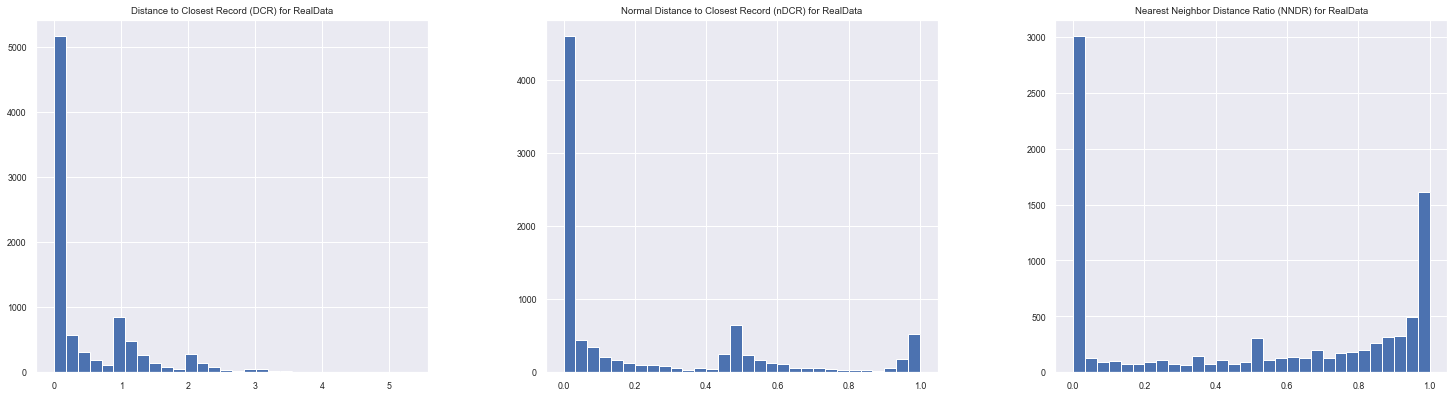

In [599]:
real_privacy = pd.DataFrame(zip(dcr_real,dcr_real_norm,nndr_real),columns=['Distance to Closest Record (DCR) for RealData','Normal Distance to Closest Record (nDCR) for RealData','Nearest Neighbor Distance Ratio (NNDR) for RealData'])
real_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [600]:
def calc_dcr_ratio(real_dcr:np.array, synt_dcr:np.array):
    med_real = np.median(real_dcr) 
    ordered_synt = np.sort(synt_dcr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [601]:
def calc_nndr_ratio(real_nndr:np.array, synt_nndr:np.array):
    med_real = np.median(real_nndr) 
    ordered_synt = np.sort(synt_nndr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

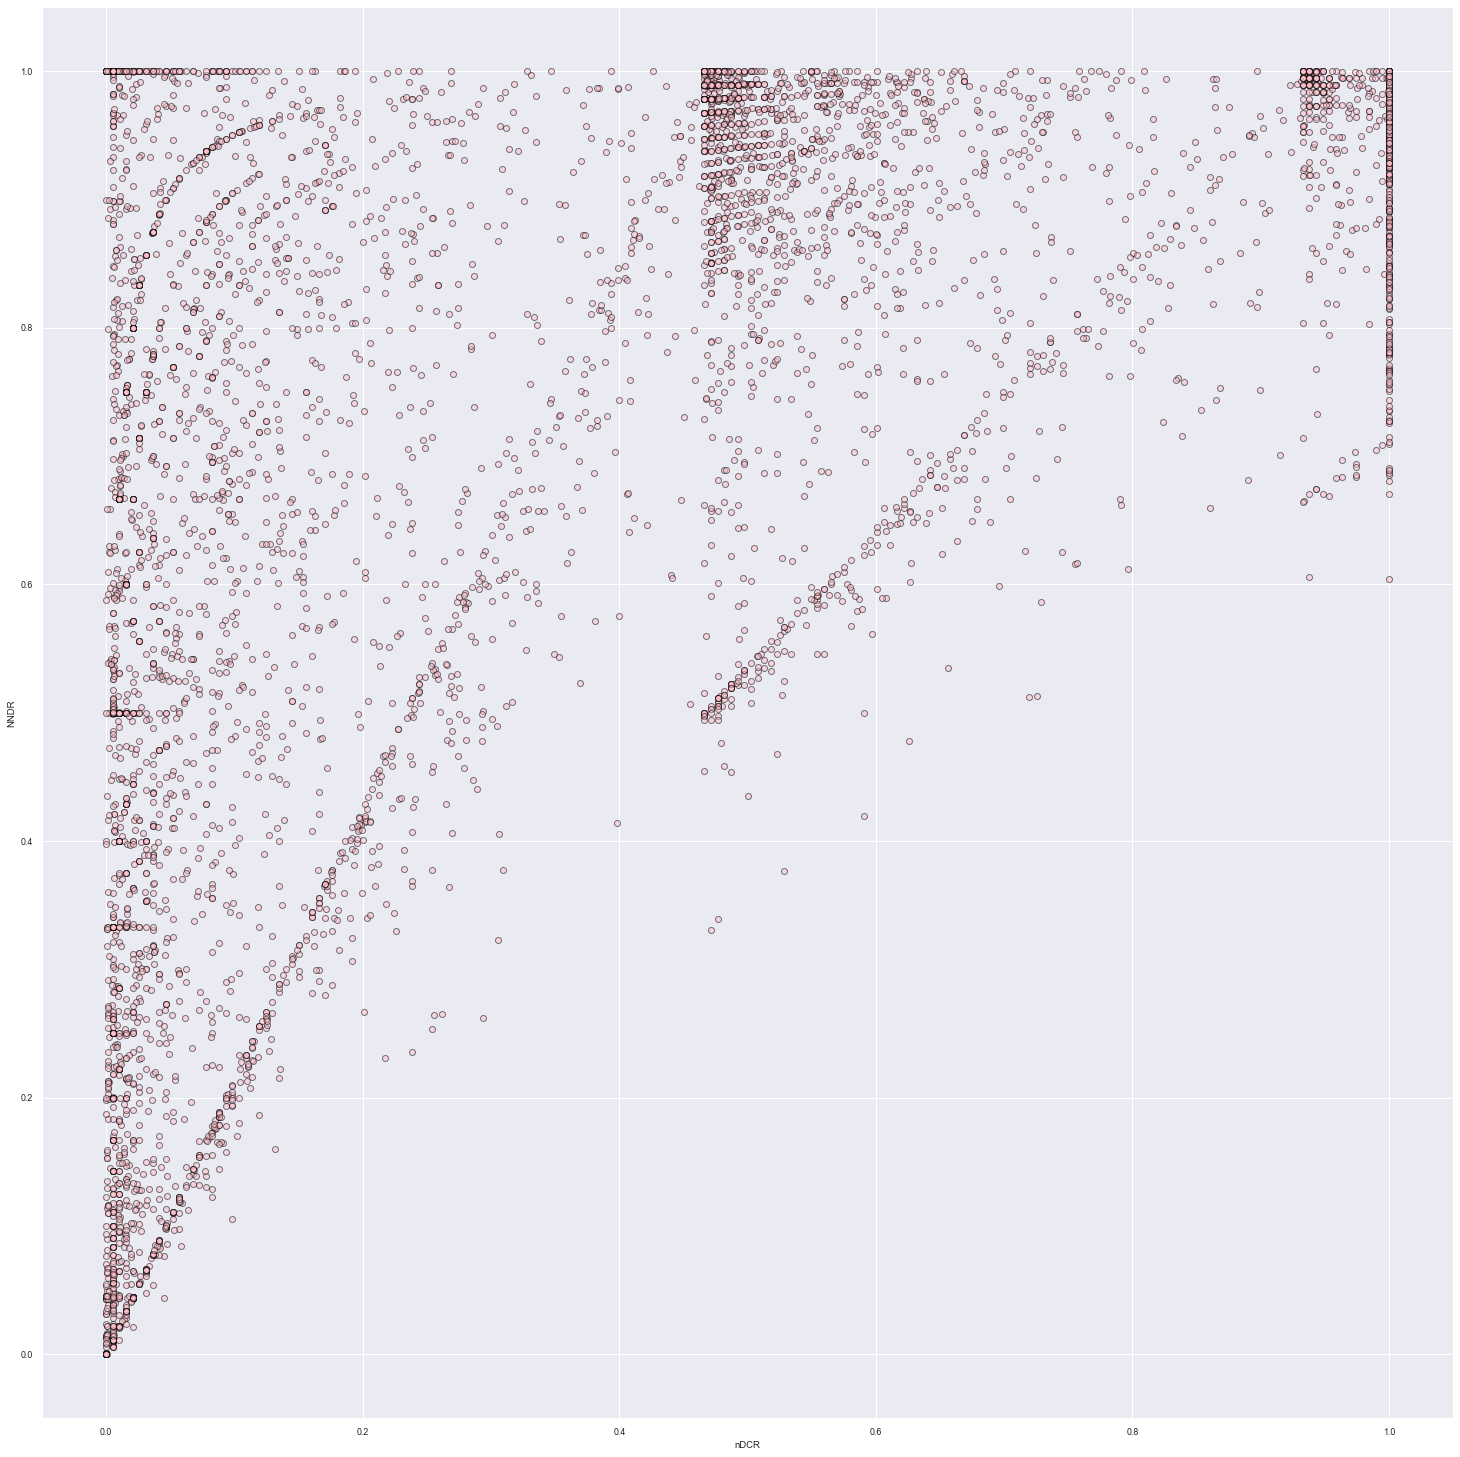

In [602]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
#ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [603]:
calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy())

1.0

In [604]:
calc_nndr_ratio(nndr_real,nndr_real.copy())

1.0

In [605]:
res_privacy = pd.DataFrame([['Real dataset', bound,
                        calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy()),
                        calc_nndr_ratio(nndr_real,nndr_real.copy()),
                        np.median(dcr_real_norm),
                        np.median(nndr_real),
                        dcr_real_norm.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_12680\106412619.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  privacy_results = pd.concat([privacy_results, res_privacy],axis=0)


## DistillGPT2 privacy

In [279]:
syn_test1 = synt_data_distilgpt2.sample(n=control_size) 

In [280]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [281]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [282]:
nbs1 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy()[:10000],base=hmm_train.to_numpy()[:10000],norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [283]:
print('Stats : mean, std, max, min, amount')
dcr_synt1 = np.array([d[0] for d in [x[1] for x in [i for i in nbs1]]])
dcr2_synt1 = np.array([d[1] for d in [x[1] for x in [i for i in nbs1]]])
nndr_synt1 = dcr_synt1 / np.maximum(dcr2_synt1, smoothing_factor) 
print('NNDR stats', nndr_synt1.mean(), nndr_synt1.std(), nndr_synt1.max(), nndr_synt1.min(), len (nndr_synt1))
dcr_synt_norm1 = np.where(dcr_synt1 <= bound, dcr_synt1 / bound, 1)
print('nDCR stats', dcr_synt_norm1.mean(), dcr_synt_norm1.std(), dcr_synt_norm1.max(), dcr_synt_norm1.min(), len(dcr_synt_norm1))

baseline_dcr = dcr_synt1
bound1 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound1)

Stats : mean, std, max, min, amount
NNDR stats 0.4523878376422296 0.41813352492812894 1.0 0.0 9000
nDCR stats 0.18243231931721468 0.27218925977716724 1.0 0.0 9000
DCR Bound 0.95 % = 1.7657329534833803


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for DistillGPT synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for DistillGPT synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'}>]],
      dtype=object)

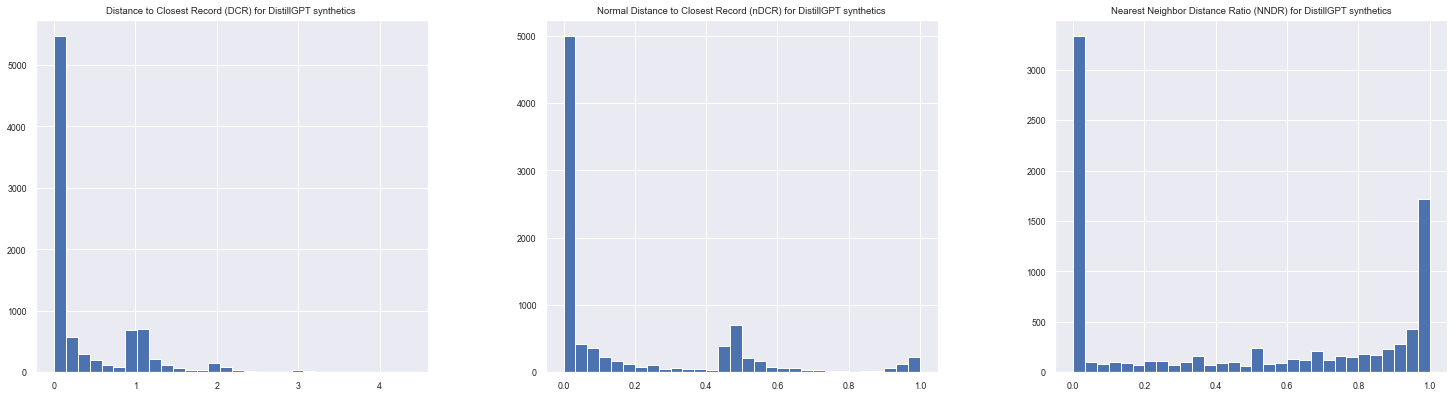

In [284]:
synt_privacy = pd.DataFrame(zip(dcr_synt1,dcr_synt_norm1,nndr_synt1),columns=['Distance to Closest Record (DCR) for DistillGPT synthetics ','Normal Distance to Closest Record (nDCR) for DistillGPT synthetics','Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

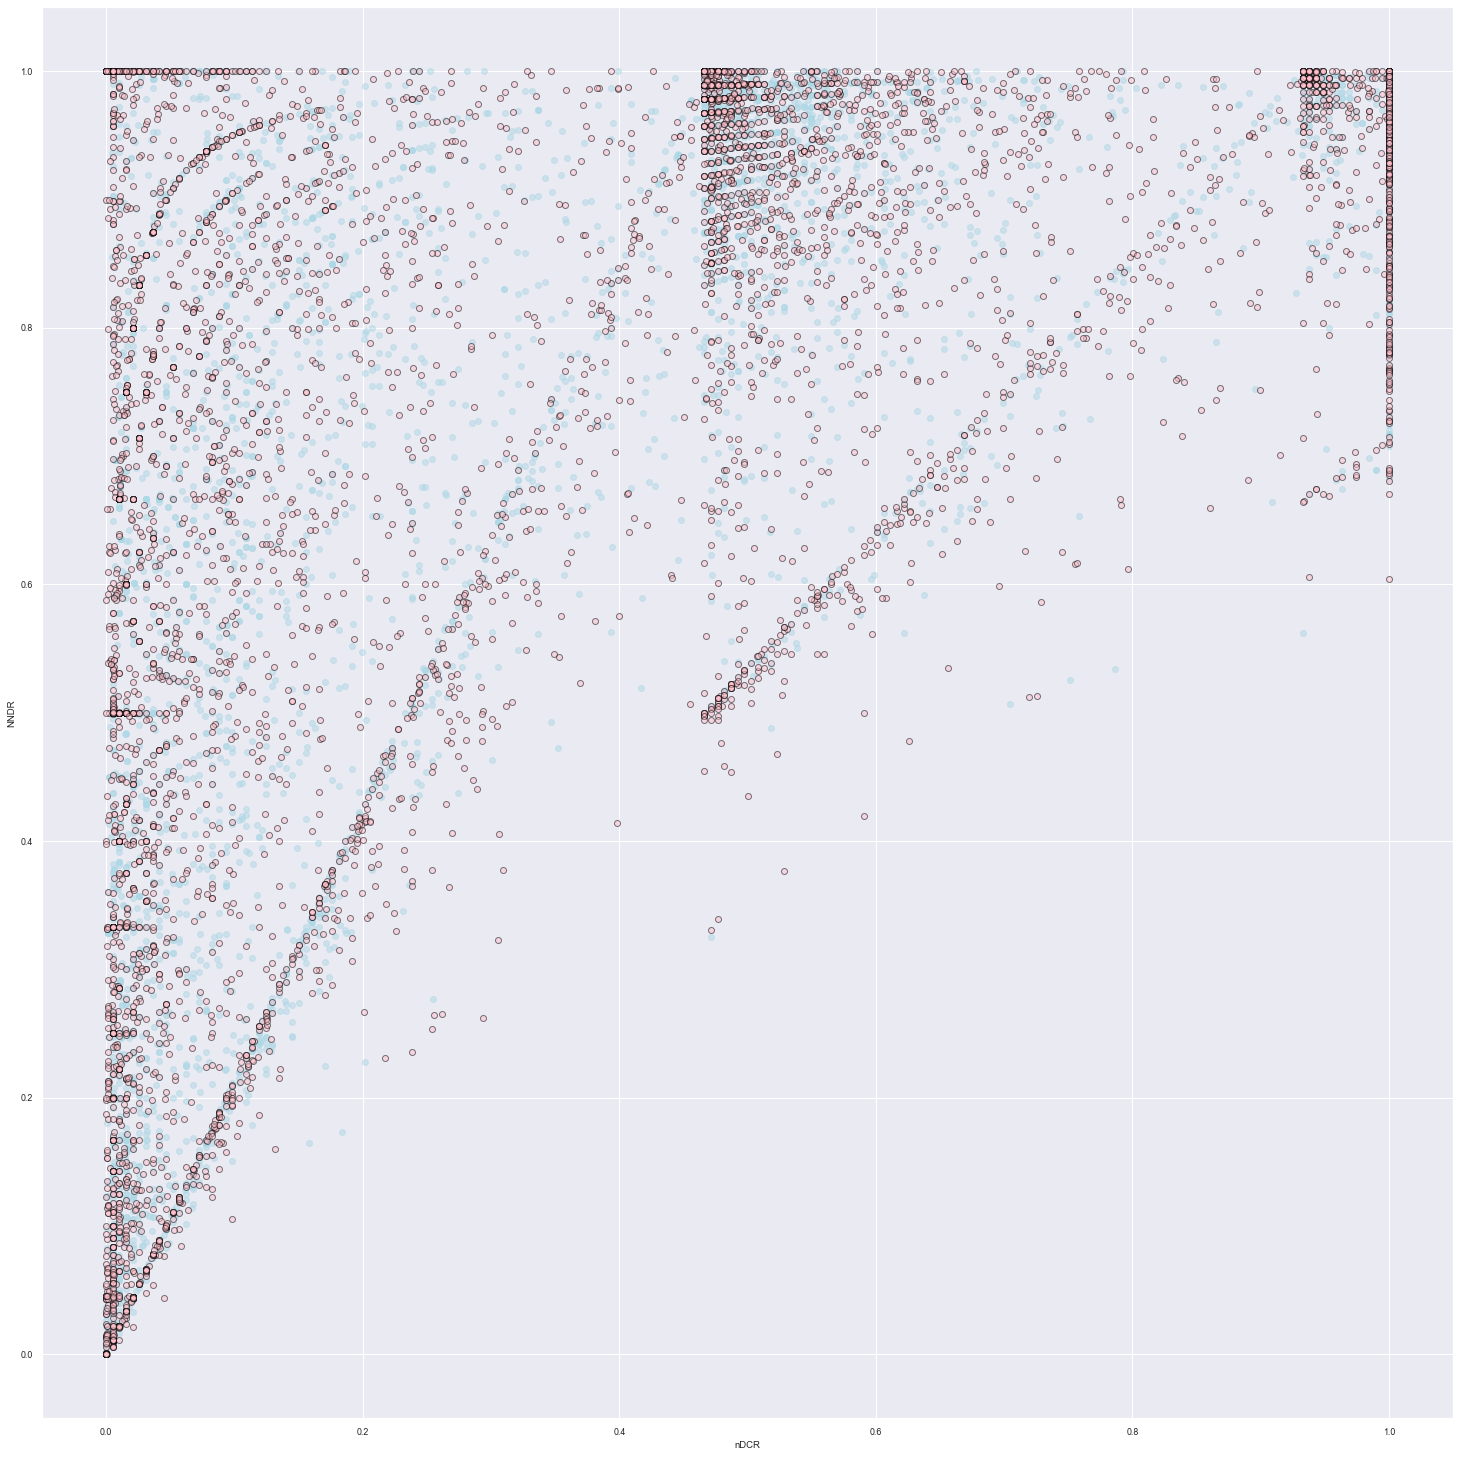

In [285]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [286]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1)

0.8488085456039441

In [287]:
calc_nndr_ratio(nndr_real,nndr_synt1)

0.8552875695732839

In [288]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm1)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt1)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm1)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt1)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=43356928.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=41751658.000000, p-value=0.000247
 Kolmogorov-Smirnov Test for nDCR: statistic=0.06666667, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.043778, p-value=0.000000


In [289]:
res_privacy = pd.DataFrame([['DistillGPT2', bound1,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1),
                        calc_nndr_ratio(nndr_real,nndr_synt1),
                        np.median(dcr_synt_norm1),
                        np.median(nndr_synt1),
                        dcr_synt_norm1.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## GPT2XL privacy

In [290]:
syn_test1 = synt_data_gpt2xl.sample(n=control_size) 

In [291]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [292]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [293]:
nbs2 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [294]:
print('Stats : mean, std, max, min, amount')
dcr_synt2 = np.array([d[0] for d in [x[1] for x in [i for i in nbs2]]])
dcr2_synt2 = np.array([d[1] for d in [x[1] for x in [i for i in nbs2]]])
nndr_synt2 = dcr_synt2 / np.maximum(dcr2_synt2, smoothing_factor) 
print('NNDR stats', nndr_synt2.mean(), nndr_synt2.std(), nndr_synt2.max(), nndr_synt2.min(), len (nndr_synt2))
dcr_synt_norm2 = np.where(dcr_synt2 <= bound, dcr_synt2 / bound, 1)
print('nDCR stats', dcr_synt_norm2.mean(), dcr_synt_norm2.std(), dcr_synt_norm2.max(), dcr_synt_norm2.min(), len (dcr_synt_norm2))

baseline_dcr = dcr_synt2
bound2 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound2)

Stats : mean, std, max, min, amount
NNDR stats 0.29473575779559563 0.3861808897305854 1.0 0.0 9000
nDCR stats 0.07450858877460836 0.1832230726024981 1.0 0.0 9000
DCR Bound 0.95 % = 1.0394061729078803


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for GPTxl synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for GPTxl synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'}>]],
      dtype=object)

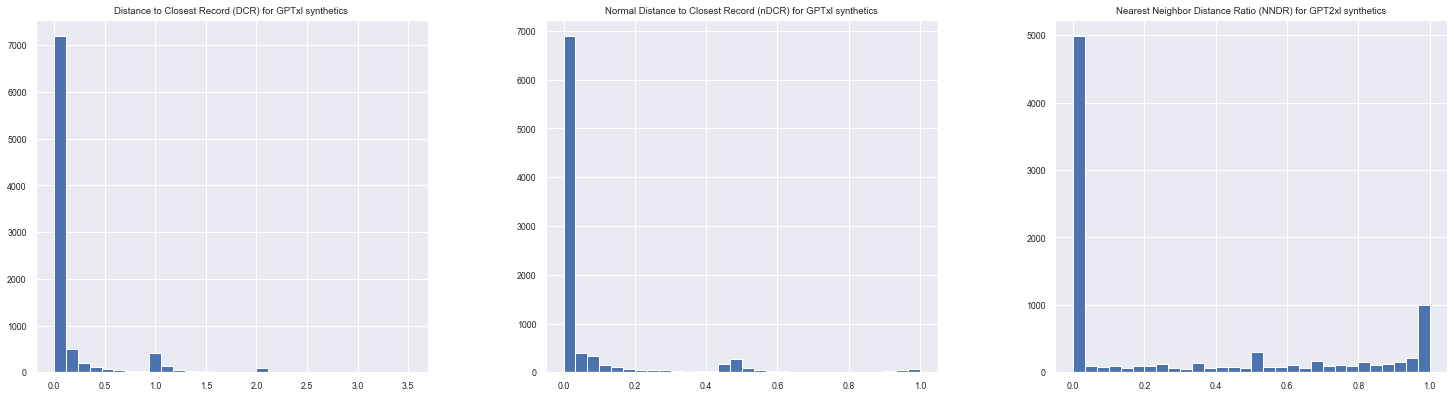

In [295]:
synt_privacy = pd.DataFrame(zip(dcr_synt2,dcr_synt_norm2,nndr_synt2),columns=['Distance to Closest Record (DCR) for GPTxl synthetics ','Normal Distance to Closest Record (nDCR) for GPTxl synthetics','Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

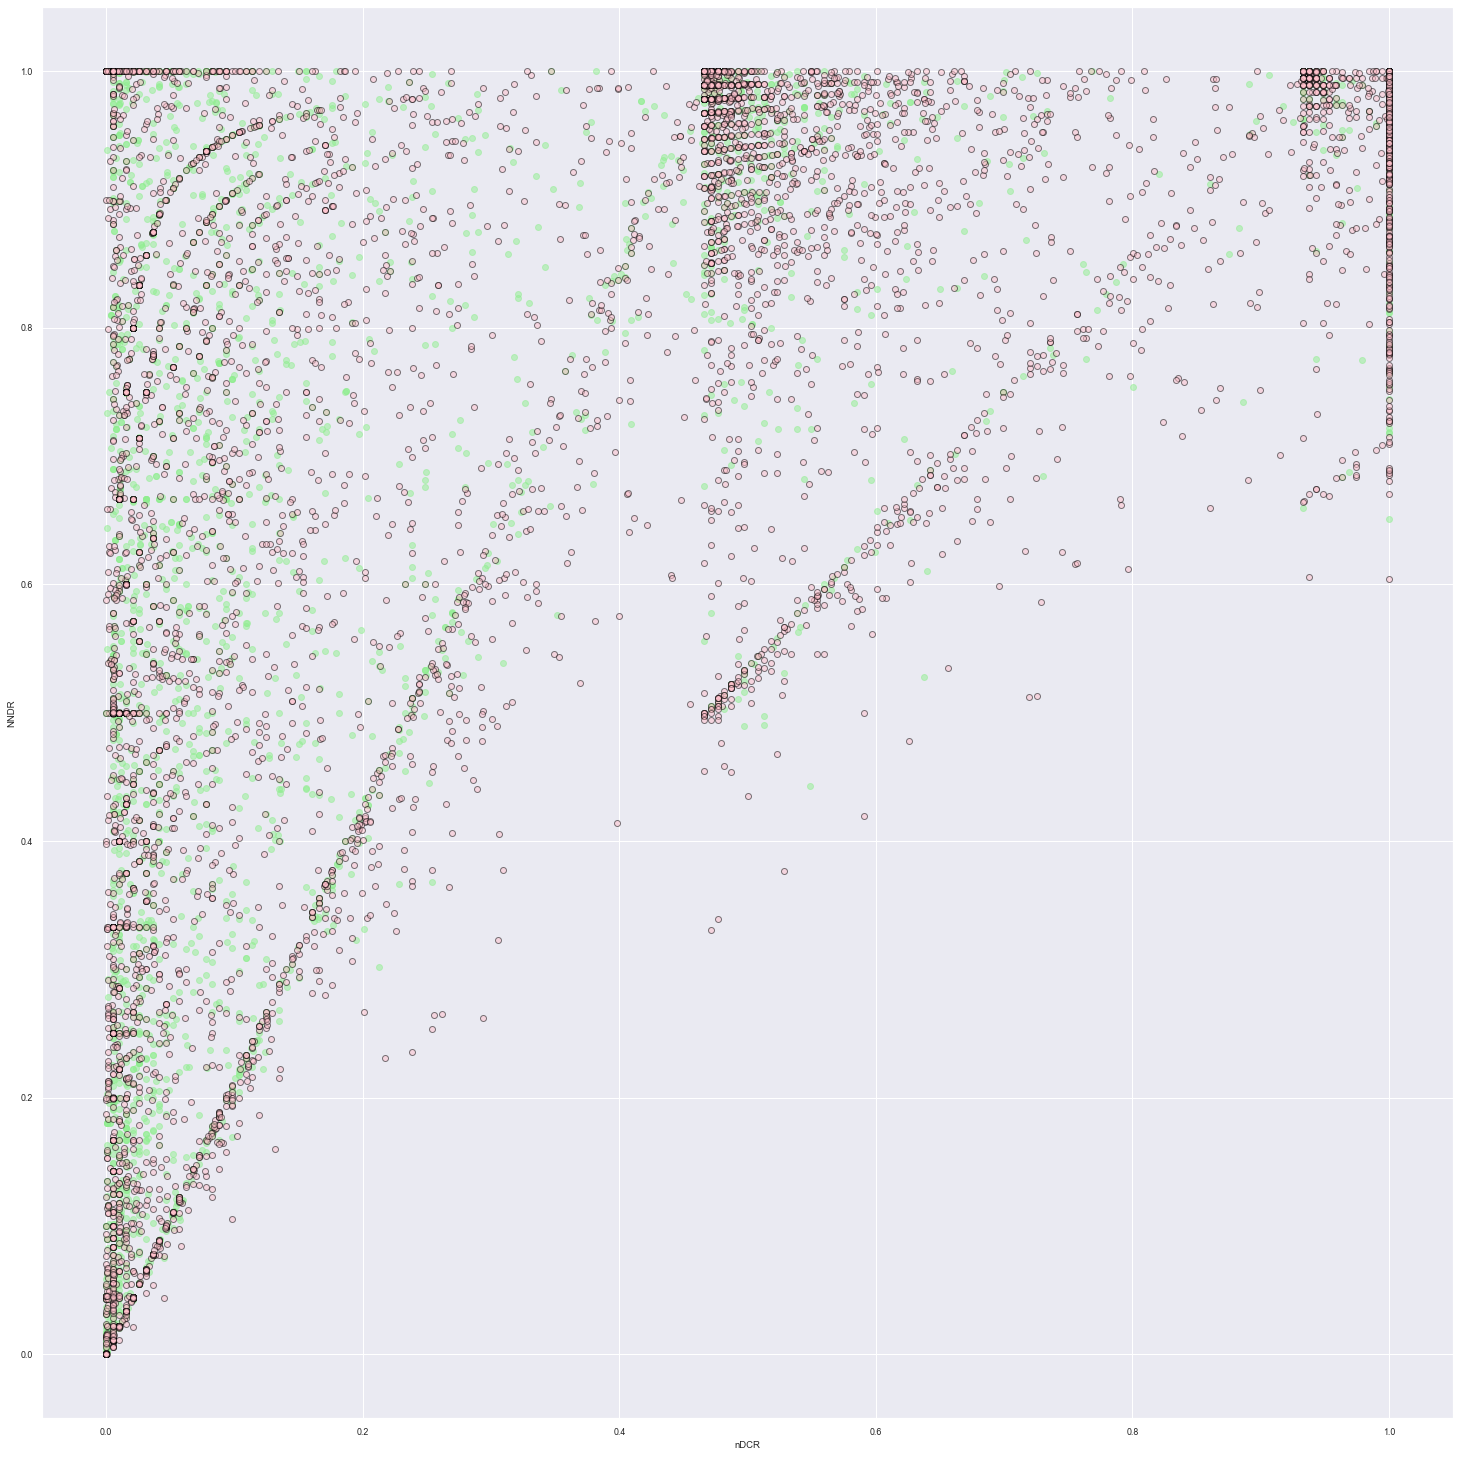

In [296]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [297]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2)

0.3293943870014771

In [298]:
calc_nndr_ratio(nndr_real,nndr_synt2)

0.4082303238929745

In [299]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm2)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt2)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm2)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt2)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=53469846.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=50643125.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.25500000, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.222556, p-value=0.000000


In [301]:
res_privacy = pd.DataFrame([['GPT2xl', bound2,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2),
                        calc_nndr_ratio(nndr_real,nndr_synt2),
                        np.median(dcr_synt_norm2),
                        np.median(nndr_synt2),
                        dcr_synt_norm2.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Cerebras privacy

In [302]:
syn_test1 = synt_data_cerebras.sample(n=control_size) 

In [303]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [304]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [305]:
nbs3 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [306]:
print('Stats : mean, std, max, min, amount')
dcr_synt3 = np.array([d[0] for d in [x[1] for x in [i for i in nbs3]]])
dcr2_synt3 = np.array([d[1] for d in [x[1] for x in [i for i in nbs3]]])
nndr_synt3 = dcr_synt3 / np.maximum(dcr2_synt3, smoothing_factor) 
print('NNDR stats', nndr_synt3.mean(), nndr_synt3.std(), nndr_synt3.max(), nndr_synt3.min(), len (nndr_synt3))
dcr_synt_norm3 = np.where(dcr_synt3 <= bound, dcr_synt3 / bound, 1)
print('nDCR stats', dcr_synt_norm3.mean(), dcr_synt_norm3.std(), dcr_synt_norm3.max(), dcr_synt_norm3.min(), len (dcr_synt_norm3))

baseline_dcr = dcr_synt3
bound3 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound3)

Stats : mean, std, max, min, amount
NNDR stats 0.2861446682932294 0.38226314772593106 1.0 0.0 9000
nDCR stats 0.07233411066673441 0.1813986492492009 1.0 0.0 9000
DCR Bound 0.95 % = 1.0333333333333334


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Cerebras synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Cerebras synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'}>]],
      dtype=object)

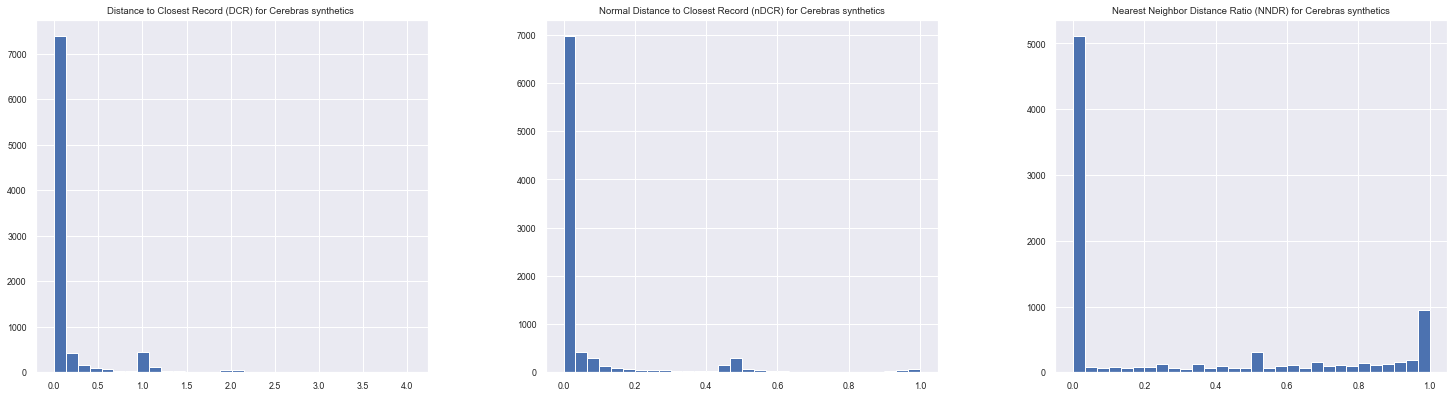

In [307]:
synt_privacy = pd.DataFrame(zip(dcr_synt3,dcr_synt_norm3,nndr_synt3),columns=['Distance to Closest Record (DCR) for Cerebras synthetics ','Normal Distance to Closest Record (nDCR) for Cerebras synthetics','Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

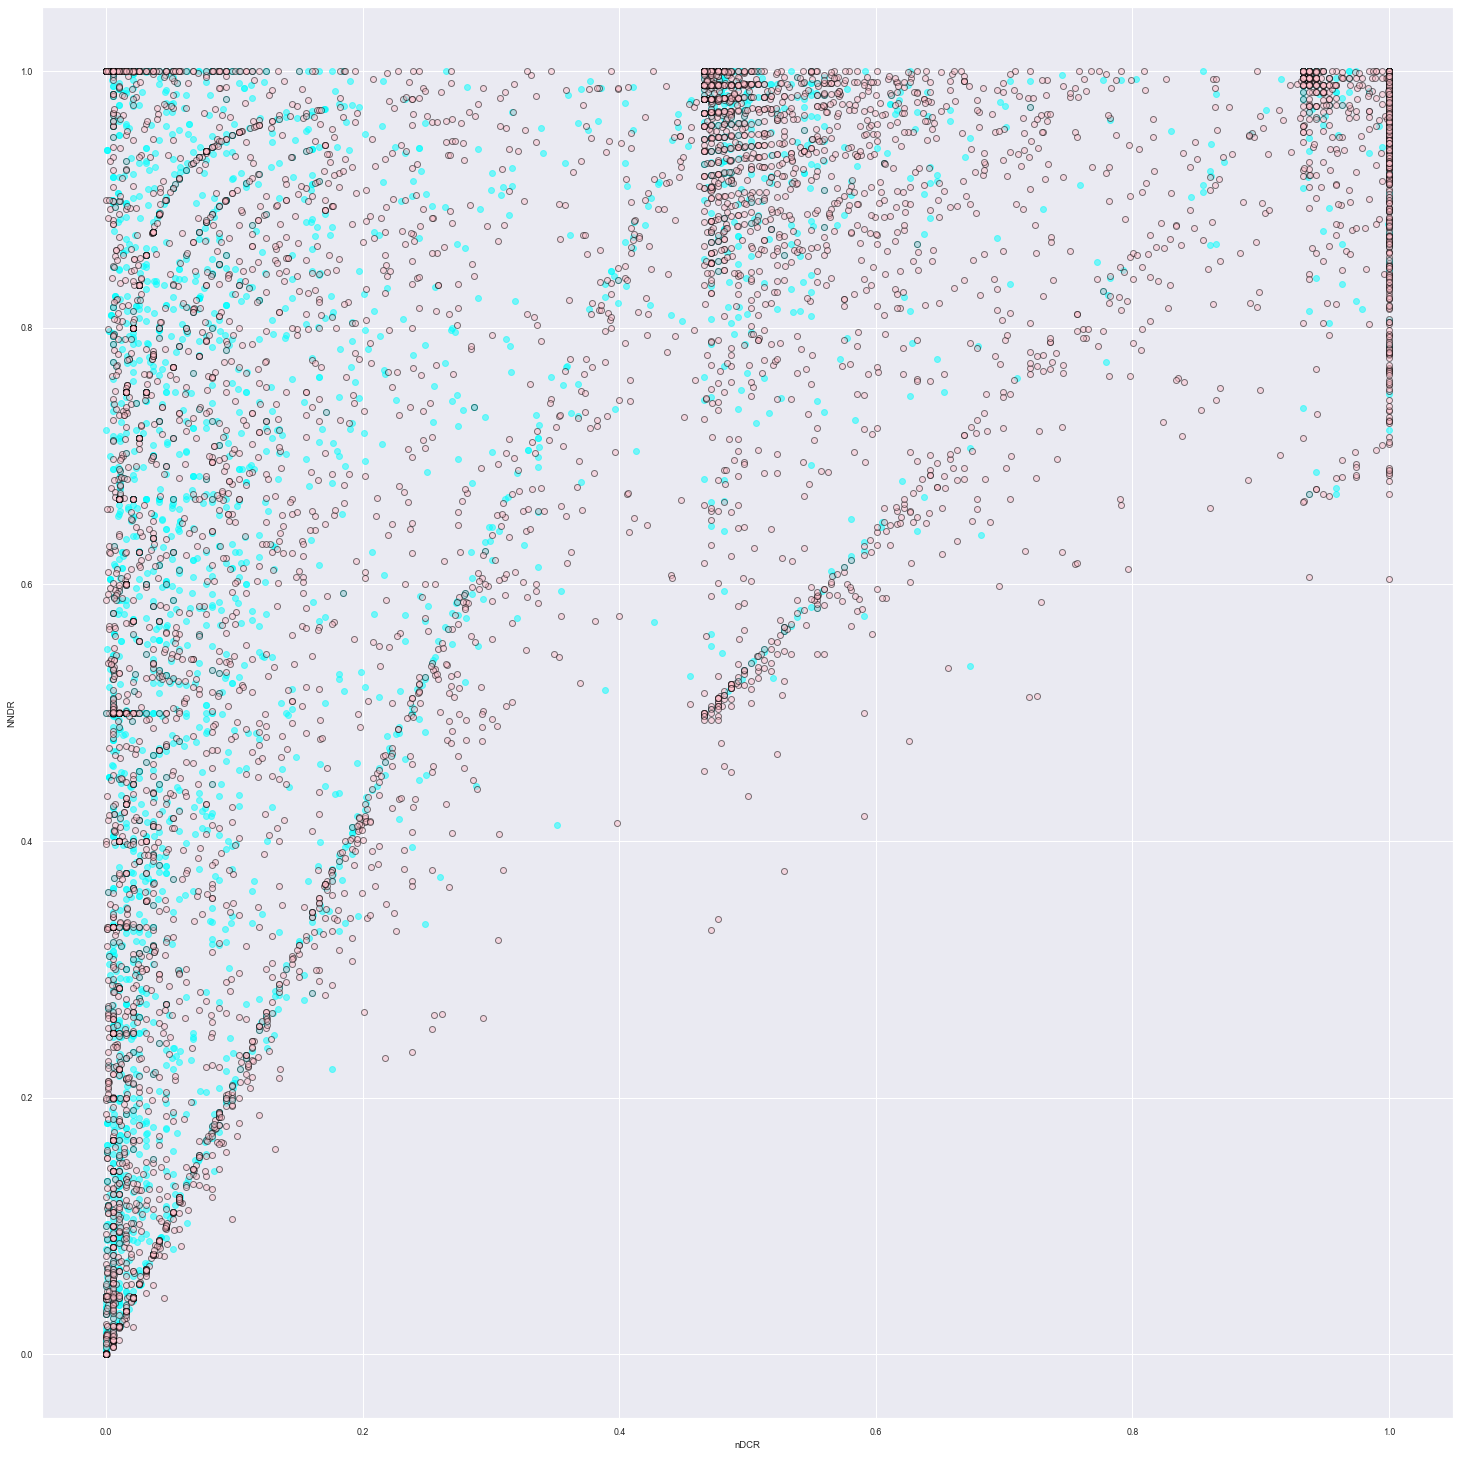

In [308]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [309]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3)

0.31310183834257366

In [310]:
calc_nndr_ratio(nndr_real,nndr_synt3)

0.39189607175997526

In [311]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm3)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt3)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm3)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt3)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=53957279.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=51259196.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.26388889, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.238222, p-value=0.000000


In [312]:
res_privacy = pd.DataFrame([['Cerebras', bound3,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3),
                        calc_nndr_ratio(nndr_real,nndr_synt3),
                        np.median(dcr_synt_norm3),
                        np.median(nndr_synt3),
                        dcr_synt_norm3.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Phi-1.5 privacy

In [313]:
syn_test1 = synt_data_phi.sample(n=control_size) 

In [314]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [315]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [316]:
nbs4 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [317]:
print('Stats : mean, std, max, min, amount')
dcr_synt4 = np.array([d[0] for d in [x[1] for x in [i for i in nbs4]]])
dcr2_synt4 = np.array([d[1] for d in [x[1] for x in [i for i in nbs4]]])
nndr_synt4 = dcr_synt4 / np.maximum(dcr2_synt4, smoothing_factor) 
print('NNDR stats', nndr_synt4.mean(), nndr_synt4.std(), nndr_synt4.max(), nndr_synt4.min(), len (nndr_synt4))
dcr_synt_norm4 = np.where(dcr_synt4 <= bound, dcr_synt4 / bound, 1)
print('nDCR stats', dcr_synt_norm4.mean(), dcr_synt_norm4.std(), dcr_synt_norm4.max(), dcr_synt_norm4.min(), len (dcr_synt_norm4))

baseline_dcr = dcr_synt4
bound4 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound4)

Stats : mean, std, max, min, amount
NNDR stats 0.2925059474993706 0.38602435813763253 1.0 0.0 9000
nDCR stats 0.07233978522527353 0.1798514273035408 1.0 0.0 9000
DCR Bound 0.95 % = 1.0333333333333334


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Phi1.5 synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'}>]],
      dtype=object)

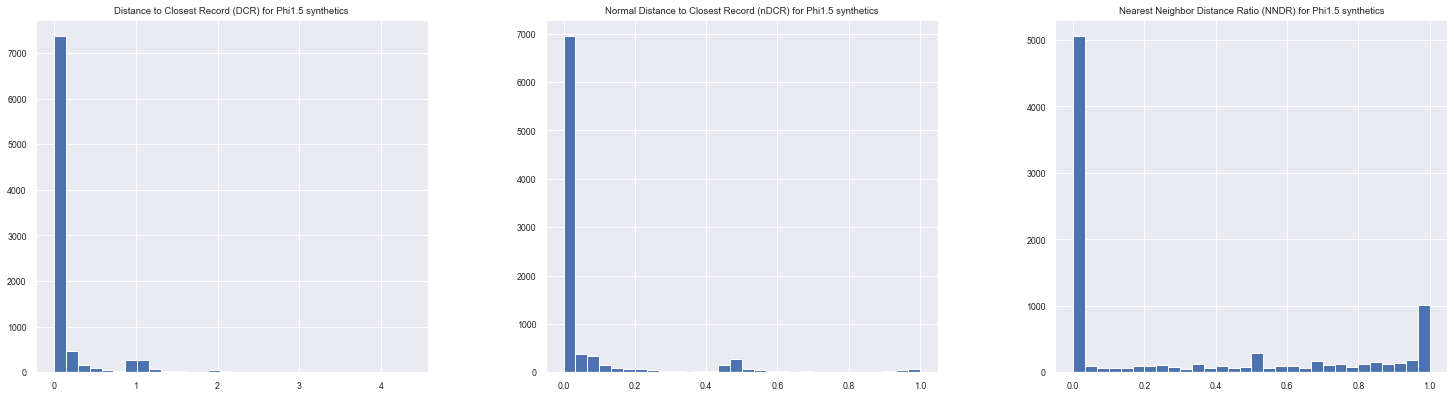

In [318]:
synt_privacy = pd.DataFrame(zip(dcr_synt4,dcr_synt_norm4,nndr_synt4),columns=['Distance to Closest Record (DCR) for Phi1.5 synthetics ','Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics','Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

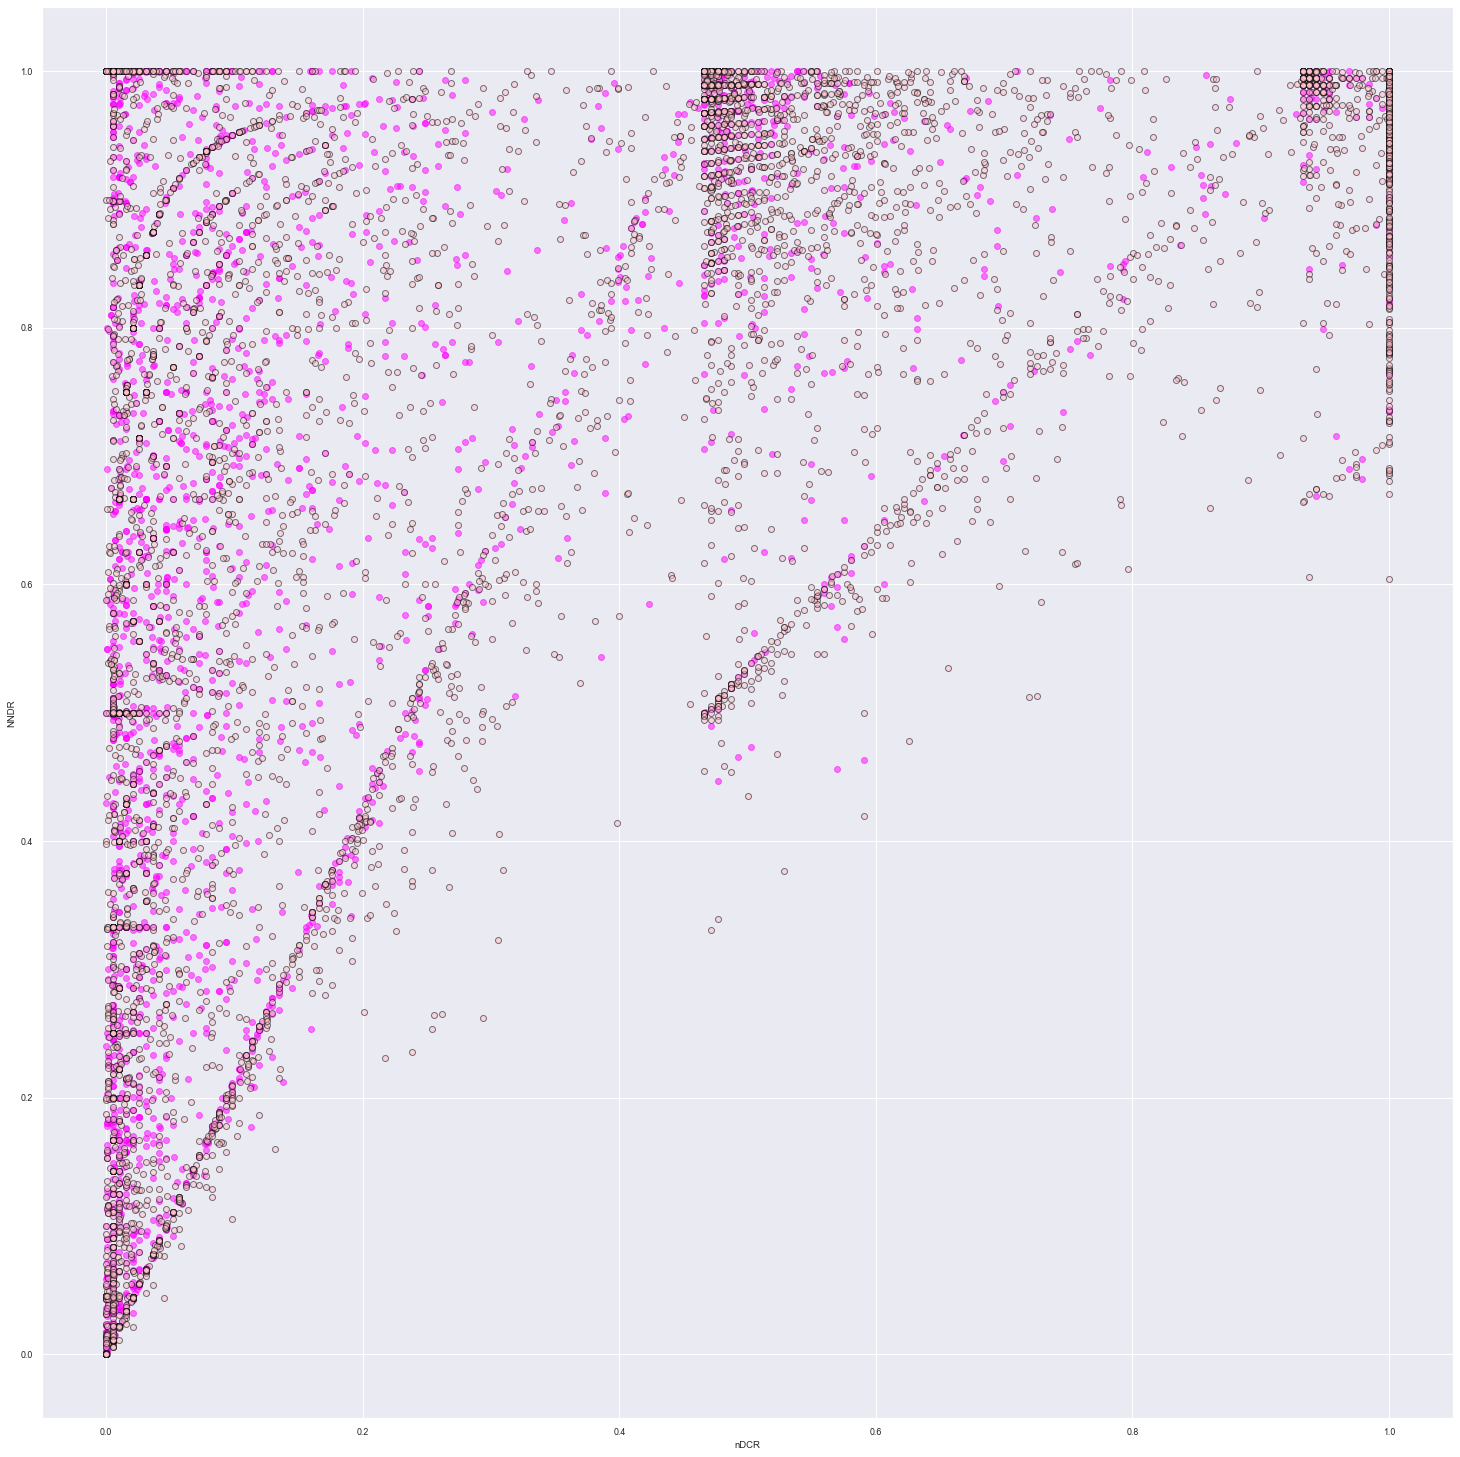

In [319]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [320]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4)

0.3200352009386917

In [321]:
calc_nndr_ratio(nndr_real,nndr_synt4)

0.4040561622464899

In [322]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm4)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt4)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm4)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt4)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=53777529.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=50834443.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.26144444, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.231000, p-value=0.000000


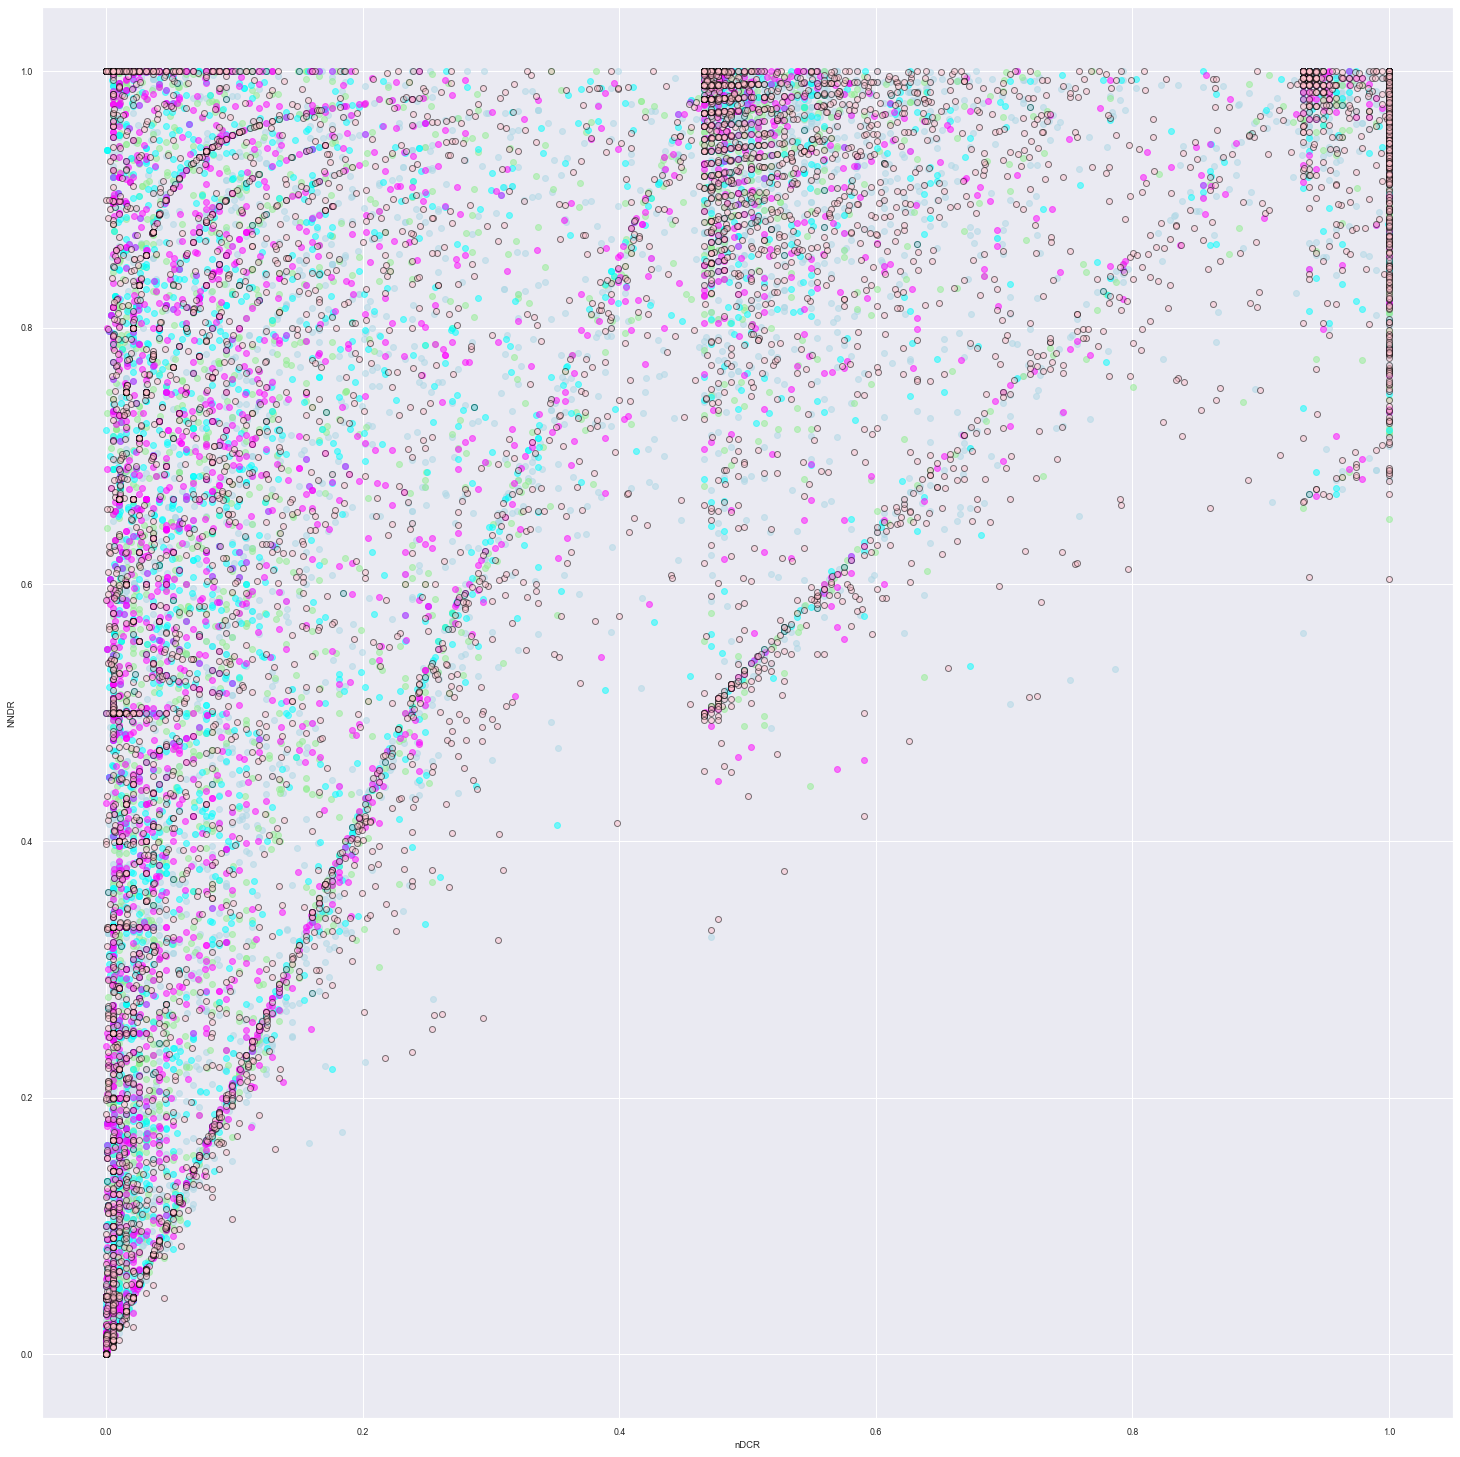

In [323]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi-1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [324]:
res_privacy = pd.DataFrame([['Phi1.5', bound4,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4),
                        calc_nndr_ratio(nndr_real,nndr_synt4),
                        np.median(dcr_synt_norm4),
                        np.median(nndr_synt4),
                        dcr_synt_norm4.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

### Privacy calculation results 

In [325]:
privacy_results

Model  95% bound  DCRn ratio  NNDR ratio  DCRn median  NNDR median  \
0  Real dataset   2.144444    1.000000    1.000000     0.026871     0.507562   
0   DistillGPT2   1.765733    0.848809    0.855288     0.015544     0.428571   
0        GPT2xl   1.039406    0.329394    0.408230     0.000000     0.000000   
0      Cerebras   1.033333    0.313102    0.391896     0.000000     0.000000   
0        Phi1.5   1.033333    0.320035    0.404056     0.000000     0.000000   

   Minimal distance  
0               0.0  
0               0.0  
0               0.0  
0               0.0  
0               0.0

In [326]:
privacy_results.to_csv('privacy_results_shortincome_temp0.7.csv')